In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import gridspec
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.font_manager as font_manager
import pandas as pd
font_dirs = ['/mnt/e/Misc/Python_Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
matplotlib.rcParams['font.family'] = 'arial'
import os
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import itertools
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector
stats_r = importr('stats')
import copy

In [2]:
cy_color_map = {'CY3':'red','CY5':'blue','488':'green'}
color_number_map = {'647':'blue','546':'red'}
cy_color_map_r = {'red':'CY3','blue':'CY5','green':'488'}
set_channel_map = {'Set_1':{'Ch2 M-T1':'green','Ch3-T2':'red','Ch3-T3':'blue','Ch1-T4':'cyan'},
                   'Set_2':{'Ch1-T1':'green','Ch2-T2':'red','Ch3-T3':'blue','Ch1-T4':'cyan'},
                   'Set_3':{'Ch3-T2':'red','Ch3-T3':'blue','Ch1-T4':'cyan'},
                   'Set_4':{'Ch2 M-T1':'green','Ch3-T2':'red','Ch3-T3':'blue','Ch1-T4':'cyan'},
                   'Set_5':{'Ch3-T1':'blue','Ch2 M-T2':'red','Ch1-T3':'cyan'},
                   'Set_7a':{'Ch2-T1':'blue','ChS2-T2':'red','Ch1-T4':'cyan'},
                   'Set_7':{'ChA-T1':'blue','ChA-T2':'red','ChA-T4':'cyan'},
                   'tiff_1':{'Alexa Fluor 594':'red','Alexa Fluor 488':'green','Hoechst 33342':'blue'}}

In [3]:
def read_in_metadata_for_samp(meta_dat,sample):
    meta_dat_samp = meta_dat[meta_dat.index==sample]
    set_id = meta_dat_samp['Set'][0]
    rosettes = []
    for rosette in meta_dat_samp['keep']:
        rosettes.append([float(x) for x in rosette.split(",")])
    return set_id,rosettes

In [4]:
def get_gene_to_color_map(set_id,sample):
    gene_color_dict = {'DAPI':'cyan'}
    gene_channel_dict = {}
    samp_split = sample.split("_")
    for k in range(len(samp_split)):
        col_split = samp_split[k]
        if col_split in ['647','546']:
            gene = samp_split[k-1]
            color = color_number_map[col_split]
            gene_color_dict[gene] = color
            for channel in set_channel_map[set_id]:
                if set_channel_map[set_id][channel] == color:
                    gene_channel_dict[gene] = channel
                if set_channel_map[set_id][channel] == 'cyan':
                    gene_channel_dict['DAPI'] = channel
        if col_split in ['CY3','CY5','488']:
            if 'analyzedX20_O2_NT_488_SOX2_CY3_MEF2C_CY5_DCX_organoid 2_MIP_19_02_2019' in sample:
                gene = samp_split[k+1]
            else:
                gene = samp_split[k-1]
            if sample == 'SA_NT-1_SOX1_CY3_FOXG1_CY5':
                if col_split == 'CY5':
                    gene = 'SOX1'
                if col_split == 'CY3':
                    col_split = '488'
                    gene = 'FOXG1'
            color = cy_color_map[col_split]
            gene_color_dict[gene] = color
            for channel in set_channel_map[set_id]:
                if set_channel_map[set_id][channel] == color:
                    gene_channel_dict[gene] = channel
                if set_channel_map[set_id][channel] == 'cyan':
                    gene_channel_dict['DAPI'] = channel

    gene_channel_dict_r = {}
    for gene,channel in gene_channel_dict.items():
        gene_channel_dict_r[channel] = gene

    return gene_channel_dict_r,gene_channel_dict,gene_color_dict

In [5]:
def read_in_zenn_count_df(fn):
    df=pd.read_csv(fn,delimiter=";")
    ## be careful here, because we might remove data rows with nans
    df = df.reset_index().dropna().set_index('index')
    for col in df.columns:
        if col[-3:]=='!!R' and df.dtypes[col]!='float64':
            df[col]=df[col].str.replace(',', '.').astype('float')
    return df

def get_dataframes_from_samp(sample):
    df_dict = {}
    files = [x for x in os.listdir('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/D30_countings_from_Rene/data/countings') if sample in x]
    for file in files:
        df = read_in_zenn_count_df('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/D30_countings_from_Rene/data/countings/'+file)
        if '__' in file:
            df_dict[file.split("__")[1].split(".")[0]] = df
        elif ' Region ' in file:
            df_dict[file.split(' Region ')[1].split(".")[0]] = df
        elif ' Regions ' in file:
            df_dict[file.split(' Regions ')[1].split(".")[0]] = df
        else:
            print('Not sure what file this is!! Please double check file name.')
    return df_dict

In [6]:
def build_rosette_id_mapping(df_dict):
    #R_Nucleis: "ParentID::ID of the parent!!I" contains rosette_id from metadata; "ID::ID!!I" contains rosette_id in R_Nuclei table
    #R_Nuclei: "ParentID::ID of the parent!!I" contains rosette_id corresponding to "ID::ID!!I" in R_Nucleis
    rosette_id_map = {}
    for parent_idx,idx in zip(df_dict['R_Nucleis']["ParentID::ID of the parent!!I"],df_dict['R_Nucleis']["ID::ID!!I"]):
        rosette_id_map[parent_idx] = idx
    return rosette_id_map

In [7]:
def get_rosette_and_non_rosette_mask_ids(df_dict,rosettes,rosette_id_map):
    # get all rosette masks and non-rosette masks across organoid
    tot_rosette_mask_ids = []
    rosette_mask_ids = []
    for rosette in rosettes:
        rosette_mask_ids.append([rosette_id_map[mask] for  mask in rosette])
        tot_rosette_mask_ids.extend([rosette_id_map[mask] for  mask in rosette])
    non_rosette_mask_ids = list(set(df_dict['R_Nucleis']['ID::ID!!I']) - set(tot_rosette_mask_ids))
    return rosette_mask_ids,tot_rosette_mask_ids,non_rosette_mask_ids

In [8]:
def reformat_dfs_with_8_bit(df_dict,rosettes,rosette_id_map,gene_channel_dict,gene="DAPI"):
    #scale all dfs to have 8 bit vals
    #just check max intensity in n_nuclei table for DAPI
    bit_value = '8-bit'
    channel = "IntensityMean_"+gene_channel_dict[gene]+"::Intensity Mean Value of channel '"+gene_channel_dict[gene]+"'!!R"
    max_val = max([max(df_dict['R_Nuclei'][channel]),max(df_dict['N_Nuclei'][channel])])
    df_dict_rescaled = {}
    if max_val > 2**12+1:
        bit_value = '16-bit'
        for table_id in df_dict:
            df_dict_rescaled[table_id] = copy.deepcopy(df_dict[table_id])
            for col in df_dict_rescaled[table_id].columns:
                if "Intensity" in col:
                    df_dict_rescaled[table_id][col] = df_dict_rescaled[table_id][col]/256.
    elif max_val > 2**8+1:
        bit_value = '12-bit'
        for table_id in df_dict:
            df_dict_rescaled[table_id] = copy.deepcopy(df_dict[table_id])
            for col in df_dict_rescaled[table_id].columns:
                if "Intensity" in col:
                    df_dict_rescaled[table_id][col] = df_dict_rescaled[table_id][col]/16.
    else:
        df_dict_rescaled = df_dict
    return(df_dict_rescaled,bit_value)

In [9]:
def filter_cells_by_DAPI(df_dict,df_dict_rescaled,DAPI_cutoff=15,gene="DAPI"):
    #filter all cells with low DAPI
    channel = "IntensityMean_"+gene_channel_dict[gene]+"::Intensity Mean Value of channel '"+gene_channel_dict[gene]+"'!!R"
    df_dict['R_Nuclei'] = df_dict['R_Nuclei'][df_dict_rescaled['R_Nuclei'][channel]>DAPI_cutoff]
    df_dict['N_Nuclei'] = df_dict['N_Nuclei'][df_dict_rescaled['N_Nuclei'][channel]>DAPI_cutoff]
    df_dict_rescaled['R_Nuclei'] = df_dict_rescaled['R_Nuclei'][df_dict_rescaled['R_Nuclei'][channel]>DAPI_cutoff]
    df_dict_rescaled['N_Nuclei'] = df_dict_rescaled['N_Nuclei'][df_dict_rescaled['N_Nuclei'][channel]>DAPI_cutoff]
    return(df_dict,df_dict_rescaled)

In [10]:
def filter_rosettes(df_dict,df_dict_rescaled,rosette_mask_ids,n_cells_cutoff=100):
    rosette_ids_to_remove = []
    rosette_mask_ids_sub = []
    for rosette_masks in rosette_mask_ids:
        n_cells = len(df_dict['R_Nuclei'][df_dict['R_Nuclei']["ParentID::ID of the parent!!I"].isin(rosette_masks)])
        if n_cells < n_cells_cutoff:
            rosette_ids_to_remove.extend(rosette_masks)
        else:
            rosette_mask_ids_sub.append(rosette_masks)
    df_dict['R_Nuclei'] = df_dict['R_Nuclei'][~df_dict['R_Nuclei']["ParentID::ID of the parent!!I"].isin(rosette_ids_to_remove)]
    df_dict_rescaled['R_Nuclei'] = df_dict_rescaled['R_Nuclei'][~df_dict_rescaled['R_Nuclei']["ParentID::ID of the parent!!I"].isin(rosette_ids_to_remove)]
    return df_dict,df_dict_rescaled,rosette_mask_ids_sub

In [11]:
def plot_histogram_channel(gene,gene_channel_dict,df_dict,tot_rosette_mask_ids,non_rosette_mask_ids,set_id,gene_color_dict,bit_value,
                          fig=None,ax=None):
    
    if fig is None:
        fig = plt.figure(figsize=(8,4))
        ax = plt.subplot(111)

    channel = "IntensityMean_"+gene_channel_dict[gene]+"::Intensity Mean Value of channel '"+gene_channel_dict[gene]+"'!!R"
    vals_1 = list(df_dict['R_Nuclei'][df_dict['R_Nuclei']["ParentID::ID of the parent!!I"].isin(tot_rosette_mask_ids)][channel])
    vals_2 = list(df_dict['R_Nuclei'][df_dict['R_Nuclei']["ParentID::ID of the parent!!I"].isin(non_rosette_mask_ids)][channel])
    vals_3 = list(df_dict['N_Nuclei'][channel])
    labs = ['rosette_nuclei','misclassified_rosette_nuclei','non_rosette_nuclei']
    if gene_color_dict[gene] == 'red':
        colors = ['red','magenta','gray']
    elif gene_color_dict[gene] == 'blue':
        colors = ['blue','cyan','gray']
    elif gene_color_dict[gene] == 'green':
        colors = ['green','limegreen','gray']
    elif gene_color_dict[gene] == 'cyan':
        colors = ['cyan','dodgerblue','gray']

    max_vals = max([max(vals_1),max(vals_2),max(vals_3)])
    for vals,lab,color in zip([vals_1,vals_2,vals_3],labs,colors):
        bars,x_idx = np.histogram(vals,bins=np.linspace(0,round(max_vals)+10,int(round(max_vals)+11)),density=True)
        dx = x_idx[1]-x_idx[0]
        x_idx_plot = [x+dx/2. for x in x_idx[:-1]]
        #plt.bar(x_idx_plot,bars,alpha=0.,color=color)
        sns.distplot(vals,bins=np.linspace(0,round(max_vals)+10,int(round(max_vals)+11)),label=lab,color=color)

    plt.legend(fontsize=16)
    plt.xlabel(gene,fontsize=18)
    plt.title(sample+', Set='+set_id+', bit='+bit_value,fontsize=18)
    plt.ylabel('Density',fontsize=18)
    xmax = plt.xlim()[1]
    new_xmax = int(round(xmax/10.)*10)
    if xmax > 150:
        plt.xticks(np.linspace(0,new_xmax,int(new_xmax/10.+1)),fontsize=14)
    else:
        plt.xticks(np.linspace(0,new_xmax,int(new_xmax/5.+1)),fontsize=14)
    plt.yticks(fontsize=14)
    return fig

In [12]:
def get_pos_neg_cells_per_rosette(gene,gene_channel_dict,df_dict,tot_rosette_mask_ids,non_rosette_mask_ids,intensity_cutoff):
    
    channel = "IntensityMean_"+gene_channel_dict[gene]+"::Intensity Mean Value of channel '"+gene_channel_dict[gene]+"'!!R"
    df_rose_pos = df_dict['R_Nuclei'][df_dict['R_Nuclei'][channel] >= intensity_cutoff]
    df_rose_neg = df_dict['R_Nuclei'][df_dict['R_Nuclei'][channel] < intensity_cutoff]
    df_nonrosette_pos = df_dict['N_Nuclei'][df_dict['N_Nuclei'][channel] >= intensity_cutoff]
    df_nonrosette_neg = df_dict['N_Nuclei'][df_dict['N_Nuclei'][channel] < intensity_cutoff]
    
    pos_ids_per_rosette = []
    neg_ids_per_rosette = []
    for rosette in rosette_mask_ids:
        pos_ids_per_rosette.append(list(df_rose_pos[df_rose_pos["ParentID::ID of the parent!!I"].isin(rosette)]['ID::ID!!I']))
        neg_ids_per_rosette.append(list(df_rose_neg[df_rose_neg["ParentID::ID of the parent!!I"].isin(rosette)]['ID::ID!!I']))

    pos_ids_mistaken_rosettes = list(df_rose_pos[df_rose_pos["ParentID::ID of the parent!!I"].isin(non_rosette_mask_ids)]['ID::ID!!I'])
    neg_ids_mistaken_rosettes = list(df_rose_neg[df_rose_neg["ParentID::ID of the parent!!I"].isin(non_rosette_mask_ids)]['ID::ID!!I'])
    
    pos_ids_non_rosette = list(df_nonrosette_pos['ID::ID!!I'])
    neg_ids_non_rosette = list(df_nonrosette_neg['ID::ID!!I'])
    
    return pos_ids_per_rosette,neg_ids_per_rosette,pos_ids_mistaken_rosettes,neg_ids_mistaken_rosettes,pos_ids_non_rosette,neg_ids_non_rosette

In [13]:
def plot_comparisons_single_positives(pos_ids_per_rosette,neg_ids_per_rosette,pos_ids_mistaken_rosettes,\
                                      neg_ids_mistaken_rosettes,pos_ids_non_rosette,neg_ids_non_rosette,\
                                      gene,sample):
    
    df_for_plotting = pd.DataFrame(
    {'n_pos_cells': [len(x) for x in pos_ids_per_rosette],
     'n_dapi': [len(x)+len(y) for x,y in zip(pos_ids_per_rosette,neg_ids_per_rosette)]
    })
    df_for_plotting['percent_pos'] = df_for_plotting['n_pos_cells']/df_for_plotting['n_dapi']
    
    fig = plt.figure(figsize=(2,4))
    ax = sns.boxplot(y='percent_pos', data=df_for_plotting)
    ax = sns.swarmplot(y='percent_pos', data=df_for_plotting, color=".25")
    plt.ylabel('No. '+gene+' cells / DAPI',fontsize=16)
    plt.yticks(fontsize=18)
    plt.title(sample,fontsize=18)
    return fig

In [14]:
def get_protocol_from_sample_name(sample):
    if 'SBNX' in sample or 'sbnx' in sample:
        protocol = 'Triple-i'
    elif 'SBN' in sample or 'sbn' in sample:
        protocol = 'Dual SMAD-i'
    elif 'NT' in sample or 'nt' in sample:
        protocol = 'Inhibitor-free'
    elif 'zip8k8_orgn17_d30_emx1_647_pax6_546' in  sample:
        # this is a hack for the pax6,emx1 sample -- need to be careful with this
        protocol = 'Triple-i'
    else:
        protocol = 'Unknown'
    return protocol

In [15]:
def generate_df_for_plotting(pos_negs_ids_per_gene,gene_pair,sample):
    
    protocol = get_protocol_from_sample_name(sample)
    df_dict = {'experiment':[],'n_DAPI':[],'gene':[],'n_pos':[],'sample':[],'protocol':[],'type':[]}
    for gene in gene_pair:
        df_dict['n_DAPI'].extend([len(x)+len(y) for x,y in zip(pos_negs_ids_per_gene[gene][0],pos_negs_ids_per_gene[gene][1])])
        df_dict['gene'].extend([gene for k in range(len(pos_negs_ids_per_gene[gene][0]))])
        df_dict['n_pos'].extend([len(x) for x in pos_negs_ids_per_gene[gene][0]])
        df_dict['sample'].extend([sample for x in pos_negs_ids_per_gene[gene][0]])
        df_dict['protocol'].extend([protocol for x in pos_negs_ids_per_gene[gene][0]])
        df_dict['type'].extend(['rosette' for x in pos_negs_ids_per_gene[gene][0]])
        df_dict['experiment'].extend(['_'.join(sorted(gene_pair)) for x in pos_negs_ids_per_gene[gene][0]])
        
    #count double positives
    df_dict['n_DAPI'].extend([len(x)+len(y) for x,y in zip(pos_negs_ids_per_gene[gene][0],pos_negs_ids_per_gene[gene][1])])
    df_dict['gene'].extend([gene_pair[0]+'_'+gene_pair[1] for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    df_dict['sample'].extend([sample for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    df_dict['protocol'].extend([protocol for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    df_dict['type'].extend(['rosette' for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    df_dict['experiment'].extend(['_'.join(sorted(gene_pair)) for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    double_positives = []
    for k in range(len(pos_negs_ids_per_gene[gene_pair[0]][0])):
        double_positives.append(list(set(pos_negs_ids_per_gene[gene_pair[0]][0][k]).intersection(set(pos_negs_ids_per_gene[gene_pair[1]][0][k]))))
    df_dict['n_pos'].extend([len(x) for x in double_positives])
    
    df_for_plotting = pd.DataFrame(df_dict)
    df_for_plotting['percent_pos'] = df_for_plotting['n_pos']/df_for_plotting['n_DAPI']
    return df_for_plotting

In [16]:
def generate_df_for_plotting_triplet(pos_negs_ids_per_gene,gene_triplet,sample):
    
    protocol = get_protocol_from_sample_name(sample)
    df_dict = {'experiment':[],'n_DAPI':[],'gene':[],'n_pos':[],'sample':[],'protocol':[],'type':[]}
    for gene in gene_triplet:
        df_dict['n_DAPI'].extend([len(x)+len(y) for x,y in zip(pos_negs_ids_per_gene[gene][0],
                                                                      pos_negs_ids_per_gene[gene][1])])
        df_dict['gene'].extend([gene for k in range(len(pos_negs_ids_per_gene[gene][0]))])
        df_dict['n_pos'].extend([len(x) for x in pos_negs_ids_per_gene[gene][0]])
        df_dict['sample'].extend([sample for x in pos_negs_ids_per_gene[gene][0]])
        df_dict['protocol'].extend([protocol for x in pos_negs_ids_per_gene[gene][0]])
        df_dict['type'].extend(['rosette' for x in pos_negs_ids_per_gene[gene][0]])
        df_dict['experiment'].extend(['_'.join(sorted(gene_triplet)) for x in pos_negs_ids_per_gene[gene][0]])
    
    #count double positives
    for gene_pair in [[gene_triplet[0],gene_triplet[1]],[gene_triplet[0],gene_triplet[2]],[gene_triplet[1],gene_triplet[2]]]:
        df_dict['n_DAPI'].extend([len(x)+len(y) for x,y in zip(pos_negs_ids_per_gene[gene][0],pos_negs_ids_per_gene[gene][1])])
        df_dict['gene'].extend([gene_pair[0]+'_'+gene_pair[1] for k in range(len(pos_negs_ids_per_gene[gene][0]))])
        df_dict['sample'].extend([sample for k in range(len(pos_negs_ids_per_gene[gene][0]))])
        df_dict['protocol'].extend([protocol for k in range(len(pos_negs_ids_per_gene[gene][0]))])
        df_dict['type'].extend(['rosette' for k in range(len(pos_negs_ids_per_gene[gene][0]))])
        double_positives = []
        for k in range(len(pos_negs_ids_per_gene[gene_pair[0]][0])):
            double_positives.append(list(set(pos_negs_ids_per_gene[gene_pair[0]][0][k]).intersection(set(pos_negs_ids_per_gene[gene_pair[1]][0][k]))))
        df_dict['n_pos'].extend([len(x) for x in double_positives])
        df_dict['experiment'].extend(['_'.join(sorted(gene_triplet)) for x in double_positives])
        
    #count triple positives
    df_dict['n_DAPI'].extend([len(x)+len(y) for x,y in zip(pos_negs_ids_per_gene[gene][0],pos_negs_ids_per_gene[gene][1])])
    df_dict['gene'].extend([gene_triplet[0]+'_'+gene_triplet[1]+'_'+gene_triplet[2] for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    df_dict['sample'].extend([sample for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    df_dict['protocol'].extend([protocol for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    df_dict['type'].extend(['rosette' for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    triple_positives = []
    for k in range(len(pos_negs_ids_per_gene[gene_pair[0]][0])):
        triple_positives.append(list(set(pos_negs_ids_per_gene[gene_triplet[0]][0][k]).intersection(set(pos_negs_ids_per_gene[gene_triplet[1]][0][k])).intersection(set(pos_negs_ids_per_gene[gene_triplet[2]][0][k]))))
    df_dict['n_pos'].extend([len(x) for x in triple_positives])
    df_dict['experiment'].extend(['_'.join(sorted(gene_triplet)) for x in triple_positives])
        
    df_for_plotting = pd.DataFrame(df_dict)
    df_for_plotting['percent_pos'] = df_for_plotting['n_pos']/df_for_plotting['n_DAPI']
    return df_for_plotting

In [17]:
def generate_df_non_rosettes(pos_negs_ids_per_gene,gene_pair,sample):
    
    protocol = get_protocol_from_sample_name(sample)
    df_dict = {'experiment':[],'n_DAPI':[],'gene':[],'n_pos':[],'sample':[],'protocol':[],'type':[]}
    for gene in gene_pair:
        # first do mistaken rosettes, then non-rosettes
        df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][2:4]]))
        df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][4:]]))
        df_dict['gene'].extend([gene,gene])
        df_dict['experiment'].extend(['_'.join(sorted(gene_pair)),'_'.join(sorted(gene_pair))])
        df_dict['n_pos'].append(len(pos_negs_ids_per_gene[gene][2]))
        df_dict['n_pos'].append(len(pos_negs_ids_per_gene[gene][4]))
        df_dict['sample'].extend([sample,sample])
        df_dict['protocol'].extend([protocol,protocol])
        df_dict['type'].extend(['mistaken rosette','non-rosette'])
    
    #count double positives
    df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][2:4]]))
    df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][4:]]))
    df_dict['gene'].extend([gene_pair[0]+'_'+gene_pair[1],gene_pair[0]+'_'+gene_pair[1]])
    df_dict['sample'].extend([sample,sample])
    df_dict['protocol'].extend([protocol,protocol])
    df_dict['n_pos'].append(len(list(set(pos_negs_ids_per_gene[gene_pair[0]][2]).intersection(set(pos_negs_ids_per_gene[gene_pair[1]][2])))))
    df_dict['n_pos'].append(len(list(set(pos_negs_ids_per_gene[gene_pair[0]][4]).intersection(set(pos_negs_ids_per_gene[gene_pair[1]][4])))))
    df_dict['type'].extend(['mistaken rosette','non-rosette'])
    df_dict['experiment'].extend(['_'.join(sorted(gene_pair)),'_'.join(sorted(gene_pair))])
    
    df_non_rosettes = pd.DataFrame(df_dict)
    df_non_rosettes['percent_pos'] = df_non_rosettes['n_pos']/df_non_rosettes['n_DAPI']
    return df_non_rosettes

In [18]:
def generate_df_non_rosettes_triplets(pos_negs_ids_per_gene,gene_triplet,sample):
    
    protocol = get_protocol_from_sample_name(sample)
    df_dict = {'experiment':[],'n_DAPI':[],'gene':[],'n_pos':[],'sample':[],'protocol':[],'type':[]}
    for gene in gene_triplet:
        # first do mistaken rosettes, then non-rosettes
        df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][2:4]]))
        df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][4:]]))
        df_dict['gene'].extend([gene,gene])
        df_dict['n_pos'].append(len(pos_negs_ids_per_gene[gene][2]))
        df_dict['n_pos'].append(len(pos_negs_ids_per_gene[gene][4]))
        df_dict['sample'].extend([sample,sample])
        df_dict['protocol'].extend([protocol,protocol])
        df_dict['type'].extend(['mistaken rosette','non-rosette'])
        df_dict['experiment'].extend(['_'.join(sorted(gene_triplet)),'_'.join(sorted(gene_triplet))])
    
    #count double positives
    for gene_pair in [[gene_triplet[0],gene_triplet[1]],[gene_triplet[0],gene_triplet[2]],[gene_triplet[1],gene_triplet[2]]]:
        df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][2:4]]))
        df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][4:]]))
        df_dict['gene'].extend([gene_pair[0]+'_'+gene_pair[1],gene_pair[0]+'_'+gene_pair[1]])
        df_dict['sample'].extend([sample,sample])
        df_dict['protocol'].extend([protocol,protocol])
        df_dict['n_pos'].append(len(list(set(pos_negs_ids_per_gene[gene_pair[0]][2]).intersection(set(pos_negs_ids_per_gene[gene_pair[1]][2])))))
        df_dict['n_pos'].append(len(list(set(pos_negs_ids_per_gene[gene_pair[0]][4]).intersection(set(pos_negs_ids_per_gene[gene_pair[1]][4])))))
        df_dict['type'].extend(['mistaken rosette','non-rosette'])
        df_dict['experiment'].extend(['_'.join(sorted(gene_triplet)),'_'.join(sorted(gene_triplet))])

    #count triple positives
    df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][2:4]]))
    df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][4:]]))
    df_dict['gene'].extend([gene_triplet[0]+'_'+gene_triplet[1]+'_'+gene_triplet[2],gene_triplet[0]+'_'+gene_triplet[1]+'_'+gene_triplet[2]])
    df_dict['sample'].extend([sample,sample])
    df_dict['protocol'].extend([protocol,protocol])
    df_dict['n_pos'].append(len(list(set(pos_negs_ids_per_gene[gene_triplet[0]][2]).intersection(set(pos_negs_ids_per_gene[gene_triplet[1]][2])).intersection(set(pos_negs_ids_per_gene[gene_triplet[2]][2])))))
    df_dict['n_pos'].append(len(list(set(pos_negs_ids_per_gene[gene_triplet[0]][4]).intersection(set(pos_negs_ids_per_gene[gene_triplet[1]][4])).intersection(set(pos_negs_ids_per_gene[gene_triplet[2]][4])))))
    df_dict['type'].extend(['mistaken rosette','non-rosette'])
    df_dict['experiment'].extend(['_'.join(sorted(gene_triplet)),'_'.join(sorted(gene_triplet))])
    
    df_non_rosettes = pd.DataFrame(df_dict)
    df_non_rosettes['percent_pos'] = df_non_rosettes['n_pos']/df_non_rosettes['n_DAPI']
    return df_non_rosettes

In [19]:
def plot_comparisons_double_positives(df_for_plotting,sample,fig=None,ax=None):
    
    if fig is None:
        fig = plt.figure(figsize=(6,4))
        ax = plt.subplot(111)
    
    ax = sns.boxplot(x='gene',y='percent_pos', data=df_for_plotting)
    ax = sns.swarmplot(x='gene',y='percent_pos', data=df_for_plotting, color=".25")
    plt.ylabel('No. cells / DAPI',fontsize=18)
    plt.title(sample,fontsize=18)
    plt.xticks(fontsize=18)
    plt.xlabel('Gene',fontsize=18)
    plt.yticks(fontsize=18)
    
    return fig

In [20]:
def ttest(a, b, axis=0, equal_var=True, nan_policy='propagate',
          alternative='two.sided'):        
    tval, pval = stats.ttest_ind(a=a, b=b, axis=axis, equal_var=equal_var,
                           nan_policy=nan_policy)
    if alternative == 'greater':
        if tval < 0:
            pval = 1 - pval / 2
        else:
            pval = pval / 2
    elif alternative == 'less':
        if tval < 0:
            pval /= 2
        else:
            pval = 1 - pval / 2
    else:
        assert alternative == 'two.sided'
    return tval, pval

In [21]:
## CHECK IF ALL INPUT FILES ARE FORMATTED CORRECTLY! ##

meta_dat = pd.read_csv('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/D30_countings_from_Rene/data/meta_data_rosette_objects_and_sets.tsv',sep='\t',index_col=0)

sample = list(set(meta_dat.index))[0]
sample = 'SA_SBN-1_SOX1_CY3_FOXG1_CY5'

for sample in list(set(meta_dat.index)):

    set_id, rosettes = read_in_metadata_for_samp(meta_dat,sample)
    df_dict = get_dataframes_from_samp(sample)
    rosette_id_map = build_rosette_id_mapping(df_dict)
    rosette_mask_ids,tot_rosette_mask_ids,non_rosette_mask_ids = get_rosette_and_non_rosette_mask_ids(df_dict,rosettes,rosette_id_map)
    try:
        rosette_mask_ids,tot_rosette_mask_ids,non_rosette_mask_ids = get_rosette_and_non_rosette_mask_ids(df_dict,rosettes,rosette_id_map)
    except:
        print(sample,set_id, " Issues -- most likely incorrect ParentIDs (all 1s) -- need to recreate tables")
        continue
    
    gene_channel_dict_r,gene_channel_dict,gene_color_dict = get_gene_to_color_map(set_id,sample)
    
    
    if "ParentID::ID of the parent!!I" not in df_dict['R_Nuclei'].columns:
        print(sample,set_id, ' Missing ParentID in R_Nuclei table!! Exiting')
        continue
    
    else:
        print(sample,set_id, ': Looks ok!')

SA_SBNX-1_SOX1_CY3_FOXG1_CY5 Set_5 : Looks ok!
SA_SBN-1_SOX2_488_MEF2C_CY3_DCX_CY5 Set_1 : Looks ok!
SA_SBN-3_PAX6_CY3_COUPTF1_CY5 Set_5 : Looks ok!
SA_SBN-3_PAX6_CY3_SP8_CY5 Set_5 : Looks ok!
SA_SBN-1_OLIG3_488_TCF7L2_CY3_DCX_CY5 Set_4 : Looks ok!
zip8k8_orgn17_d30_emx1_647_pax6_546_dapi 2 Set_7a : Looks ok!
SA_NT-1_PAX6_CY3_COUPTF1_CY5 Set_3 : Looks ok!
SA_SBN-2_SOX2_488_MEF2C_CY3_DCX_CY5 Set_4 : Looks ok!
SA_NT-2_HES5GFP_488_PAX6_CY3_EMX2_CY5 Set_2 : Looks ok!
SA_SBN-1_PAX6_CY3_EMX2_CY5 Set_5 : Looks ok!
SA_SBN-1_HES5GFP_488_PAX6_CY3_EMX2_CY5 Set_2 : Looks ok!
SA_SBN-2_PAX6_CY3_EMX2_CY5 Set_5 : Looks ok!
SA_SBNX-3_PAX6_CY3_COUPTF1_CY5 Set_5 : Looks ok!
SA_SBNX-2_SOX2_488_MEF2C_CY3_DCX_CY5 Set_4 : Looks ok!
SA_SBN-2_PAX6_CY3_SP8_CY5 Set_5 : Looks ok!
SA_SBN-1_ATOH1_488_LMX1A_CY3_TTR_CY5 Set_4 : Looks ok!
SA_SBN-1_PAX6_CY3_SP8_CY5 Set_5 : Looks ok!
SA_NT_HES5_488_SOX1_CY3_FOXG1_CY5 tiff_1 : Looks ok!
SA_SBN-1_SOX1_CY3_FOXG1_CY5 Set_5 : Looks ok!
SA_SBNX-2_PAX6_CY3_SP8_CY5 Set_5 : Look

In [22]:
## potential removals ##
#1. SA_SBN-3_PAX6_CY3_SP8_CY5

In [23]:
gene_intensity_cutoff_dict = {}
#with open('intensity_cutoffs.tsv','r') as intensity_cuts_fn:
with open('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/D30_countings_from_Rene/data/intensity_cutoffs_v2.tsv','r') as intensity_cuts_fn:
    for i,row in enumerate(intensity_cuts_fn):
        spl = row.strip("\n").split("\t")
        if i == 0:
            header = spl
            continue
        genes = spl[1].split("_")
        sample_id = spl[0]
        gene_intensity_cutoff_dict[sample_id] = {}
        intensity_cutoffs = [float(x) for x in spl[2].split("_")]
        for gene,cutoff in zip(genes,intensity_cutoffs):
            gene_intensity_cutoff_dict[sample_id][gene] = cutoff

In [24]:
agg_df_dict = {'experiment':[],'n_DAPI':[],'gene':[],'n_pos':[],'percent_pos':[],'sample':[],'protocol':[]}
agg_df = pd.DataFrame(agg_df_dict)

SA_SBN-1_PAX6_CY3_EMX2_CY5


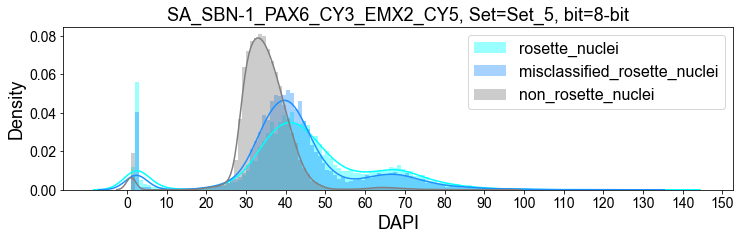

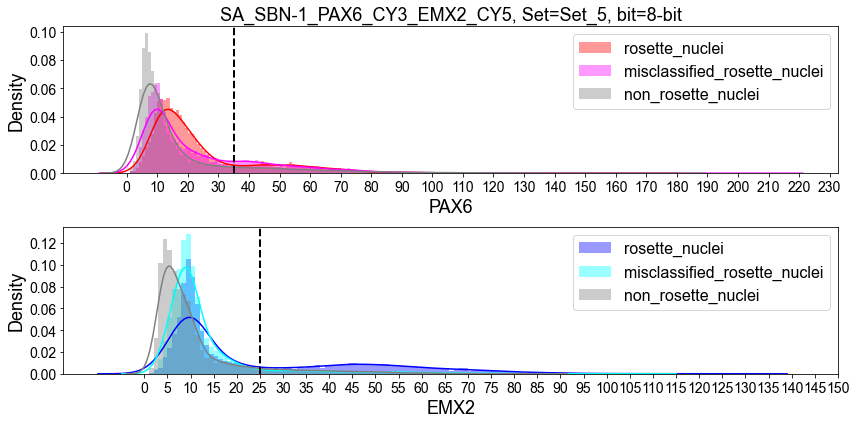

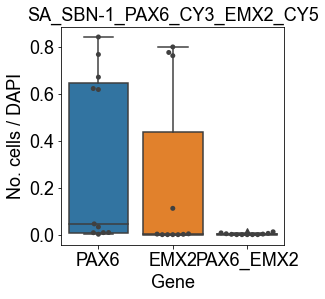

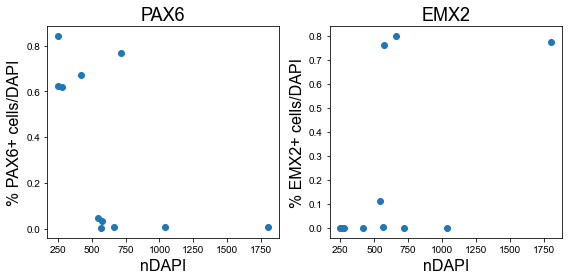

SA_SBN-2_PAX6_CY3_EMX2_CY5


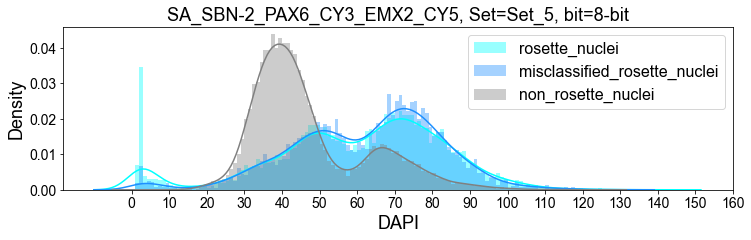

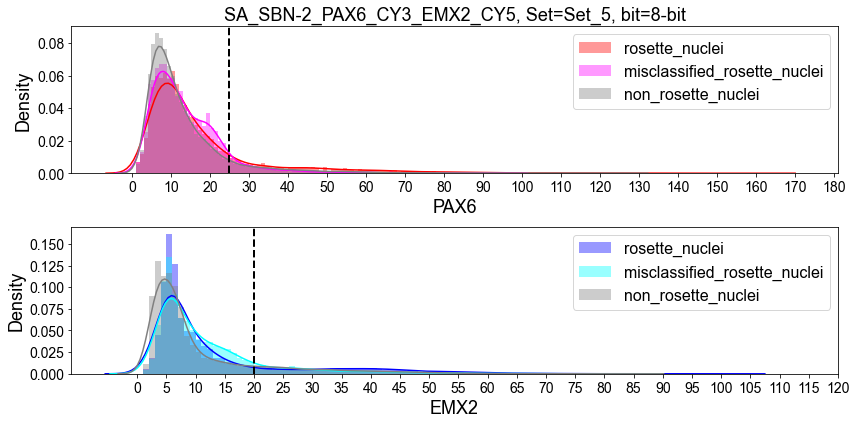

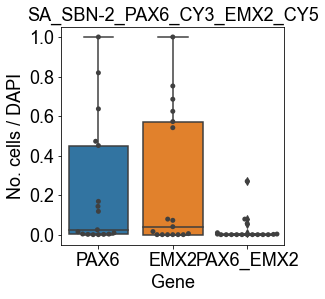

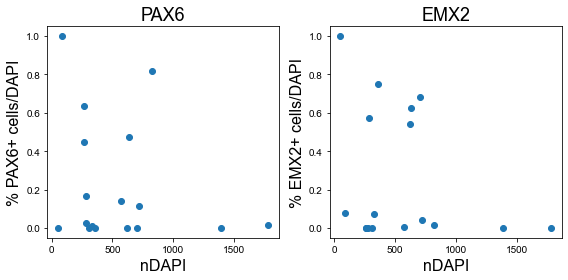

SA_SBN-3_PAX6_CY3_EMX2_CY5


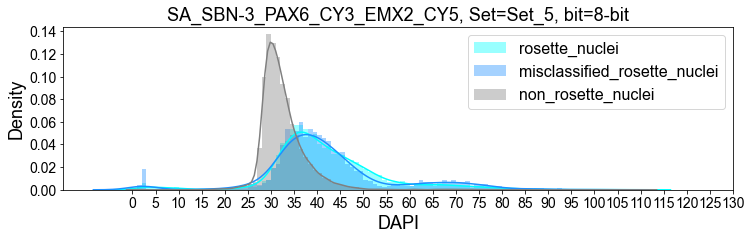

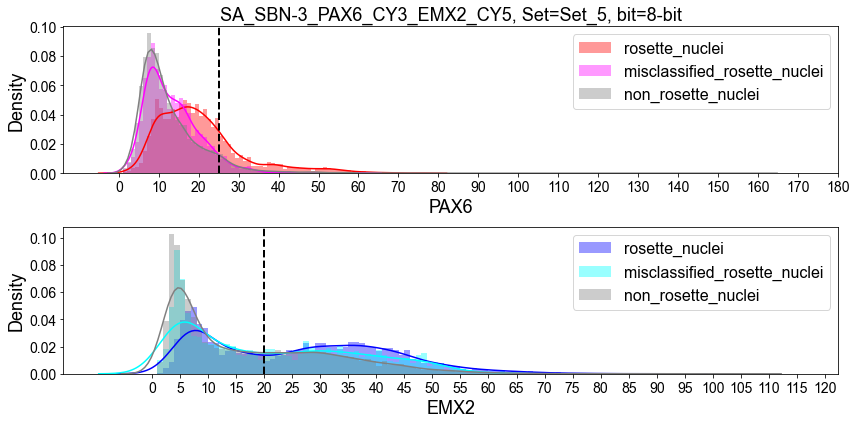

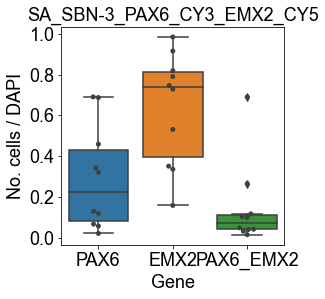

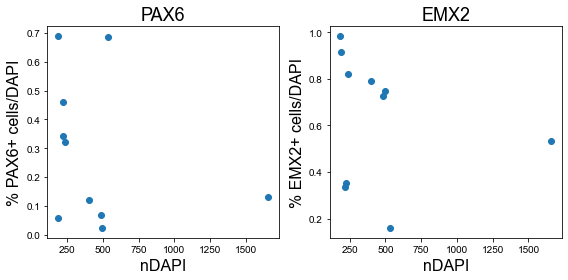

SA_SBNX-1_PAX6_CY3_EMX2_CY5


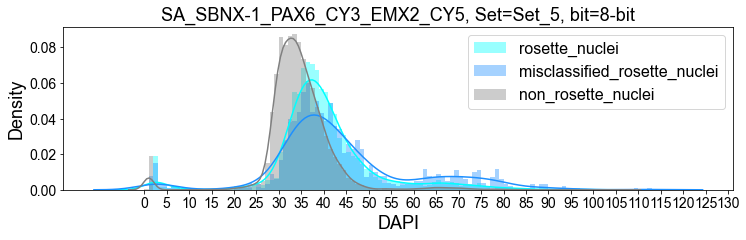

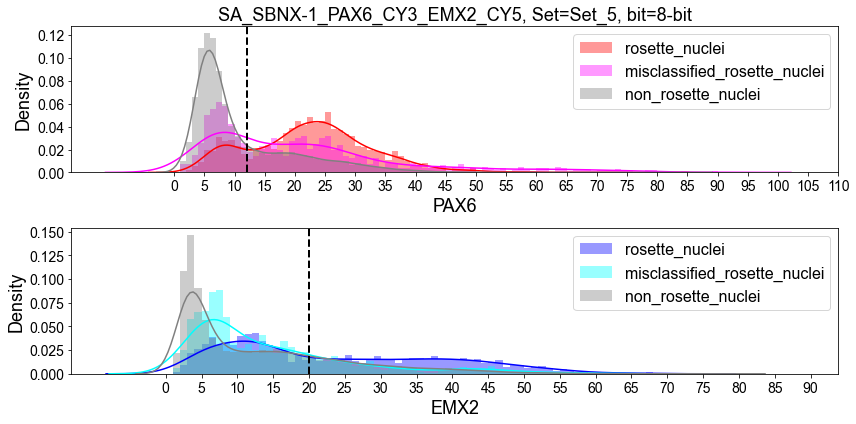

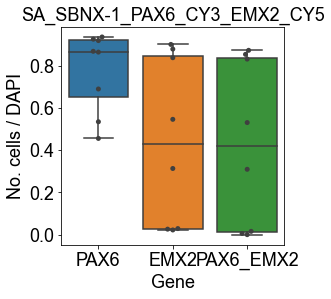

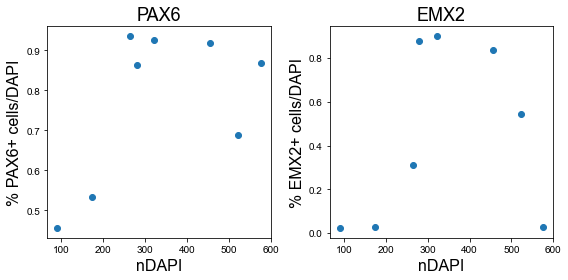

SA_NT-1_PAX6_CY3_EMX2_CY5


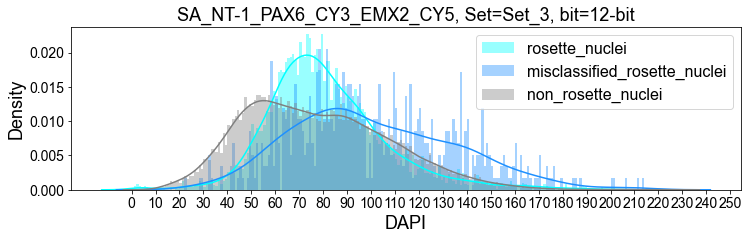

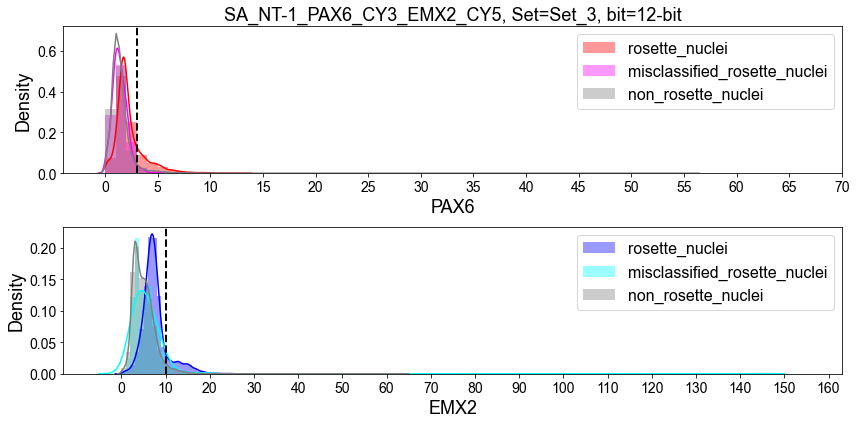

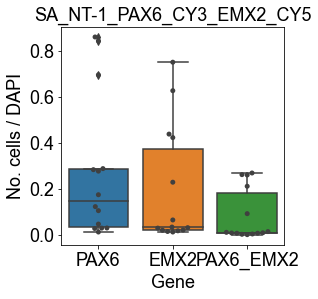

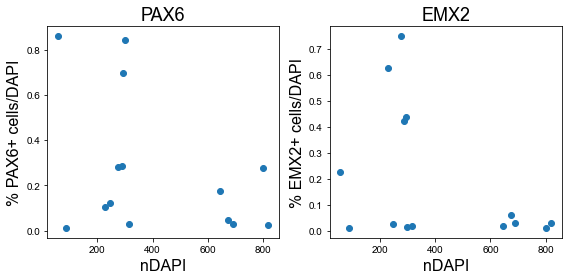

SA_SBNX-1_SOX1_CY3_FOXG1_CY5


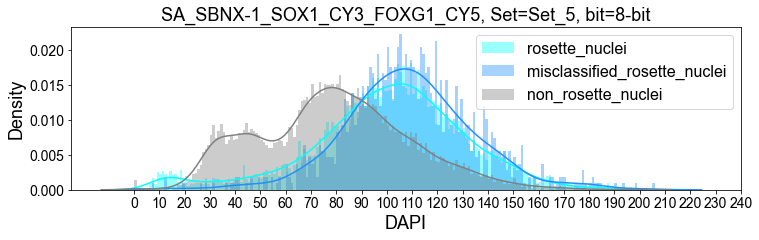

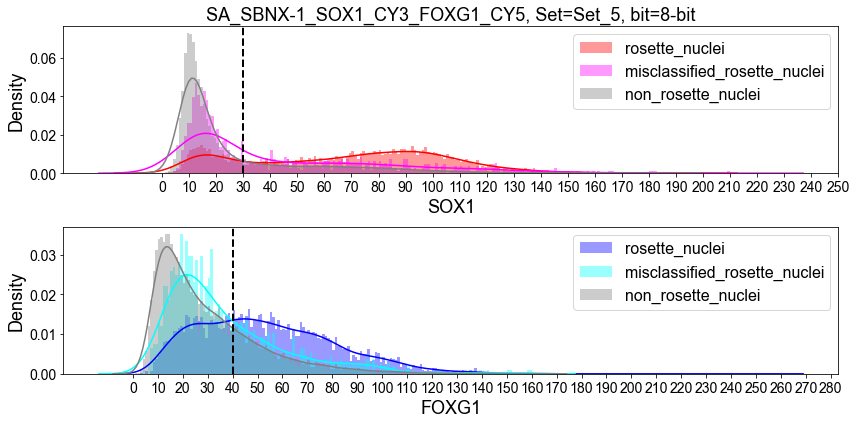

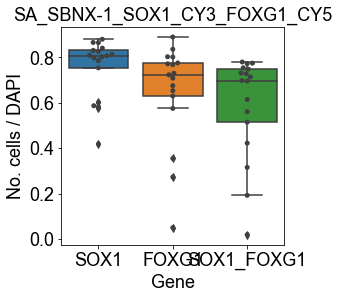

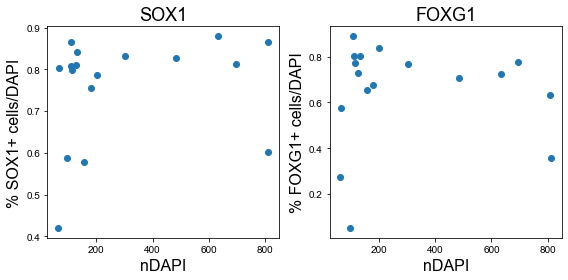

SA_SBN-1_SOX1_CY3_FOXG1_CY5


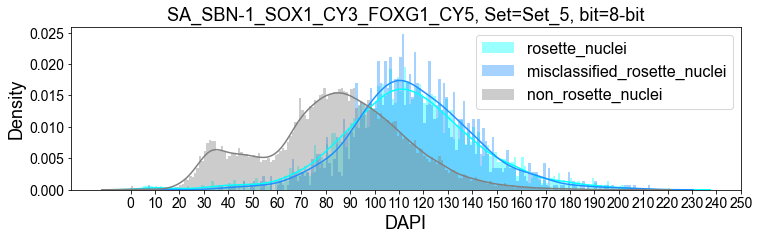

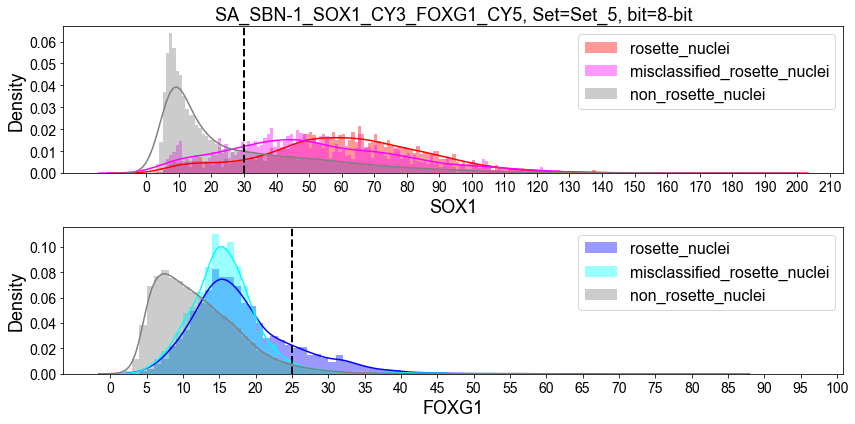

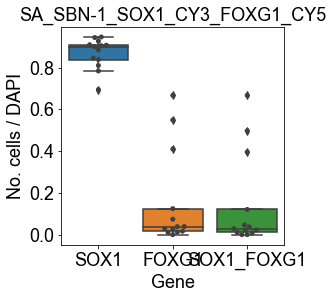

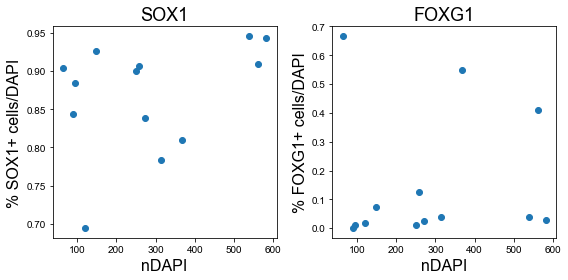

SA_NT-1_SOX1_CY3_FOXG1_CY5


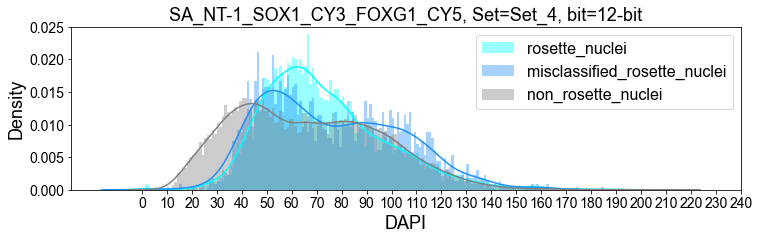

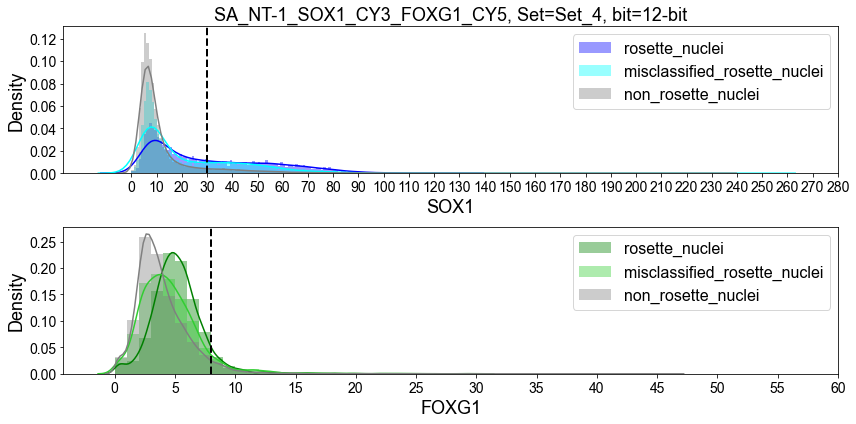

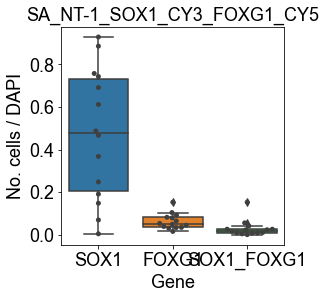

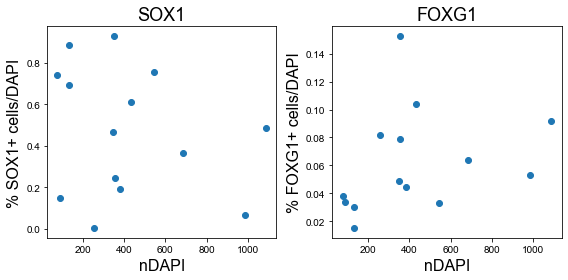

SA_SBN-2_SOX1_CY3_FOXG1_CY5


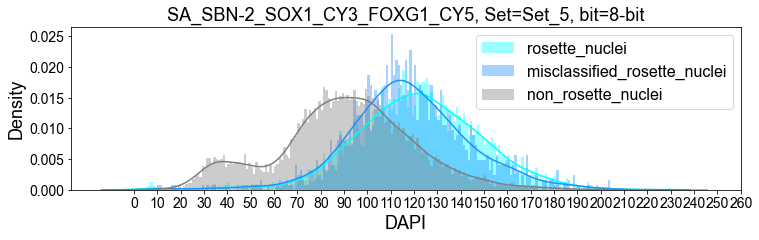

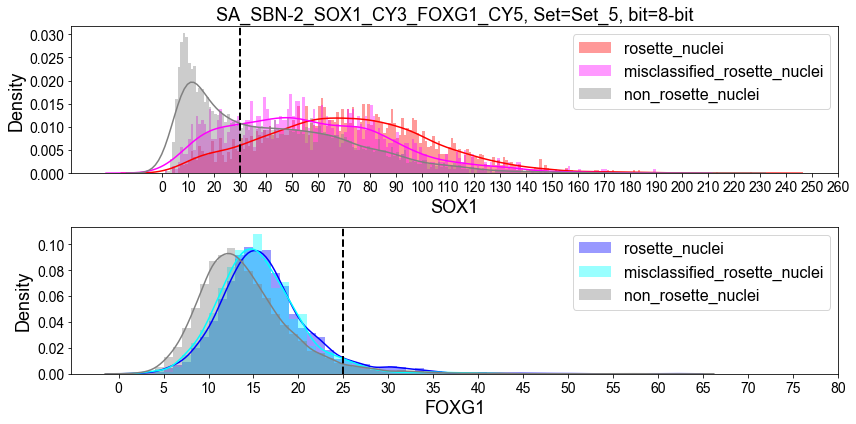

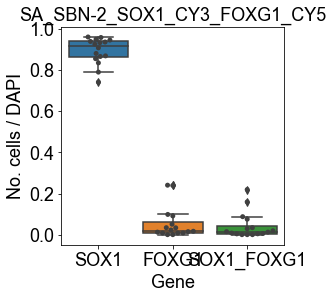

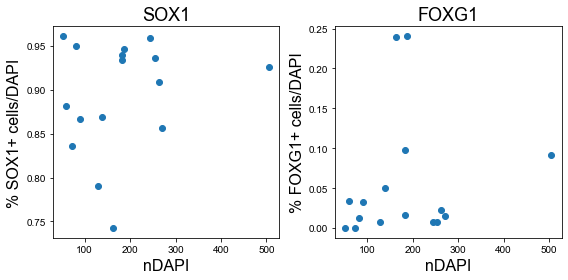

SA_SBNX-2_SOX1_CY3_FOXG1_CY5


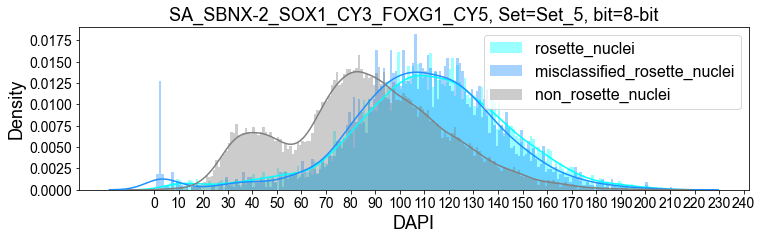

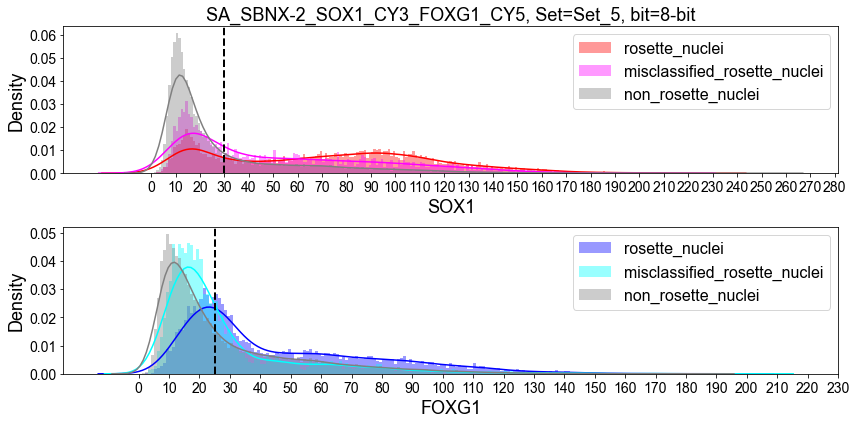

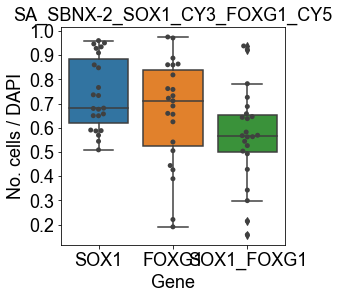

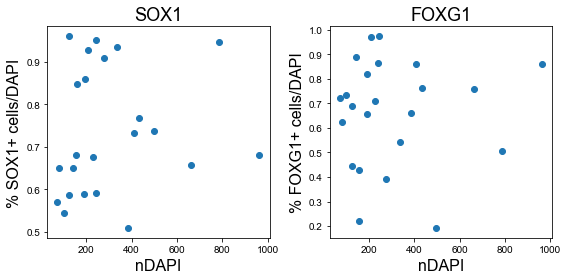

SA_SBN-3_PAX6_CY3_SP8_CY5


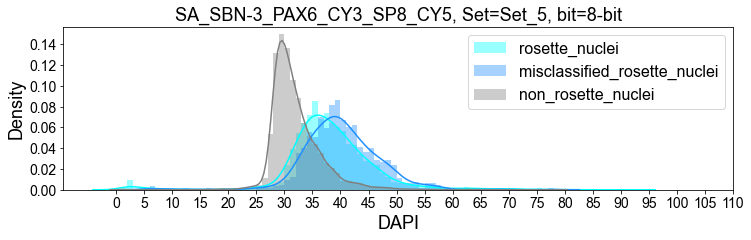

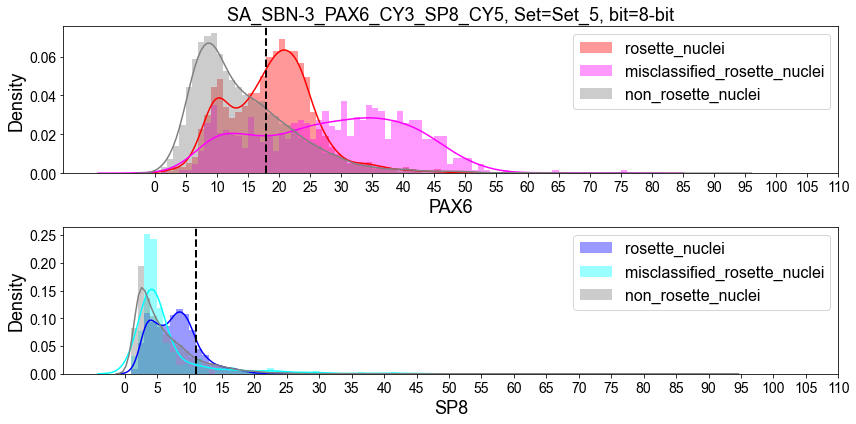

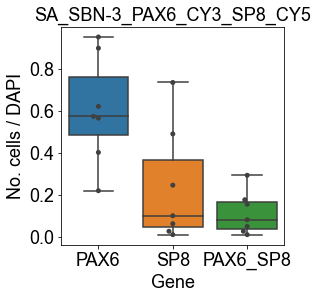

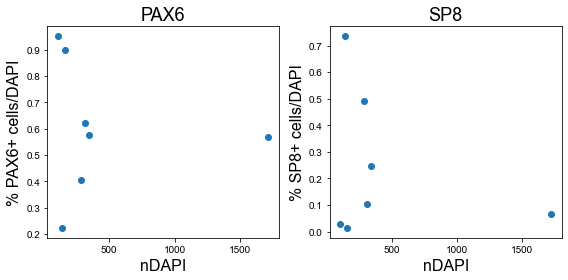

SA_SBN-2_PAX6_CY3_SP8_CY5


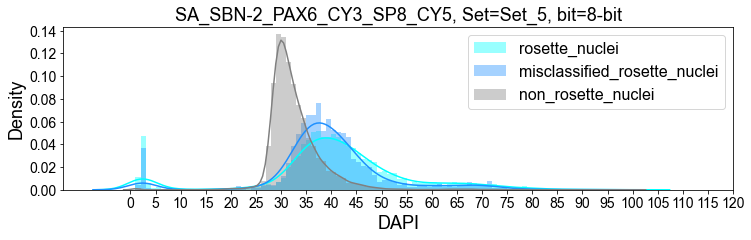

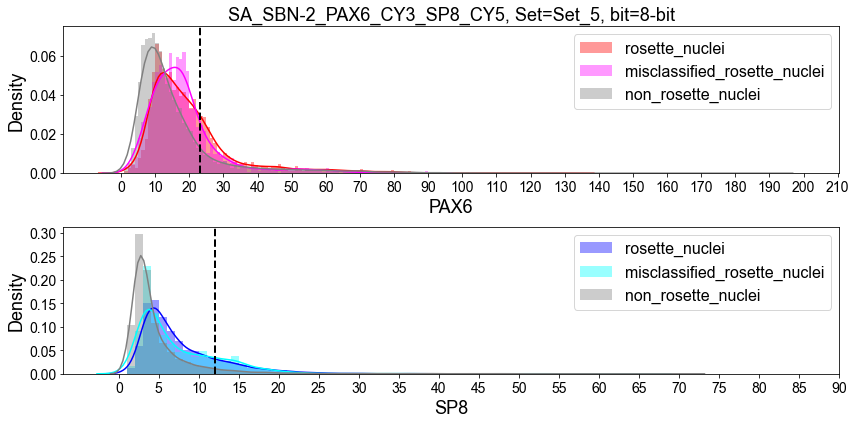

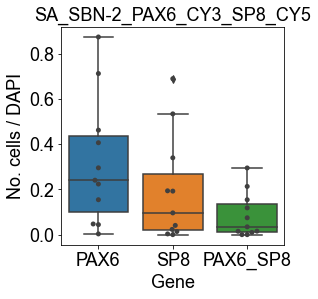

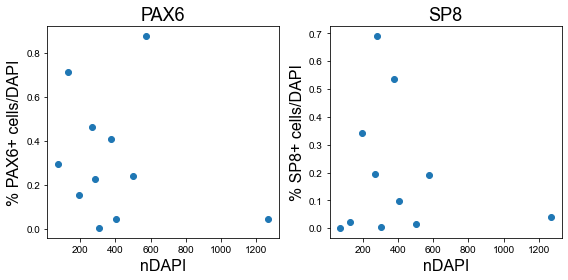

SA_SBN-1_PAX6_CY3_SP8_CY5


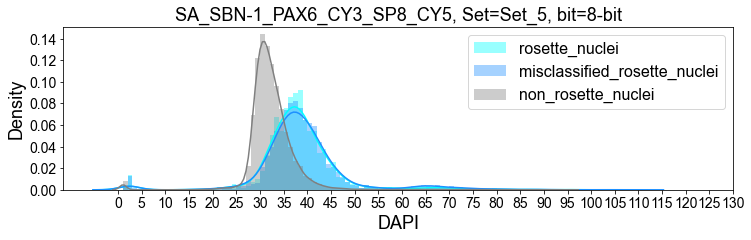

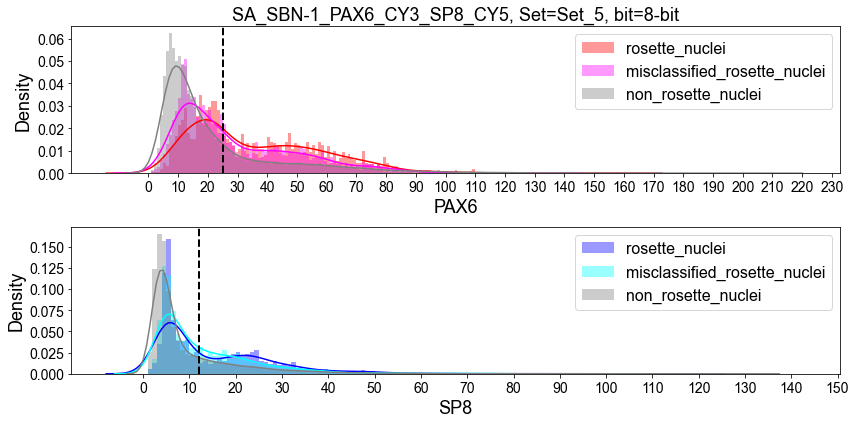

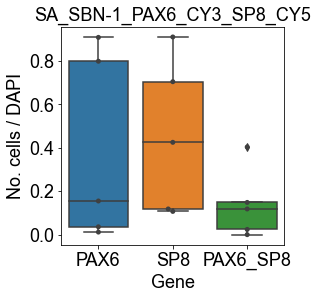

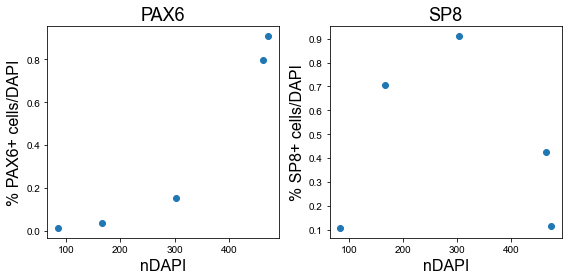

SA_SBNX-2_PAX6_CY3_SP8_CY5


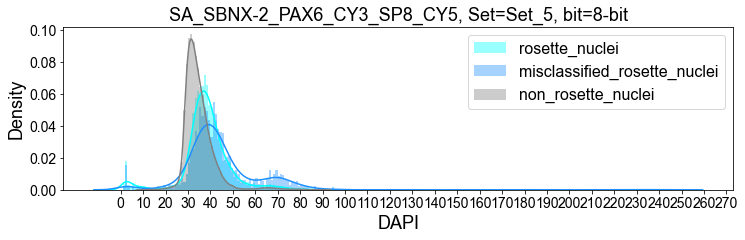

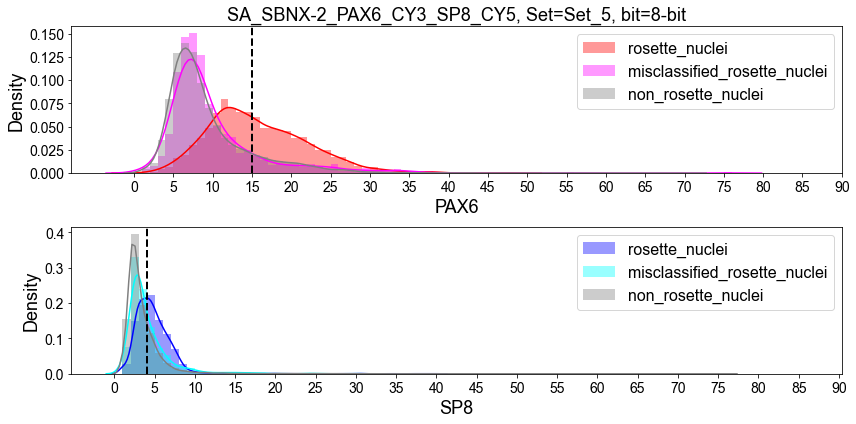

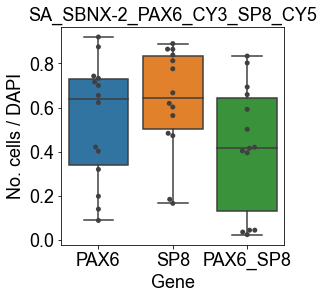

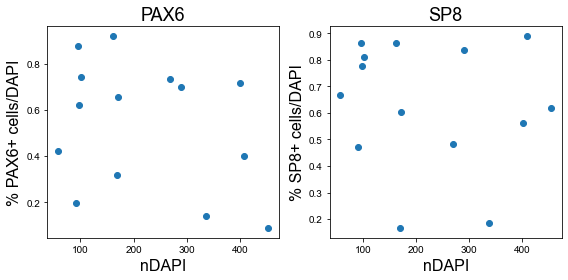

SA_NT-1_PAX6_CY3_SP8_CY5


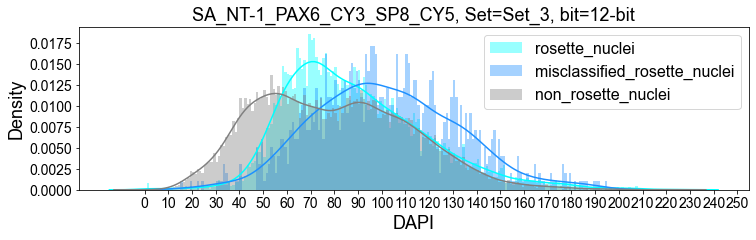

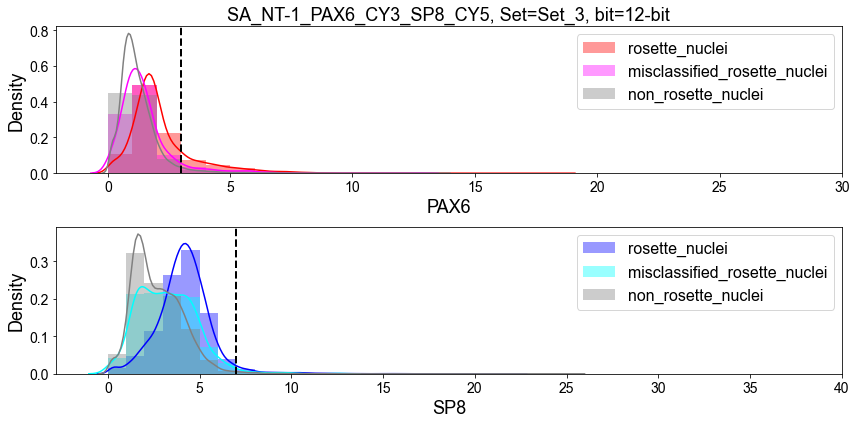

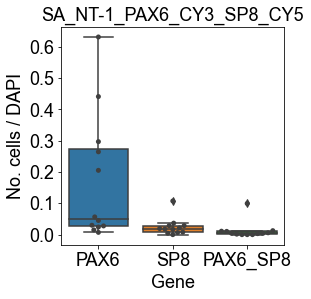

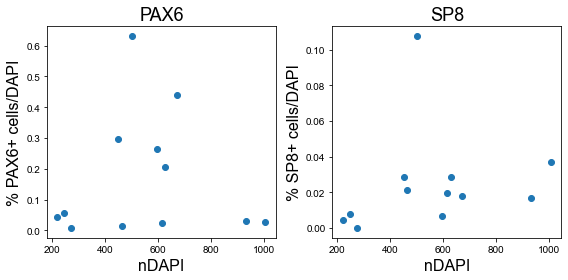

SA_SBNX-1_PAX6_CY3_SP8_CY5


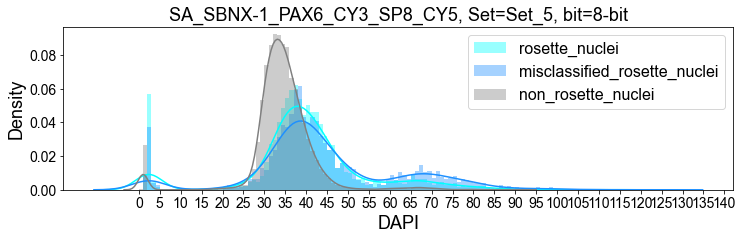

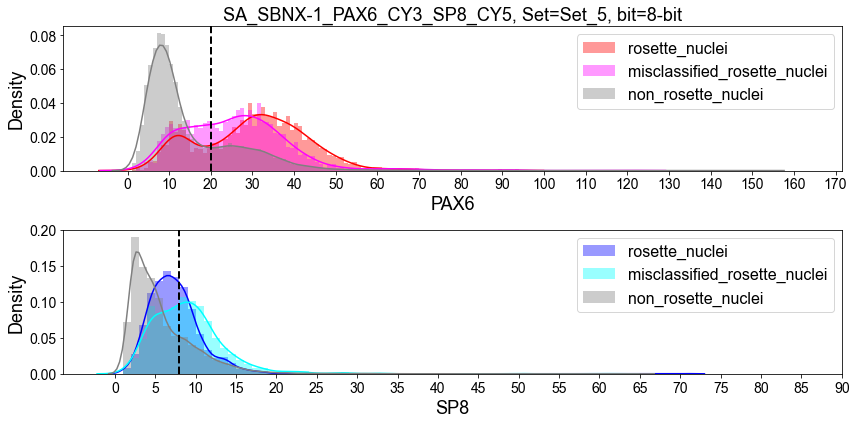

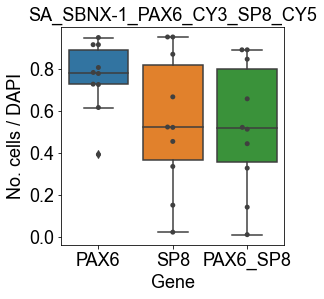

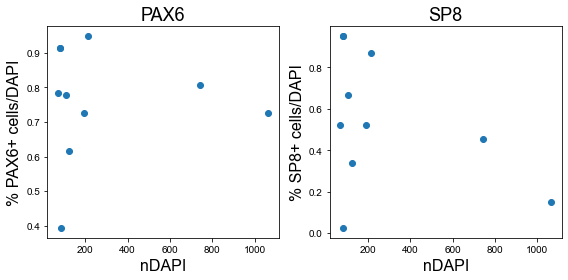

SA_SBNX-3_PAX6_CY3_SP8_CY5


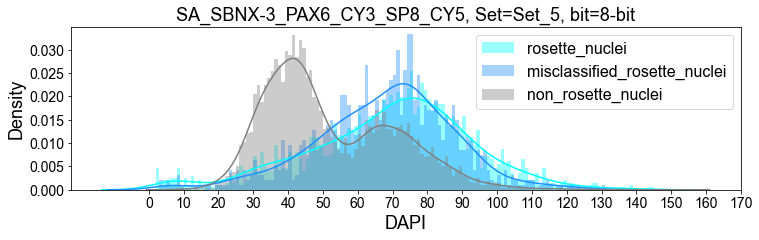

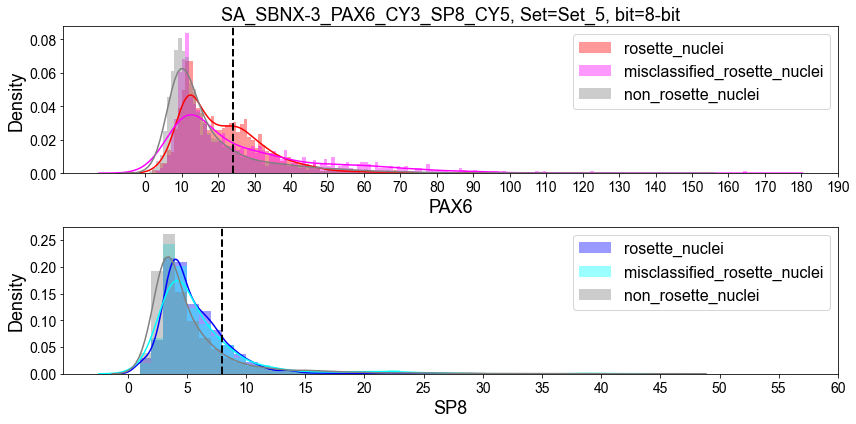

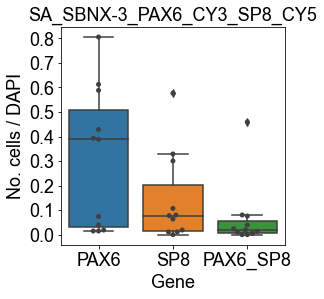

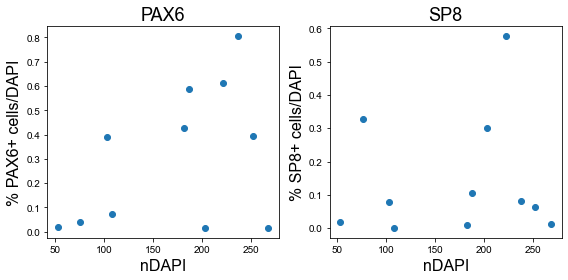

SA_SBN-3_PAX6_CY3_COUPTF1_CY5


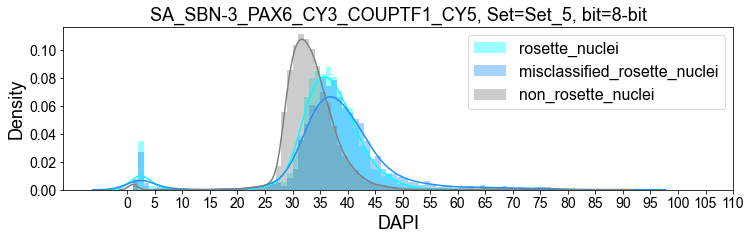

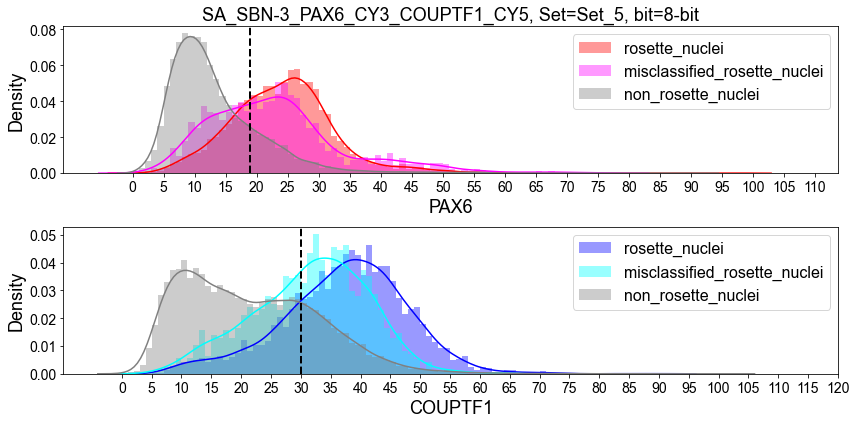

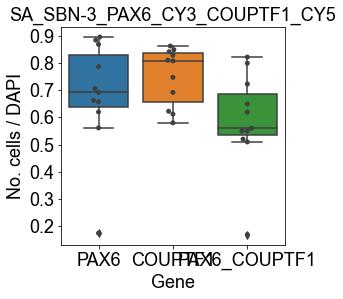

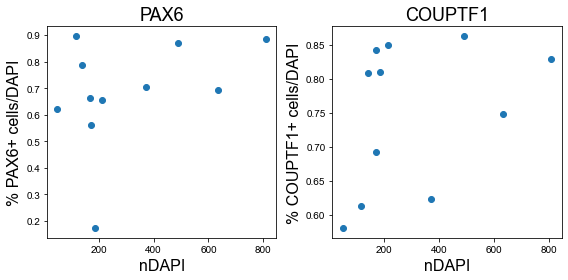

SA_NT-1_PAX6_CY3_COUPTF1_CY5


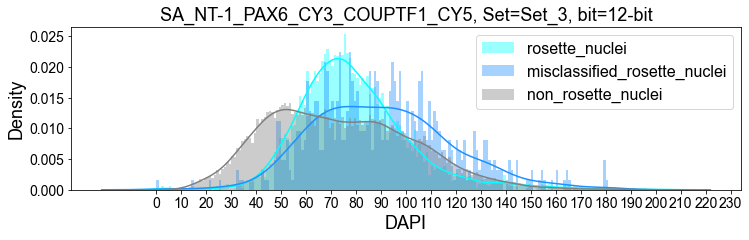

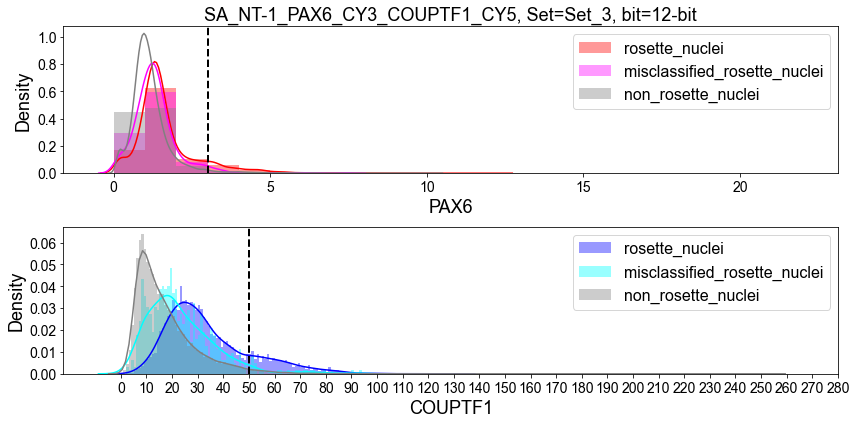

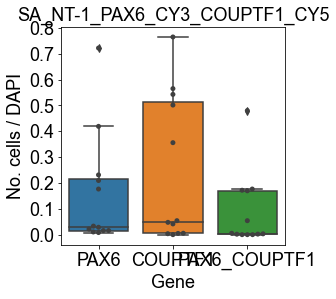

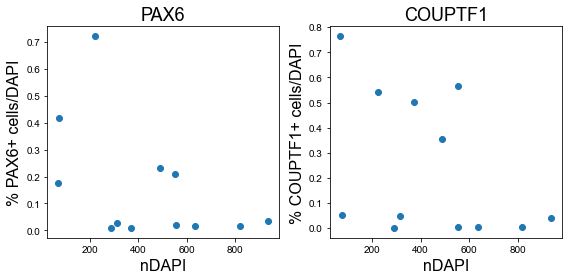

SA_SBNX-3_PAX6_CY3_COUPTF1_CY5


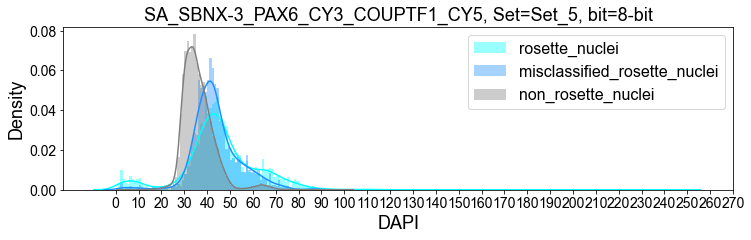

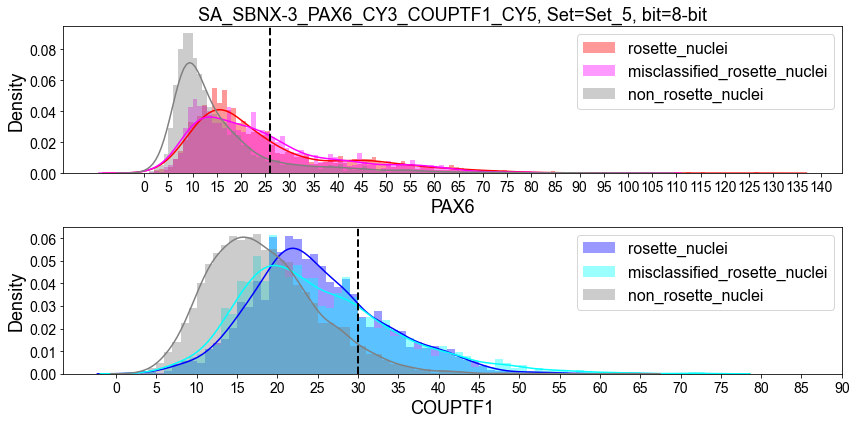

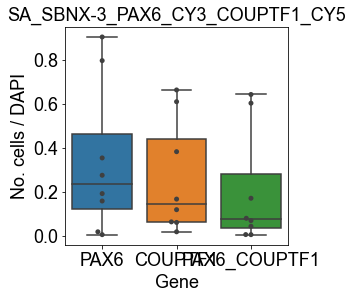

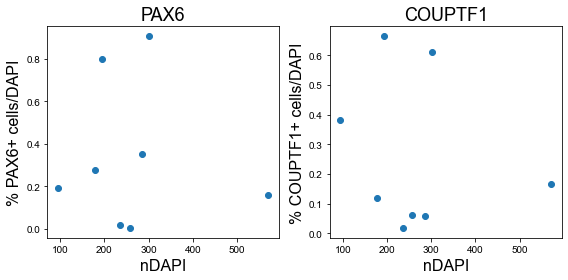

SA_SBNX-1_PAX6_CY3_COUPTF1_CY5


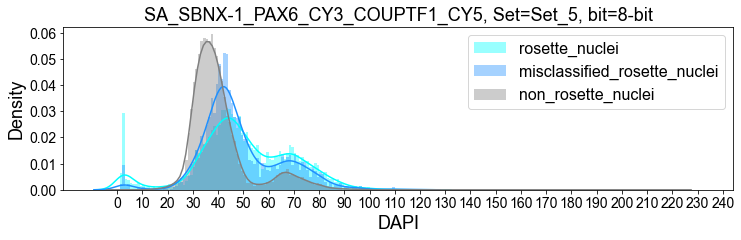

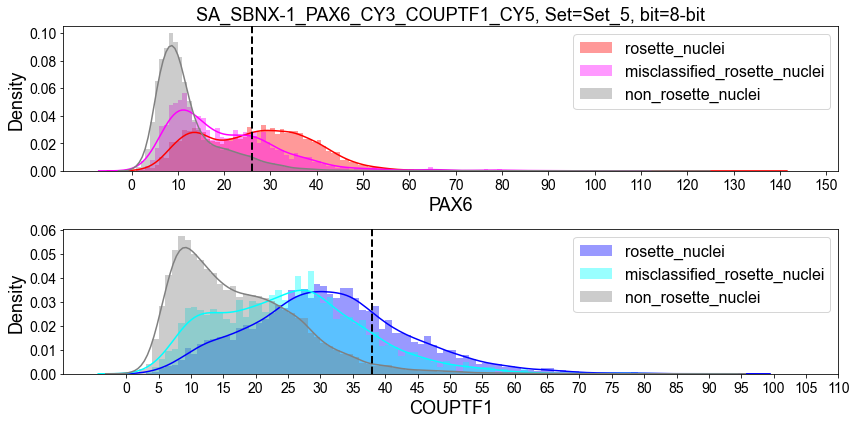

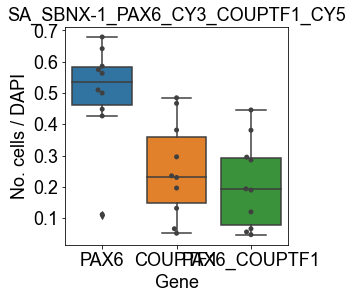

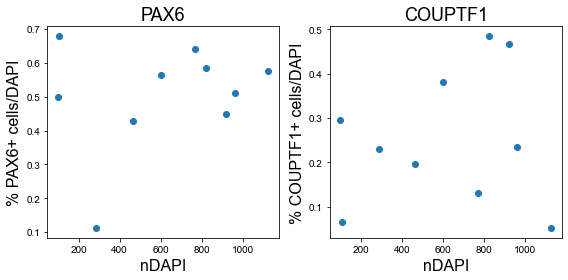

SA_SBN-2_PAX6_CY3_COUPTF1_CY5


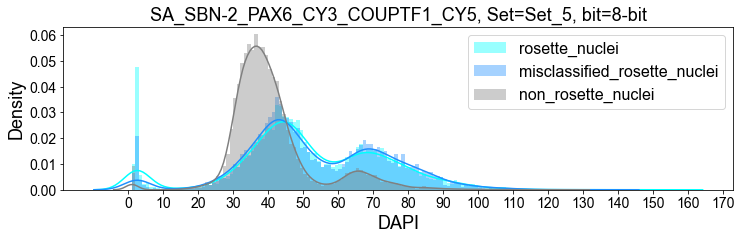

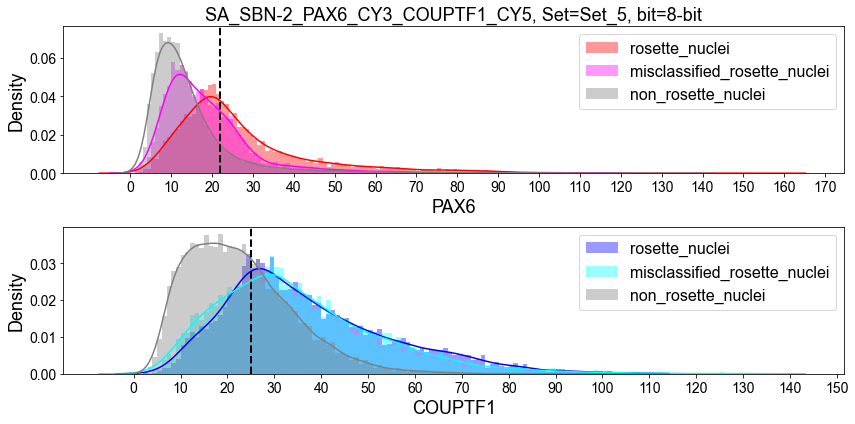

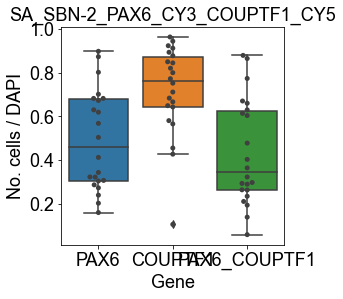

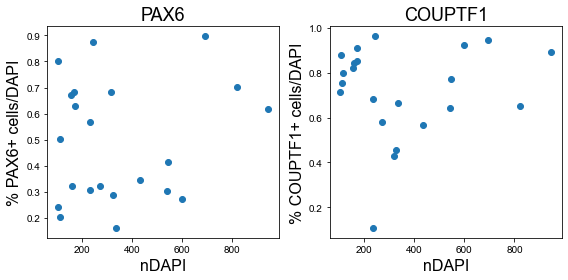

SA_SBN-1_PAX6_CY3_COUPTF1_CY5


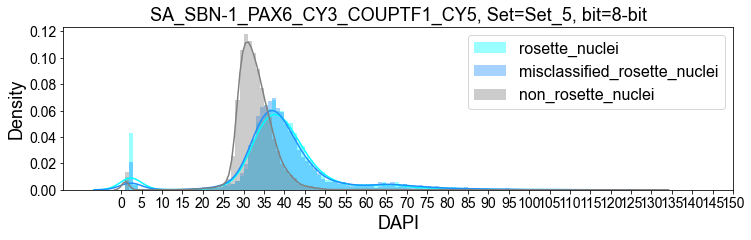

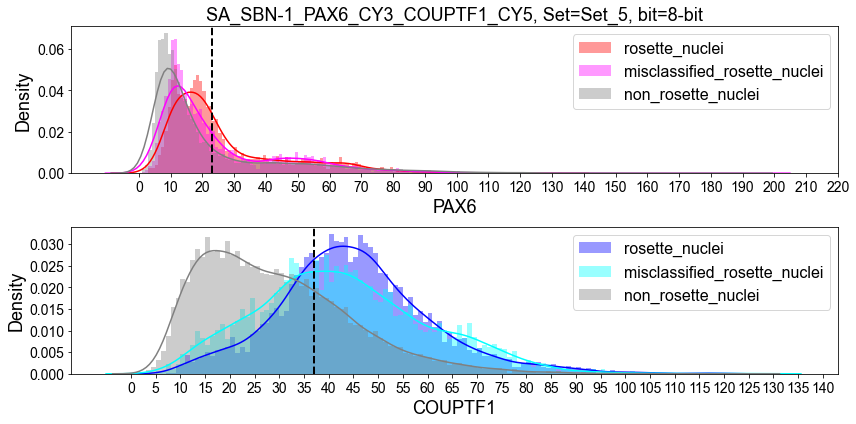

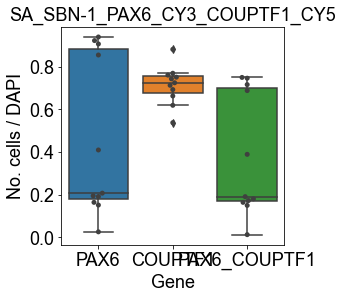

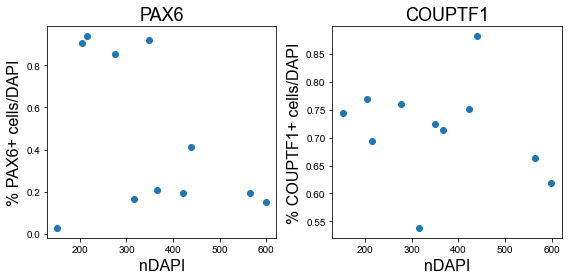

SA_SBNX-2_PAX6_CY3_COUPTF1_CY5


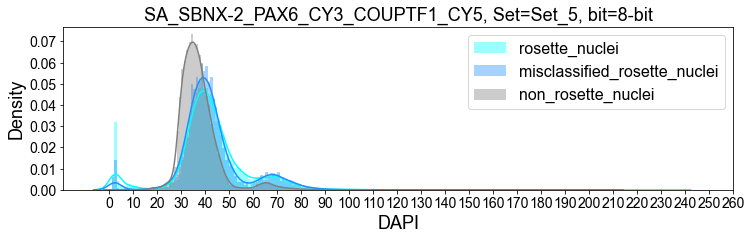

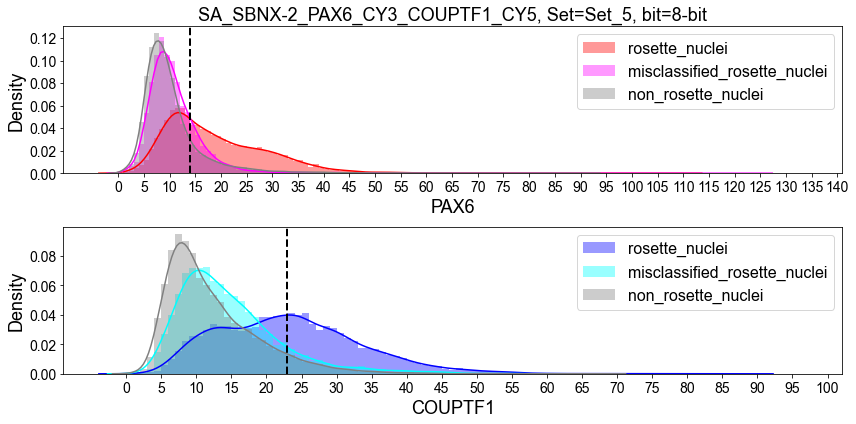

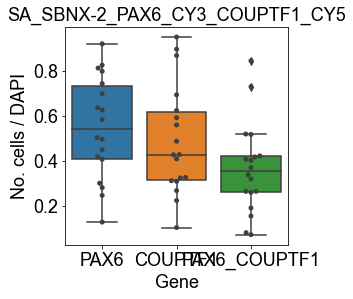

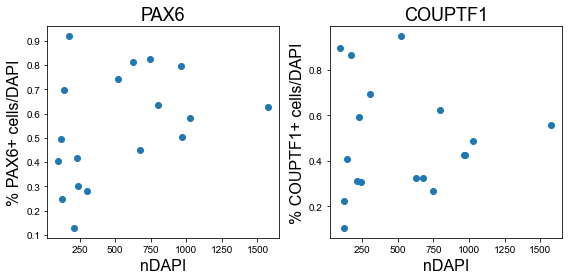

SA_SBN-1_OLIG3_488_TCF7L2_CY3_DCX_CY5


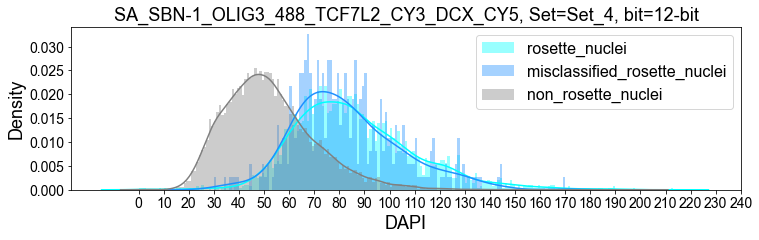

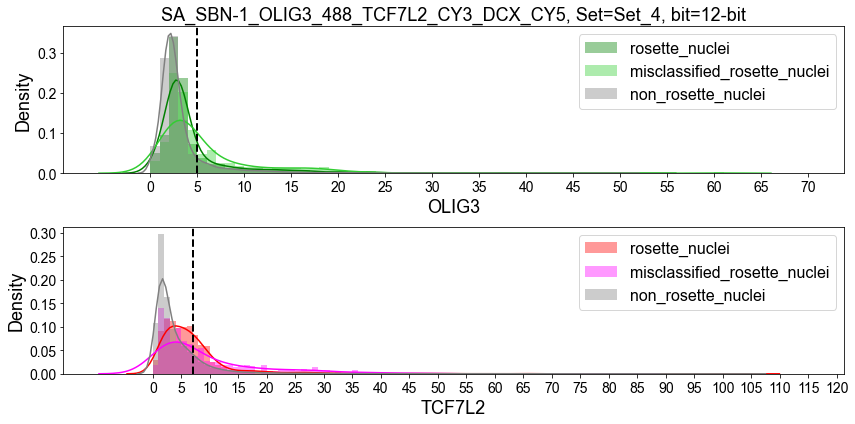

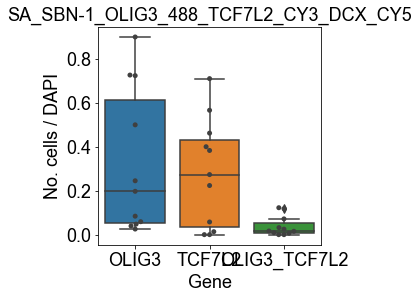

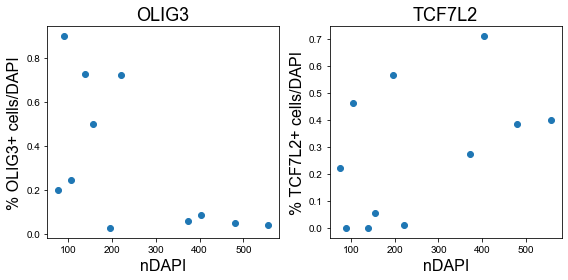

SA_NT-1_OLIG3_488_TCF7L2_CY3_DCX_CY5


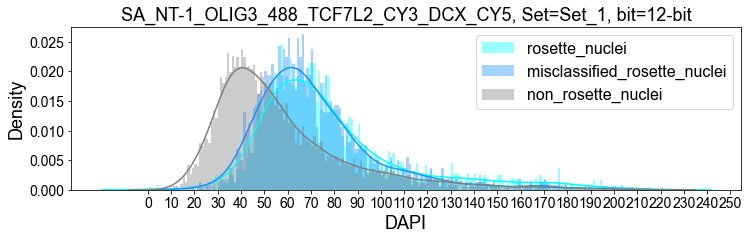

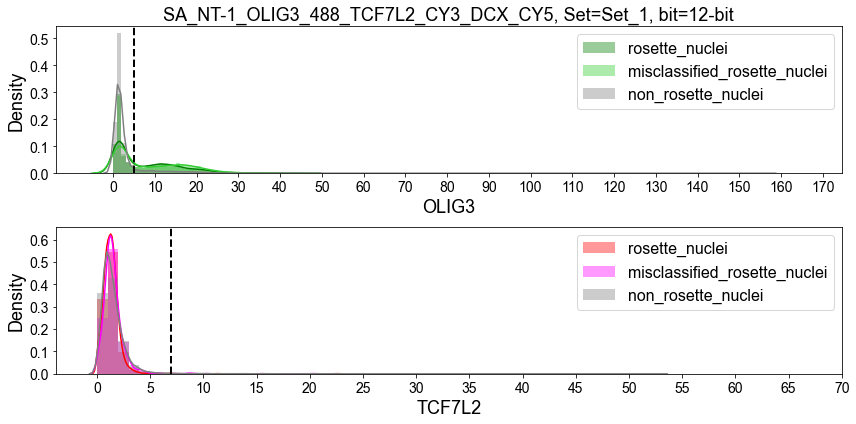

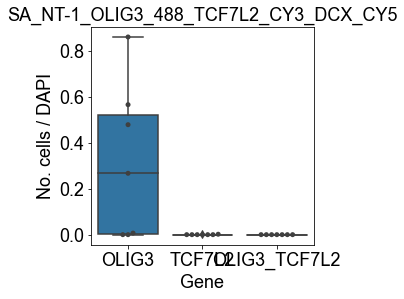

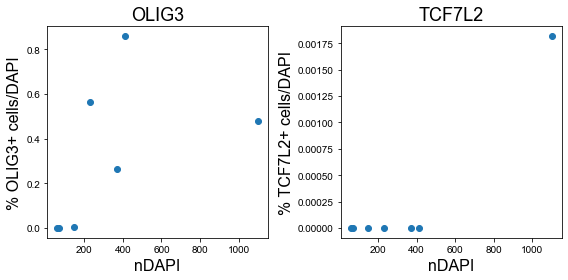

SA_SBNX_OLIG3_488_TCF7L2_CY3_DCX_CY5


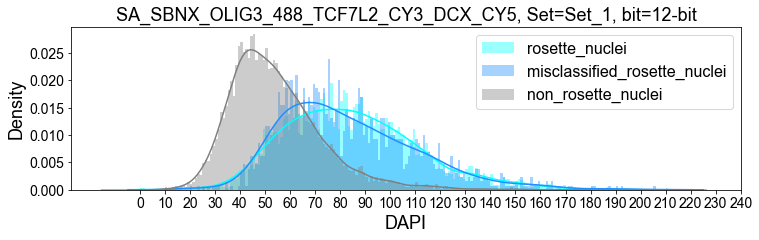

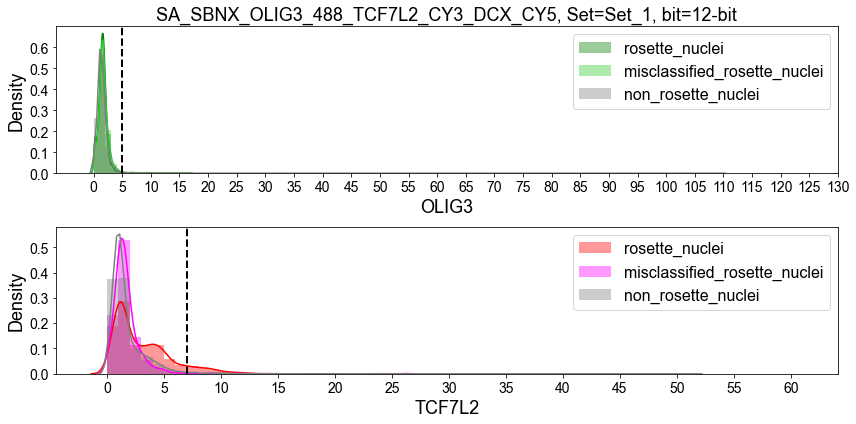

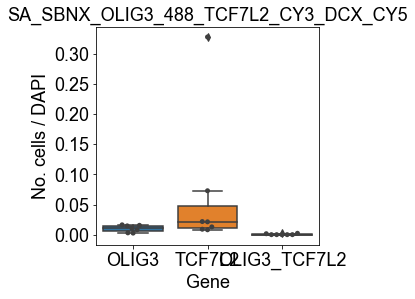

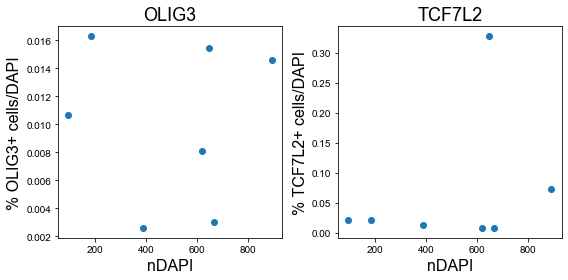

SA_SBN-1_SOX2_488_MEF2C_CY3_DCX_CY5


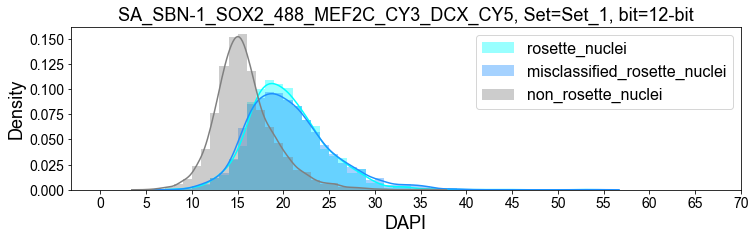

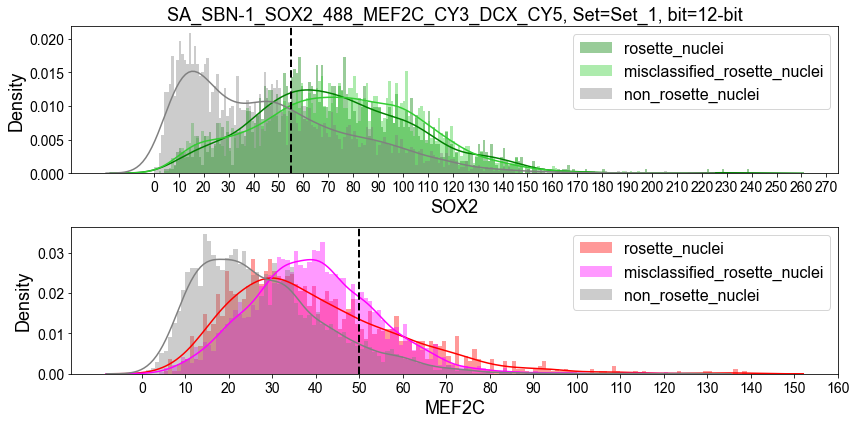

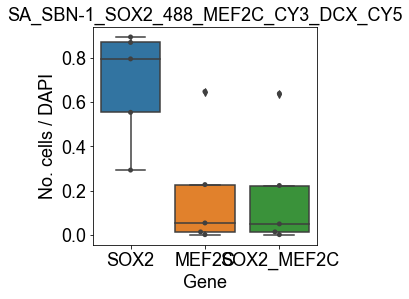

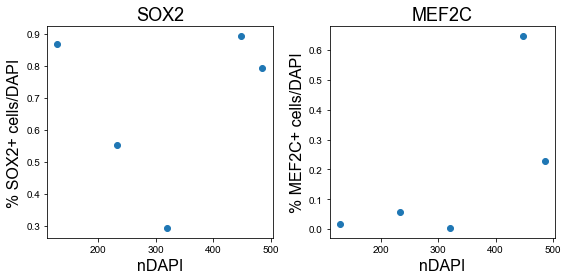

SA_SBN-2_SOX2_488_MEF2C_CY3_DCX_CY5


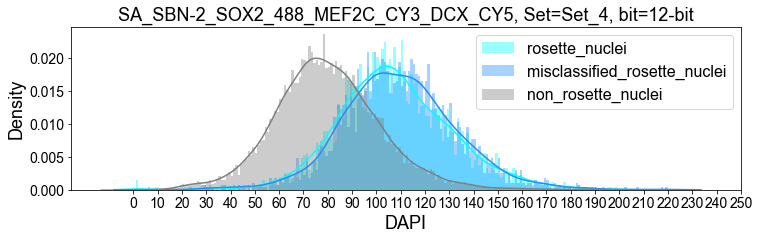

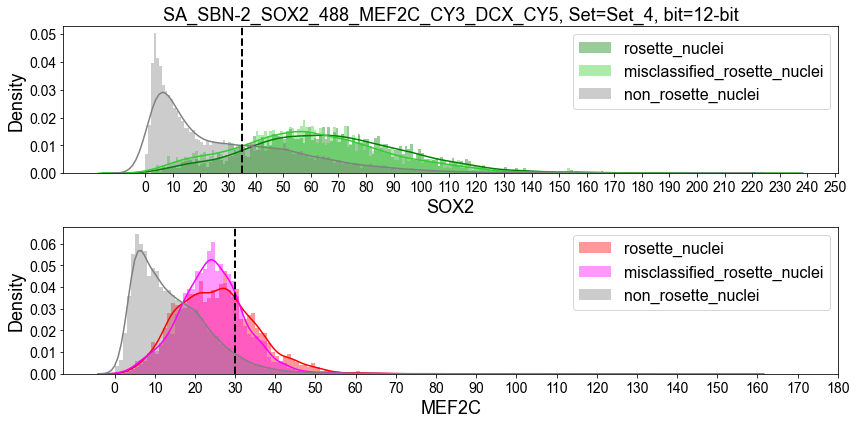

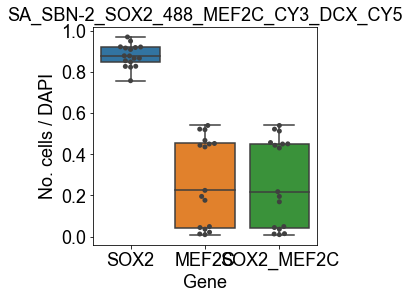

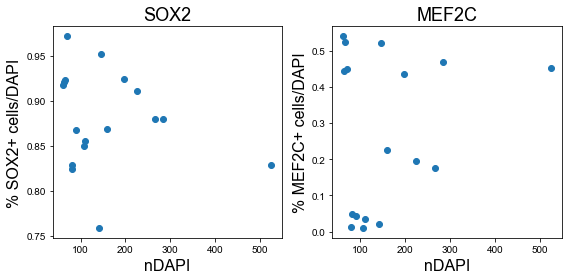

SA_SBNX-2_SOX2_488_MEF2C_CY3_DCX_CY5


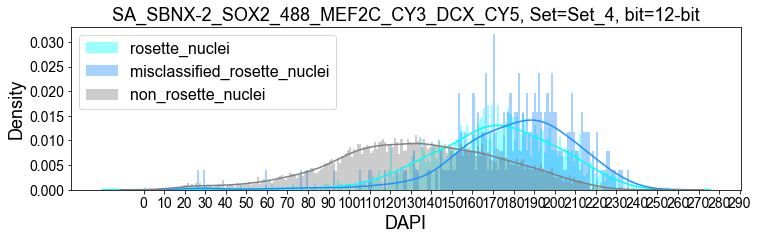

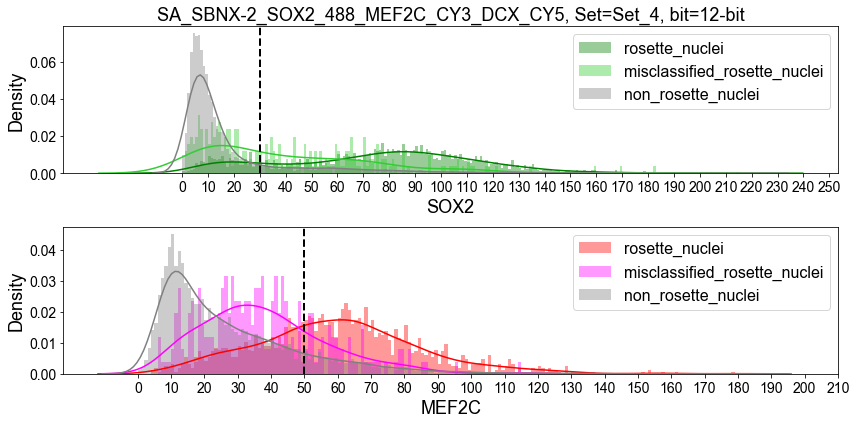

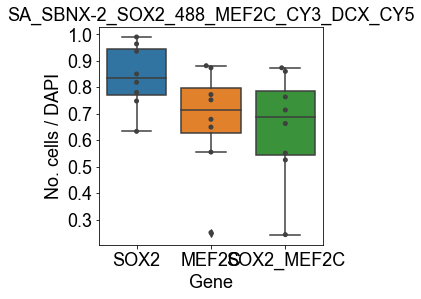

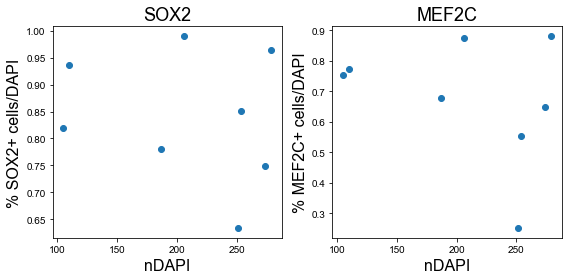

SA_SBNX-1_SOX2_488_MEF2C_CY3_DCX_CY5


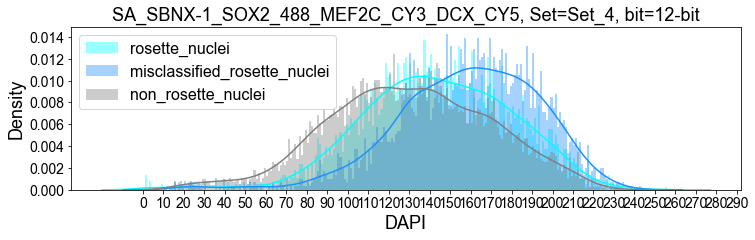

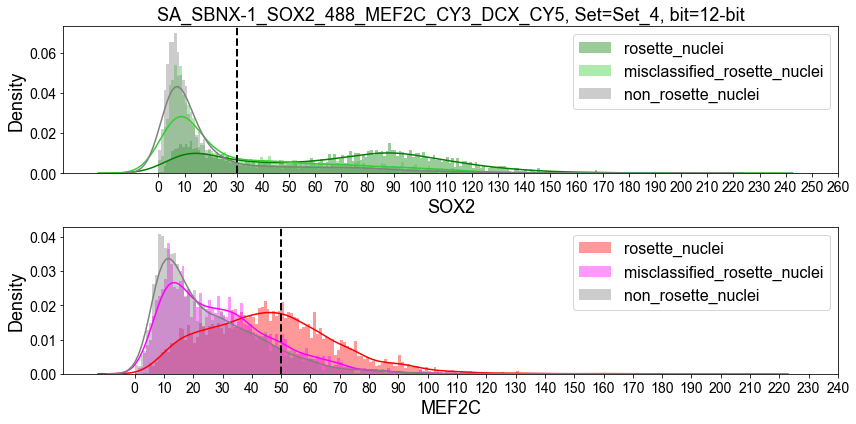

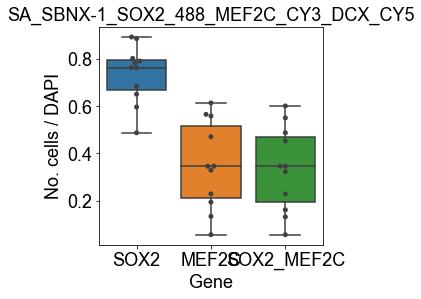

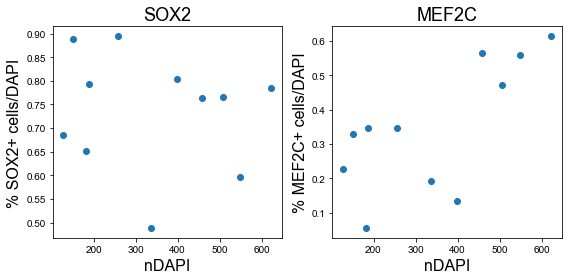

analyzedX20_O2_NT_488_SOX2_CY3_MEF2C_CY5_DCX_organoid 2_MIP_19_02_2019


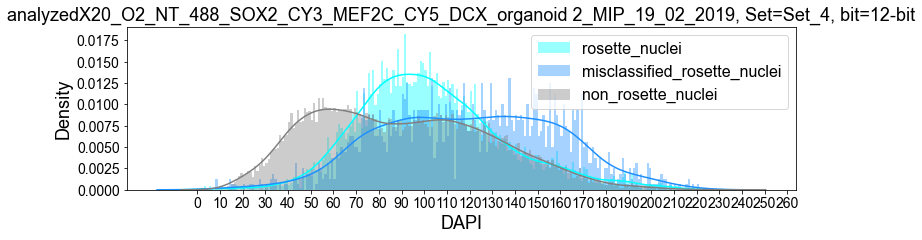

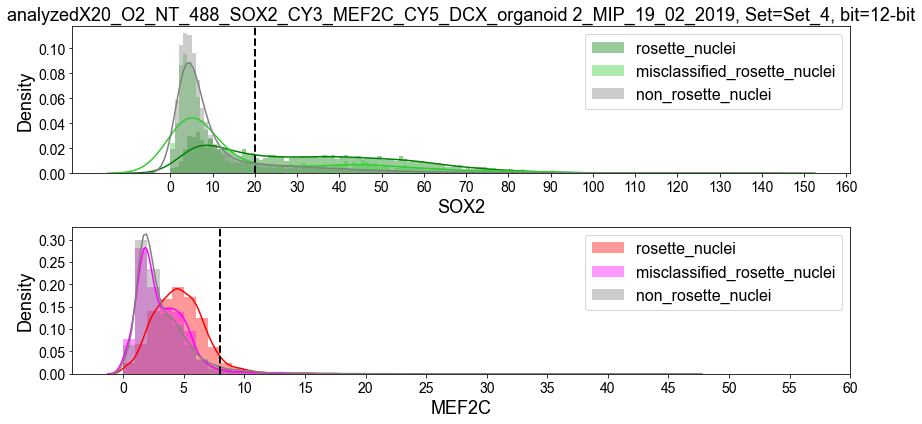

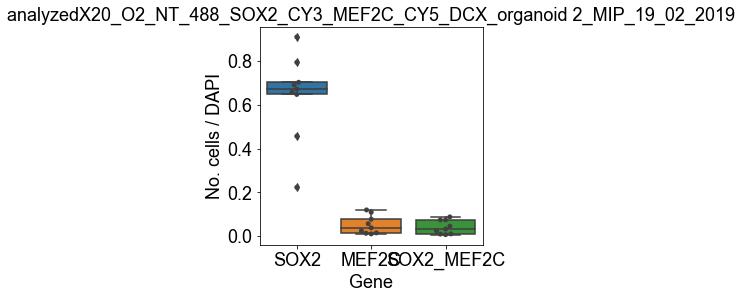

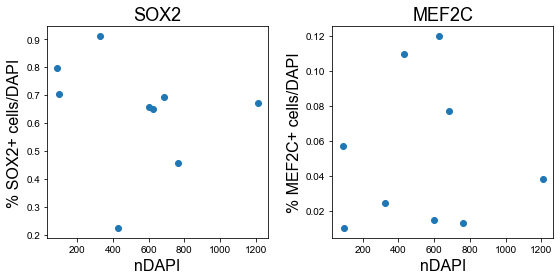

SA_SBN-1_ATOH1_488_LMX1A_CY3_TTR_CY5


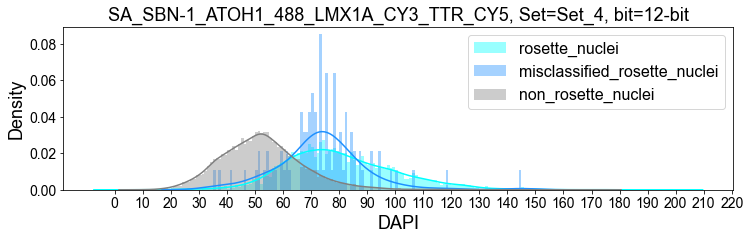

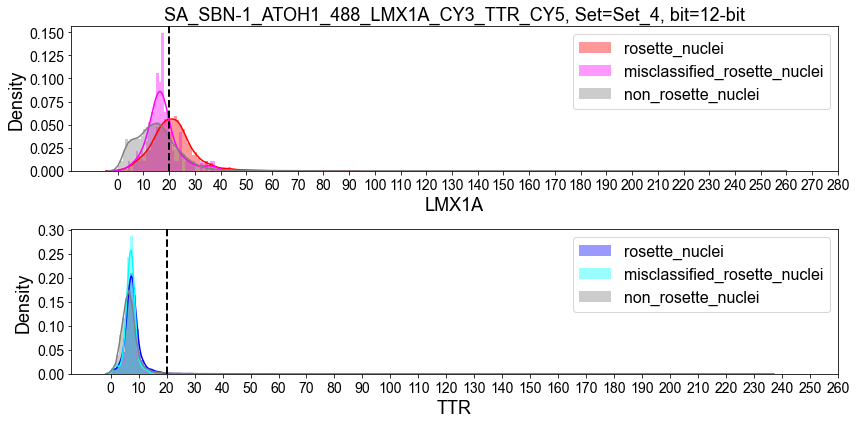

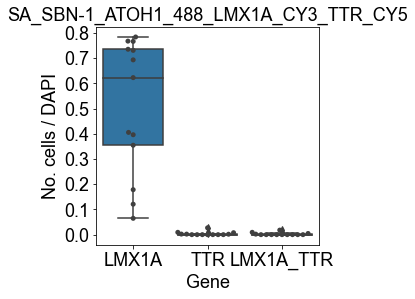

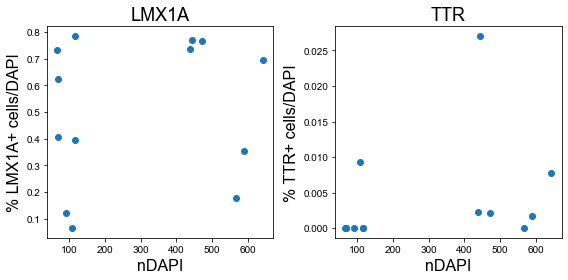

SA_NT-1_ATOH1_488_LMX1A_CY3_TTR_CY5


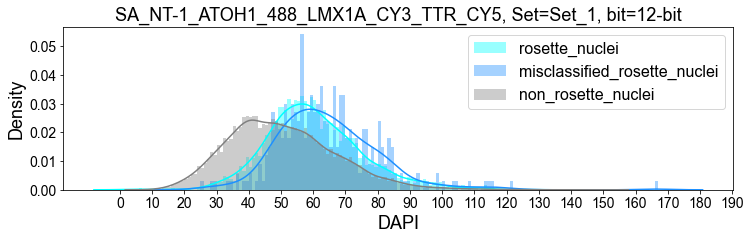

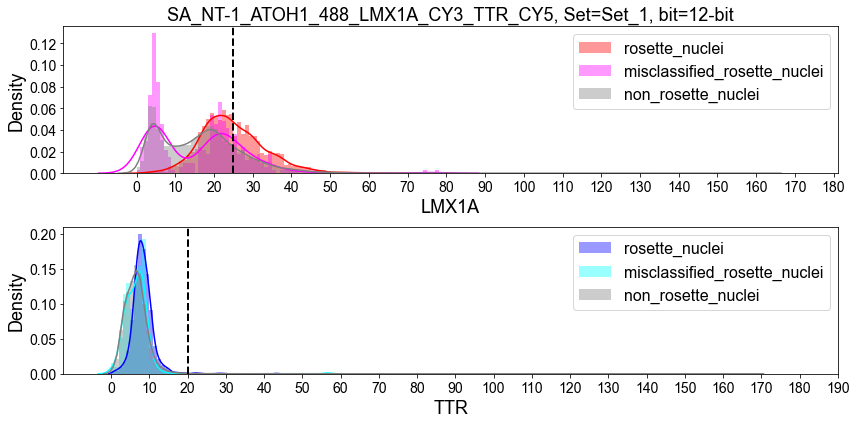

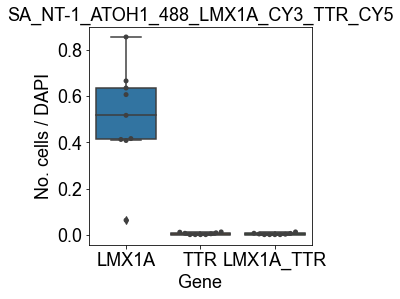

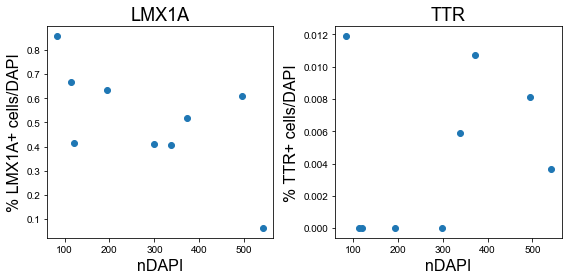

SA_SBNX-1_ATOH1_488_LMX1A_CY3_TTR_CY5


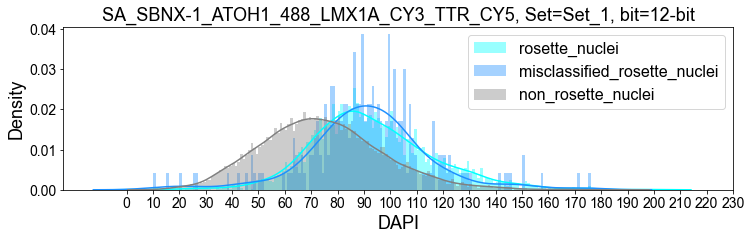

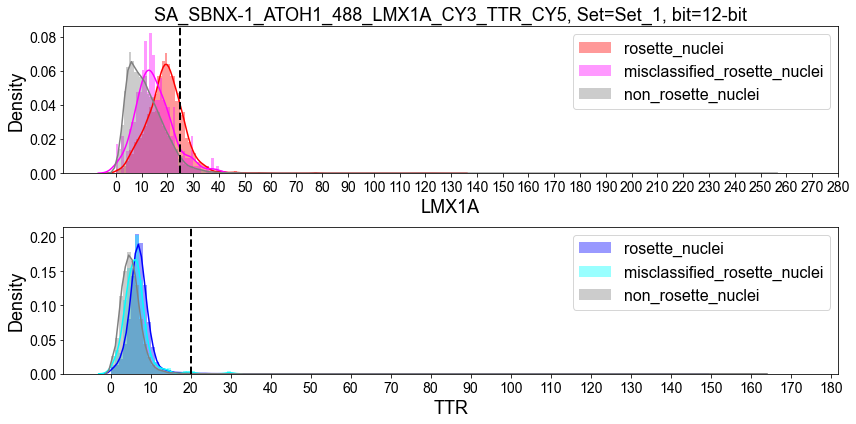

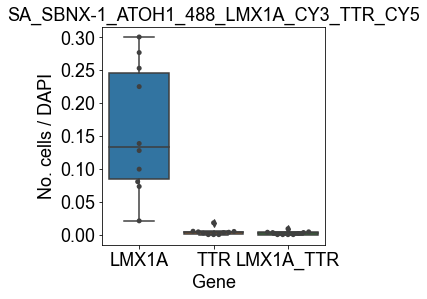

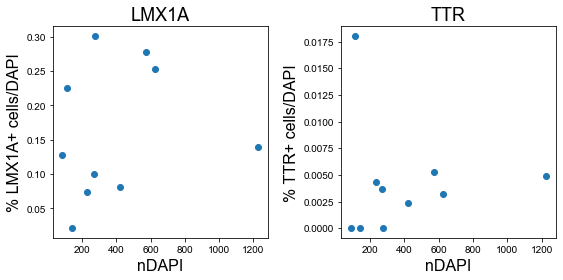

zip8k8_orgn17_d30_emx1_647_pax6_546_dapi 2


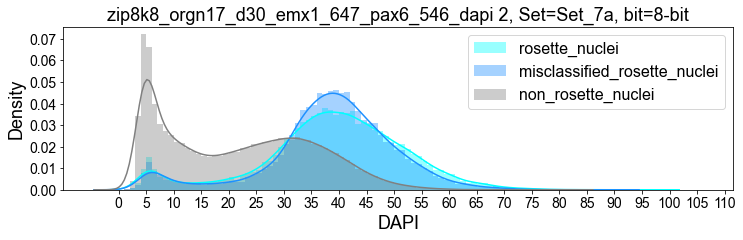

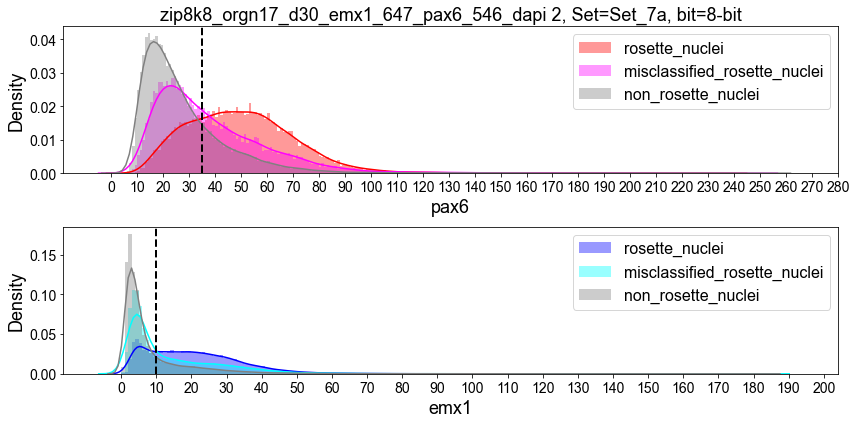

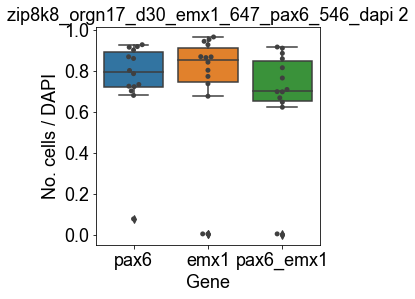

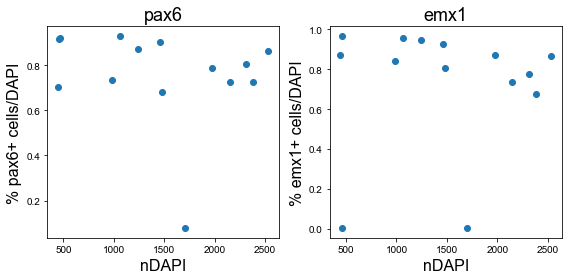

zip8k8_orgn17_d30_emx1_647_pax6_546_dap airyscan


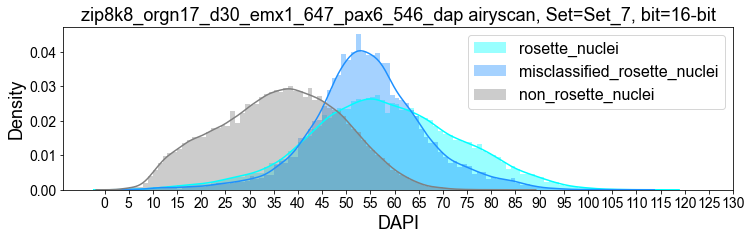

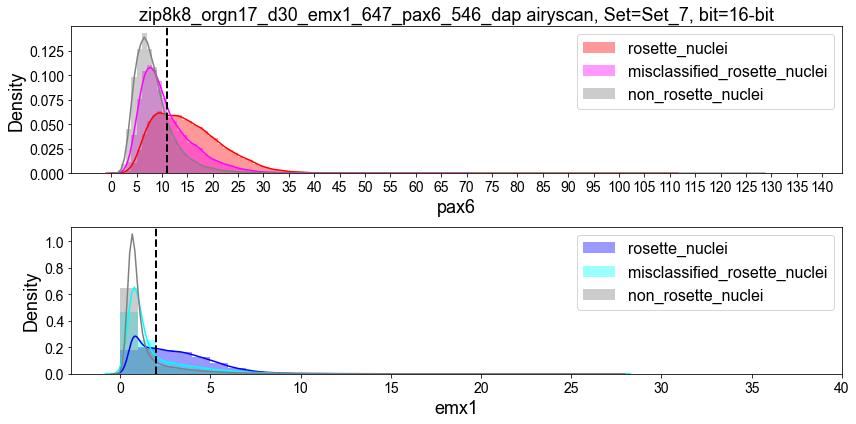

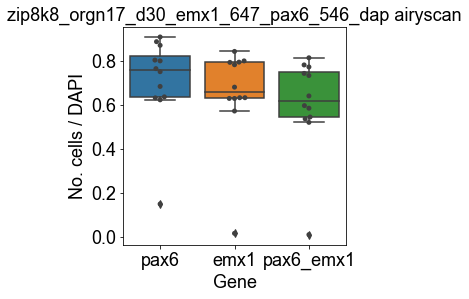

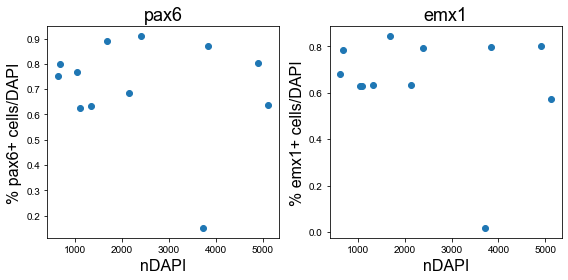

In [25]:
meta_dat = pd.read_csv('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/D30_countings_from_Rene/data/meta_data_rosette_objects_and_sets.tsv',sep='\t',index_col=0)

for gene1,gene2 in zip(['PAX6','SOX1','PAX6','PAX6','OLIG3','SOX2','LMX1A','pax6'],
                       ['EMX2','FOXG1','SP8','COUPTF1','TCF7L2','MEF2C','TTR','emx1']):

    genes = [gene1,gene2]
    #if genes != ['PAX6','SP8']: continue
    for sample in list(set(meta_dat.index)):

        if gene1 not in sample:
            continue
        if gene2 not in sample:
            continue
        if 'HES5' in sample:
            continue

        gene_pair = frozenset([gene1,gene2])

        print(sample)
        set_id, rosettes = read_in_metadata_for_samp(meta_dat,sample)
        df_dict = get_dataframes_from_samp(sample)
        rosette_id_map = build_rosette_id_mapping(df_dict)
        rosette_mask_ids,tot_rosette_mask_ids,non_rosette_mask_ids = get_rosette_and_non_rosette_mask_ids(df_dict,rosettes,rosette_id_map)

        gene_channel_dict_r,gene_channel_dict,gene_color_dict = get_gene_to_color_map(set_id,sample)
        
        df_dict_rescaled,bit_value = reformat_dfs_with_8_bit(df_dict,rosettes,rosette_id_map,gene_channel_dict)
        
        # Plot DAPI #
        fig = plt.figure(figsize=(12,3))
        ax = plt.subplot(111)
        fig = plot_histogram_channel('DAPI',gene_channel_dict,df_dict_rescaled,tot_rosette_mask_ids,non_rosette_mask_ids,\
                                         set_id,gene_color_dict,bit_value,fig,ax)
        plt.show()
        
        ### Filter masks containing low DAPI signal ###
        df_dict,df_dict_rescaled = filter_cells_by_DAPI(df_dict,df_dict_rescaled,DAPI_cutoff=15)
        ### Remove Rosettes with small numbers of cells (for now n = 50)
        df_dict,df_dict_rescaled,rosette_mask_ids = filter_rosettes(df_dict,df_dict_rescaled,rosette_mask_ids,
                                                                    n_cells_cutoff=50) 

        fig = plt.figure(figsize=(12,6))
        pos_negs_ids_per_gene = {}
        for j,gene in enumerate(genes):
            ax = plt.subplot(2,1,j+1)
            intensity_cutoff = gene_intensity_cutoff_dict[sample][gene]
            fig = plot_histogram_channel(gene,gene_channel_dict,df_dict_rescaled,tot_rosette_mask_ids,non_rosette_mask_ids,\
                                         set_id,gene_color_dict,bit_value,fig,ax)
            plt.axvline(intensity_cutoff,linestyle='--',linewidth=2,color='black')
            pos_ids_per_rosette,neg_ids_per_rosette,pos_ids_mistaken_rosettes,\
            neg_ids_mistaken_rosettes,pos_ids_non_rosette,neg_ids_non_rosette = \
            get_pos_neg_cells_per_rosette(gene,gene_channel_dict,df_dict_rescaled,tot_rosette_mask_ids,non_rosette_mask_ids,\
                                          intensity_cutoff)       
            pos_negs_ids_per_gene[gene] = [pos_ids_per_rosette,neg_ids_per_rosette,pos_ids_mistaken_rosettes,\
            neg_ids_mistaken_rosettes,pos_ids_non_rosette,neg_ids_non_rosette]
            if j != 0:
                plt.title('')
        
        plt.tight_layout()
        plt.show()
        df_for_plotting = generate_df_for_plotting(pos_negs_ids_per_gene,genes,sample)
        agg_df = pd.concat([agg_df,df_for_plotting])
        df_non_rosettes = generate_df_non_rosettes(pos_negs_ids_per_gene,genes,sample)
        agg_df = pd.concat([agg_df,df_non_rosettes])
        fig = plt.figure(figsize=(4,4))
        ax = plt.subplot(111)
        fig = plot_comparisons_double_positives(df_for_plotting,sample,fig,ax)
        plt.show()

        fig = plt.figure(figsize=(8,4))
        for j,gene in enumerate(genes):
            ax = plt.subplot(1,2,j+1)
            df_gene = df_for_plotting[df_for_plotting['gene']==gene]
            plt.scatter(df_gene['n_DAPI'],df_gene['n_pos']/df_gene['n_DAPI'])
            plt.title(gene,fontsize=18)
            plt.xlabel('nDAPI',fontsize=16)
            plt.ylabel('% '+gene+'+ cells/DAPI',fontsize=16)
        
        plt.tight_layout()
        plt.show()

SA_NT-2_HES5GFP_488_PAX6_CY3_EMX2_CY5


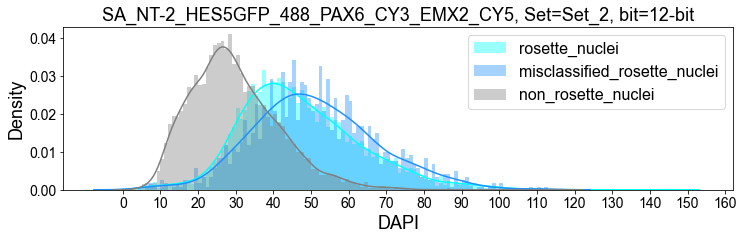

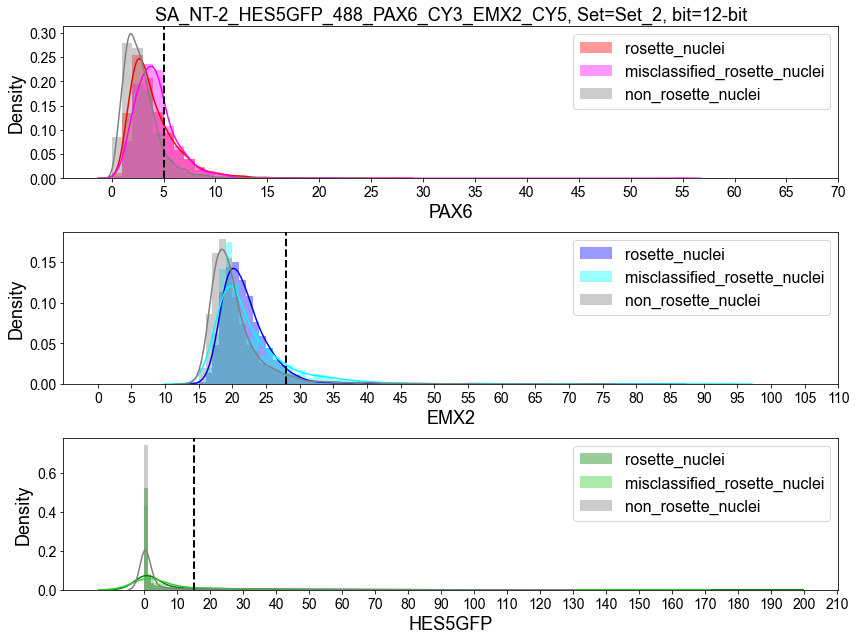

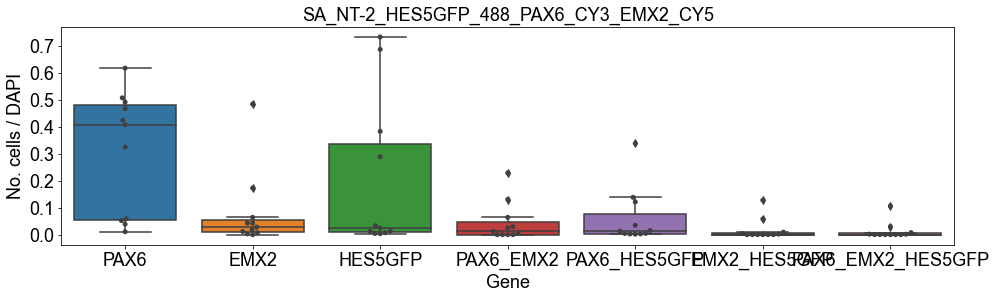

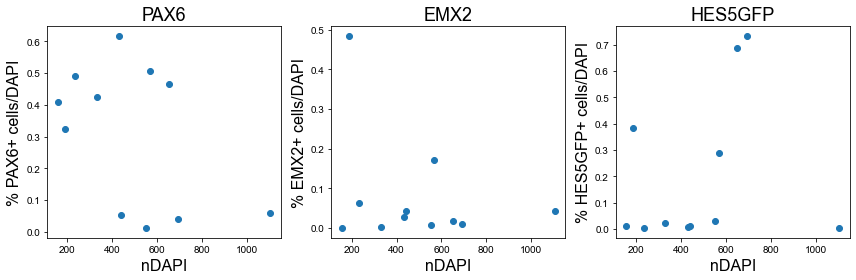

SA_SBN-1_HES5GFP_488_PAX6_CY3_EMX2_CY5


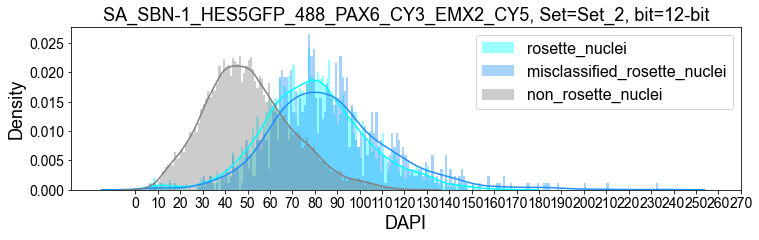

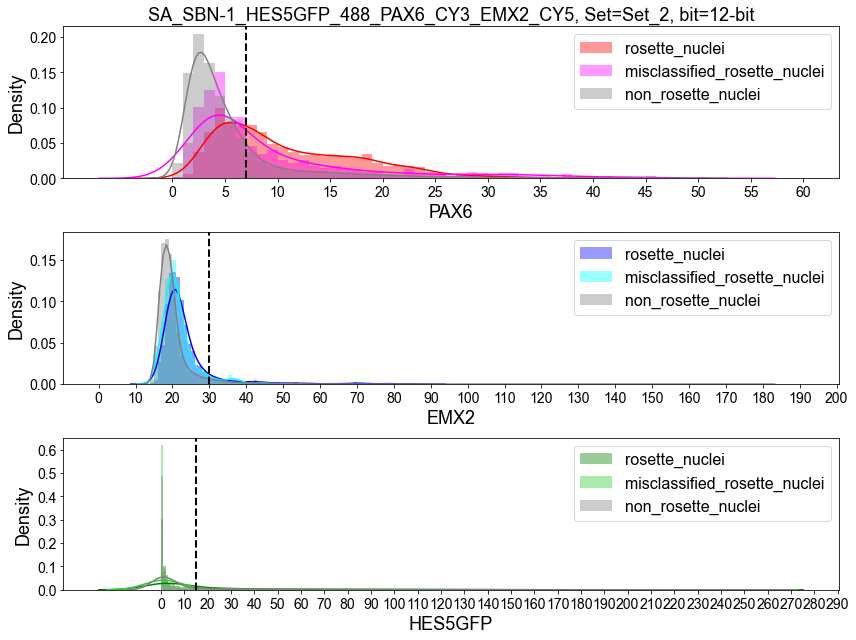

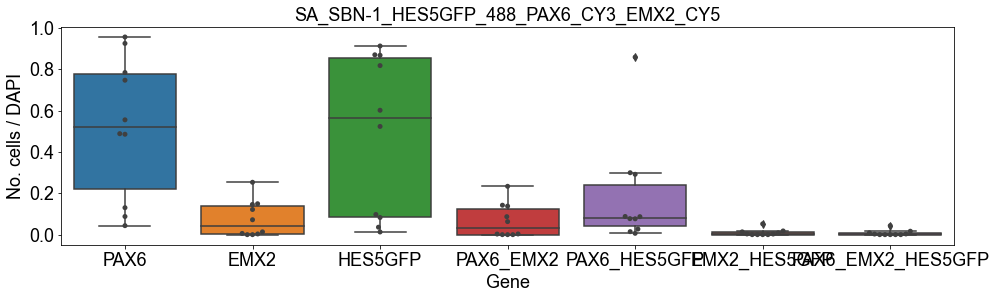

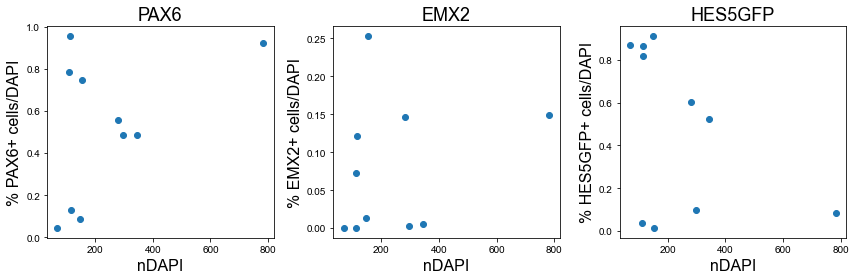

SA_NT-1_HES5GFP_488_PAX6_CY3_EMX2_CY5


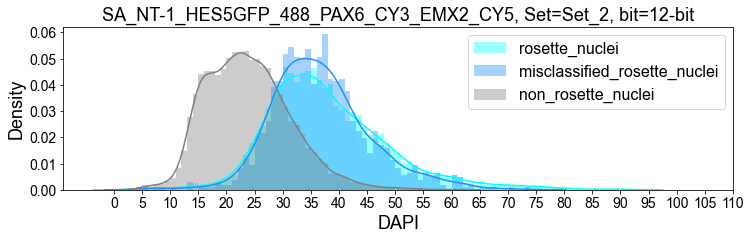

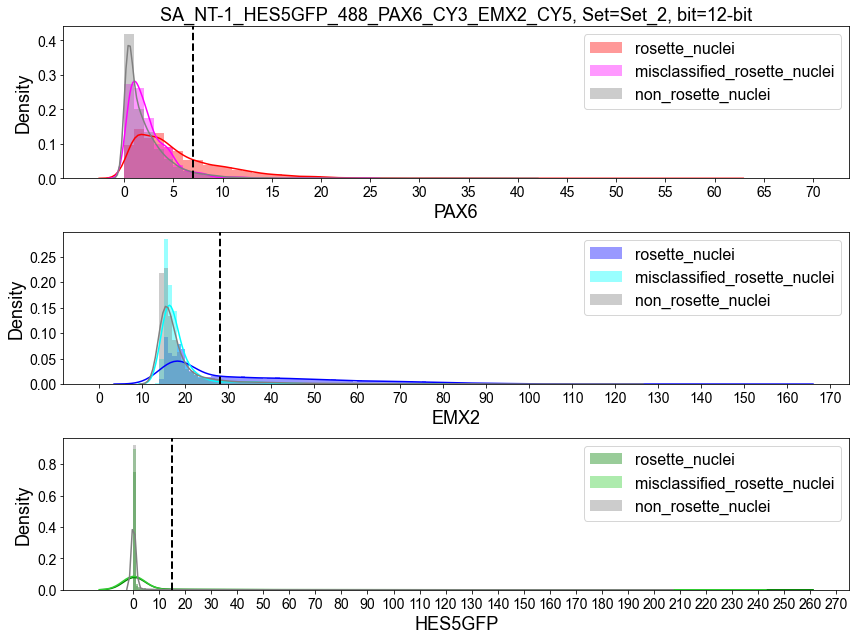

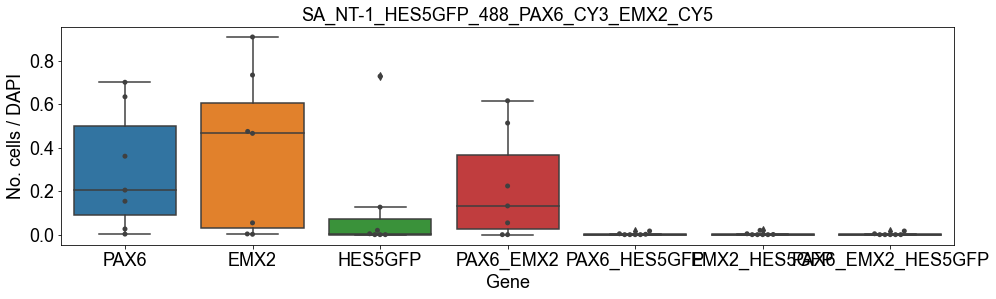

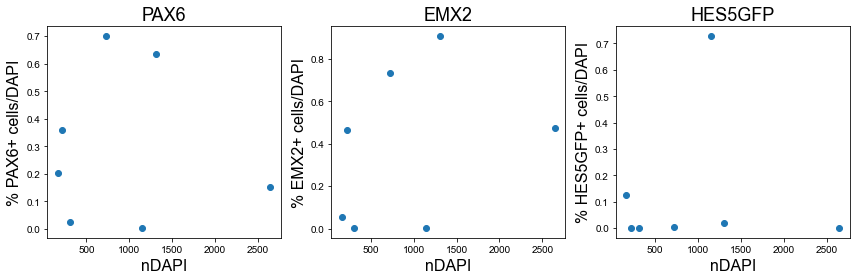

SA_SBNX-1_HES5GFP_488_PAX6_CY3_EMX2_CY5


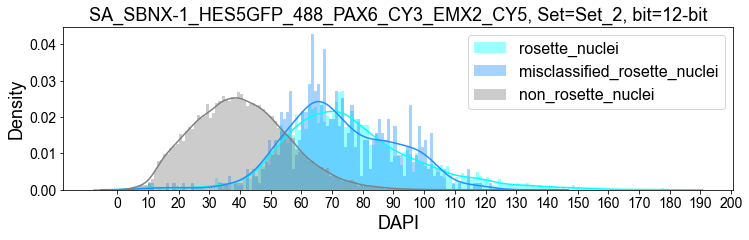

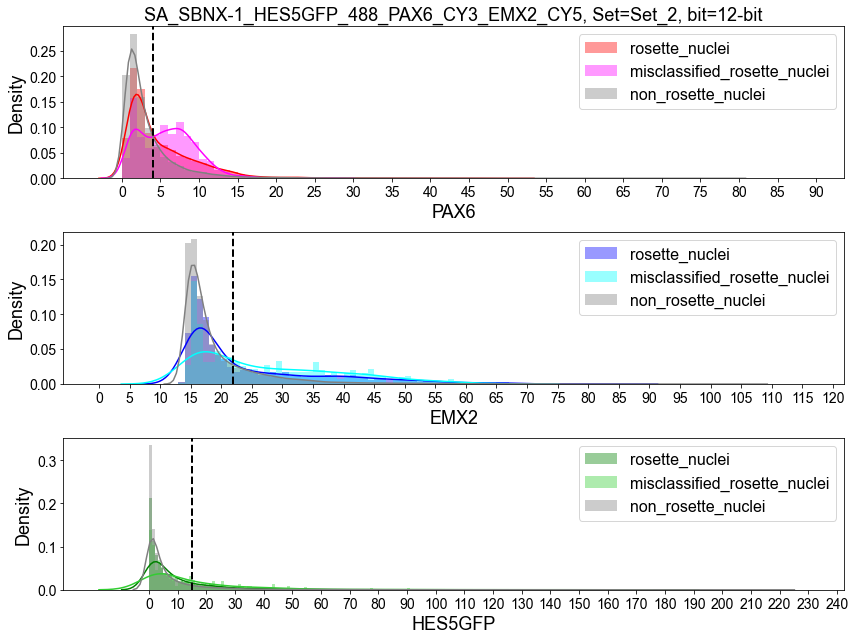

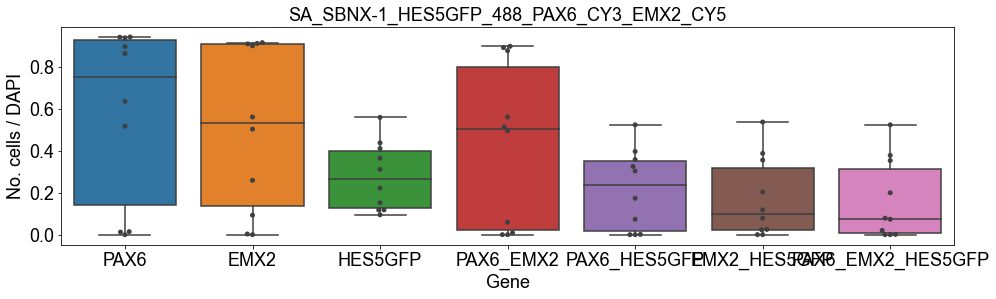

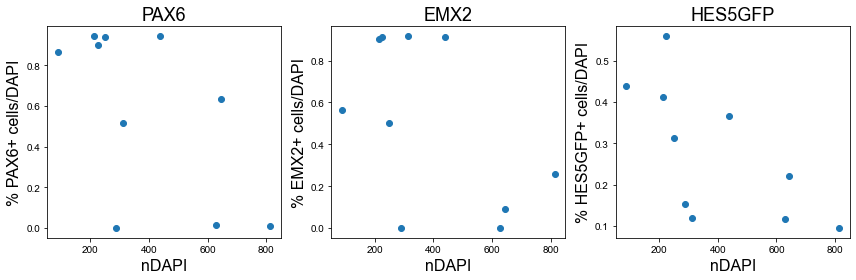

In [26]:
meta_dat = pd.read_csv('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/D30_countings_from_Rene/data/meta_data_rosette_objects_and_sets.tsv',sep='\t',index_col=0)
gene1 = 'PAX6'
gene2 = 'EMX2'

for sample in list(set(meta_dat.index)):
    
    if gene1 not in sample:
        continue
    if gene2 not in sample:
        continue
    if 'HES5' not in sample:
        continue

    gene_pair = frozenset([gene1,gene2])
    
    print(sample)
    set_id, rosettes = read_in_metadata_for_samp(meta_dat,sample)
    df_dict = get_dataframes_from_samp(sample)
    rosette_id_map = build_rosette_id_mapping(df_dict)
    rosette_mask_ids,tot_rosette_mask_ids,non_rosette_mask_ids = get_rosette_and_non_rosette_mask_ids(df_dict,rosettes,rosette_id_map)
    
    gene_channel_dict_r,gene_channel_dict,gene_color_dict = get_gene_to_color_map(set_id,sample)

    df_dict_rescaled,bit_value = reformat_dfs_with_8_bit(df_dict,rosettes,rosette_id_map,gene_channel_dict)
    
    # Plot DAPI #
    fig = plt.figure(figsize=(12,3))
    ax = plt.subplot(111)
    fig = plot_histogram_channel('DAPI',gene_channel_dict,df_dict_rescaled,tot_rosette_mask_ids,non_rosette_mask_ids,\
                                     set_id,gene_color_dict,bit_value,fig,ax)
    plt.show()
    
    df_dict,df_dict_rescaled = filter_cells_by_DAPI(df_dict,df_dict_rescaled,DAPI_cutoff=15)
    
    ### Remove Rosettes with small numbers of cells (for now n = 50)
    df_dict,df_dict_rescaled,rosette_mask_ids = filter_rosettes(df_dict,df_dict_rescaled,rosette_mask_ids,n_cells_cutoff=50) 
    
    fig = plt.figure(figsize=(12,9))
    pos_negs_ids_per_gene = {}
    genes = [gene1,gene2,'HES5GFP']
    for j,gene in enumerate(genes):
        ax = plt.subplot(3,1,j+1)
        if sample not in gene_intensity_cutoff_dict:
            intensity_cutoff = 10
        else:
            intensity_cutoff = gene_intensity_cutoff_dict[sample][gene]
        fig = plot_histogram_channel(gene,gene_channel_dict,df_dict_rescaled,tot_rosette_mask_ids,non_rosette_mask_ids,\
                                     set_id,gene_color_dict,bit_value,fig,ax)
        plt.axvline(intensity_cutoff,linestyle='--',linewidth=2,color='black')
        pos_ids_per_rosette,neg_ids_per_rosette,pos_ids_mistaken_rosettes,\
        neg_ids_mistaken_rosettes,pos_ids_non_rosette,neg_ids_non_rosette = \
        get_pos_neg_cells_per_rosette(gene,gene_channel_dict,df_dict_rescaled,tot_rosette_mask_ids,non_rosette_mask_ids,\
                                      intensity_cutoff)       
        pos_negs_ids_per_gene[gene] = [pos_ids_per_rosette,neg_ids_per_rosette,pos_ids_mistaken_rosettes,\
        neg_ids_mistaken_rosettes,pos_ids_non_rosette,neg_ids_non_rosette]
        if j != 0:
            plt.title('')
    
    plt.tight_layout()
    plt.show()
    df_for_plotting = generate_df_for_plotting_triplet(pos_negs_ids_per_gene,genes,sample)
    agg_df = pd.concat([agg_df,df_for_plotting])
    df_non_rosettes = generate_df_non_rosettes_triplets(pos_negs_ids_per_gene,genes,sample)
    agg_df = pd.concat([agg_df,df_non_rosettes])
    fig = plt.figure(figsize=(16,4))
    ax = plt.subplot(111)
    fig = plot_comparisons_double_positives(df_for_plotting,sample,fig,ax)
    plt.show()
    
    fig = plt.figure(figsize=(12,4))
    for j,gene in enumerate(genes):
        ax = plt.subplot(1,3,j+1)
        df_gene = df_for_plotting[df_for_plotting['gene']==gene]
        plt.scatter(df_gene['n_DAPI'],df_gene['n_pos']/df_gene['n_DAPI'])
        plt.title(gene,fontsize=18)
        plt.xlabel('nDAPI',fontsize=16)
        plt.ylabel('% '+gene+'+ cells/DAPI',fontsize=16)
    plt.tight_layout()
    plt.show()

In [27]:
new_exp = []
rosette_number = []
rosette_iter = 1
added_samps = {}
tx_map_r = {'Dual SMAD-i':'SBN','Triple-i':'SBNX','Inhibitor-free':'NT'}
for j,(experiment,gene,type_,protocol,sample) in enumerate(zip(agg_df['experiment'],agg_df['gene'],agg_df['type'],agg_df['protocol'],agg_df['sample'])):
    if experiment not in added_samps:
        added_samps[experiment] = {}
    if protocol not in added_samps[experiment]:
        added_samps[experiment][protocol] = []
    if sample not in added_samps[experiment][protocol]:
        added_samps[experiment][protocol].append(sample)
        exp_iter = len(added_samps[experiment][protocol])
    if j == 0:
        rosette_number.append(rosette_iter)
        prev_ = [experiment,gene,protocol]
        new_exp.append(tx_map_r[protocol]+"_"+experiment+"_"+str(exp_iter))
        rosette_iter += 1
        continue
    if type_ != 'rosette':
        rosette_number.append('na')
        new_exp.append(tx_map_r[protocol]+"_"+experiment+"_"+str(exp_iter))
        rosette_iter = 1
    else:
        if [experiment,gene,protocol] == prev_:
            rosette_number.append(rosette_iter)
            new_exp.append(tx_map_r[protocol]+"_"+experiment+"_"+str(exp_iter))
            rosette_iter += 1
        elif experiment == prev_[0] and protocol == prev_[2]:
            rosette_iter = 1
            rosette_number.append(rosette_iter)
            new_exp.append(tx_map_r[protocol]+"_"+experiment+"_"+str(exp_iter))
            rosette_iter += 1
        elif experiment == prev_[0]:
            rosette_iter = 1
            rosette_number.append(rosette_iter)
            new_exp.append(tx_map_r[protocol]+"_"+experiment+"_"+str(exp_iter))
            rosette_iter += 1
        else:
            rosette_iter = 1
            rosette_number.append(rosette_iter)
            new_exp.append(tx_map_r[protocol]+"_"+experiment+"_"+str(exp_iter))
            rosette_iter += 1
        prev_ = [experiment,gene,protocol]

In [28]:
agg_df['new_sample'] = new_exp
agg_df['rosette_number'] = rosette_number

In [29]:
agg_df.head(n=200)

experiment  n_DAPI       gene  n_pos  percent_pos  \
0   EMX2_PAX6  1805.0       PAX6   15.0     0.008310   
1   EMX2_PAX6   661.0       PAX6    6.0     0.009077   
2   EMX2_PAX6   574.0       PAX6   19.0     0.033101   
3   EMX2_PAX6   544.0       PAX6   25.0     0.045956   
4   EMX2_PAX6   417.0       PAX6  280.0     0.671463   
..        ...     ...        ...    ...          ...   
33  EMX2_PAX6   800.0  PAX6_EMX2    5.0     0.006250   
34  EMX2_PAX6   645.0  PAX6_EMX2    1.0     0.001550   
35  EMX2_PAX6   819.0  PAX6_EMX2    6.0     0.007326   
36  EMX2_PAX6   316.0  PAX6_EMX2    2.0     0.006329   
37  EMX2_PAX6   299.0  PAX6_EMX2    3.0     0.010033   

                        sample        protocol     type       new_sample  \
0   SA_SBN-1_PAX6_CY3_EMX2_CY5     Dual SMAD-i  rosette  SBN_EMX2_PAX6_1   
1   SA_SBN-1_PAX6_CY3_EMX2_CY5     Dual SMAD-i  rosette  SBN_EMX2_PAX6_1   
2   SA_SBN-1_PAX6_CY3_EMX2_CY5     Dual SMAD-i  rosette  SBN_EMX2_PAX6_1   
3   SA_SBN-1_PAX6_CY3_EMX2_CY5     Dual SMAD-i  rosette  SBN_EMX2_PAX6_1   
4   SA_SBN-1_PAX6_CY3_EMX2_CY5     Dual SMAD-i  rosette  SBN_EMX2_PAX6_1   
..                         ...             ...      ...              ...   
33   SA_NT-1_PAX6_CY3_EMX2_CY5  Inhibitor-free  rosette   NT_EMX2_PAX6_1   
34   SA_NT-1_PAX6_CY3_EMX2_CY5  Inhibitor-free  rosette   NT_EMX2_PAX6_1   
35   SA_NT-1_PAX6_CY3_EMX2_CY5  Inhibitor-free  rosette   NT_EMX2_PAX6_1   
36   SA_NT-1_PAX6_CY3_EMX2_CY5  Inhibitor-free  rosette   NT_EMX2_PAX6_1   
37   SA_NT-1_PAX6_CY3_EMX2_CY5  Inhibitor-free  rosette   NT_EMX2_PAX6_1   

   rosette_number  
0               1  
1               2  
2               3  
3               4  
4               5  
..            ...  
33              6  
34              7  
35              8  
36              9  
37             10  

[200 rows x 10 columns]

In [30]:
agg_df.to_csv('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/D30_countings_from_Rene/agg_data.tsv',sep='\t',index=False)

In [31]:
agg_df_dict_2 = {'experiment':[],'n_DAPI':[],'gene':[],'n_pos':[],'percent_pos':[],'sample':[],'protocol':[]}
agg_df_2 = pd.DataFrame(agg_df_dict_2)

SA_NT_HES5_488_SOX1_CY3_FOXG1_CY5


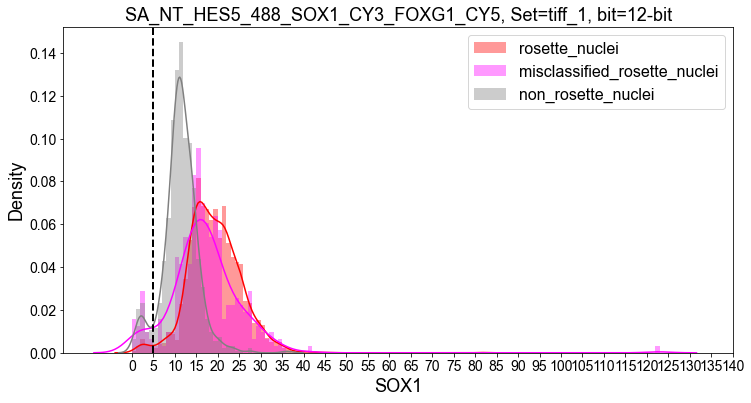

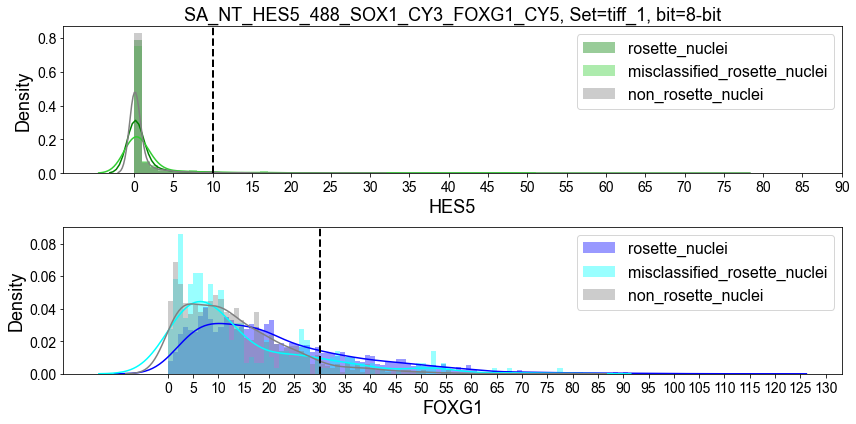

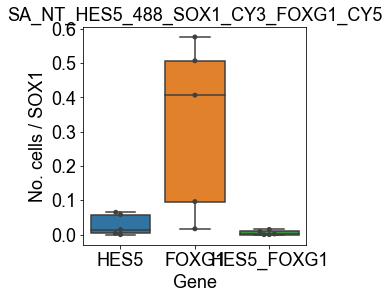

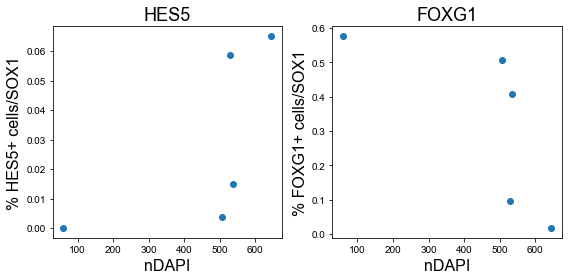

SA_SBNX_HES5_488_SOX1_CY3_FOXG1_CY5


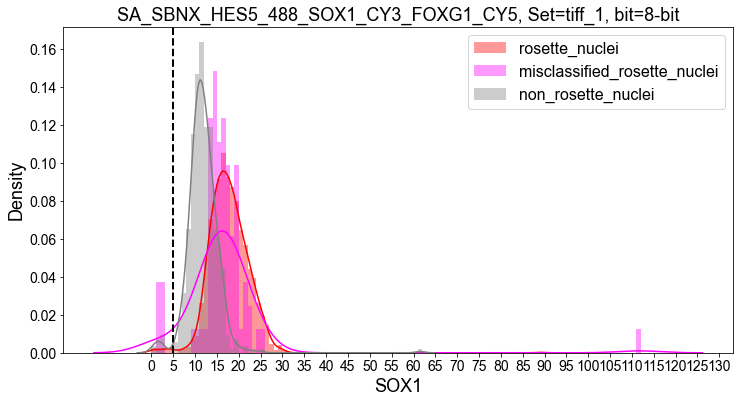

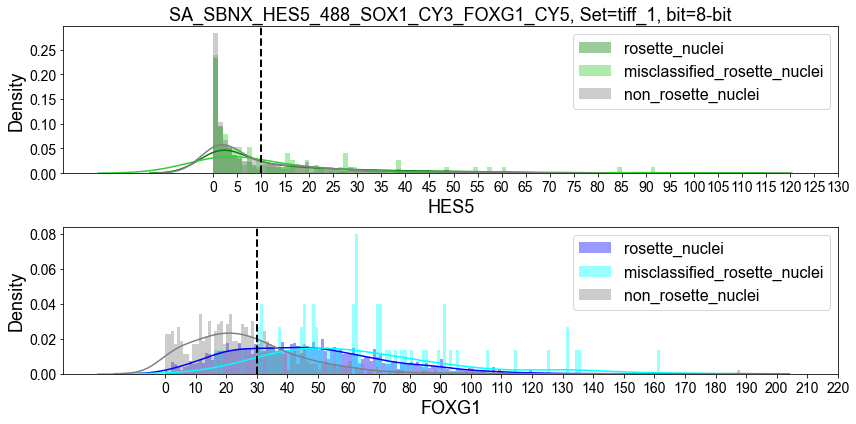

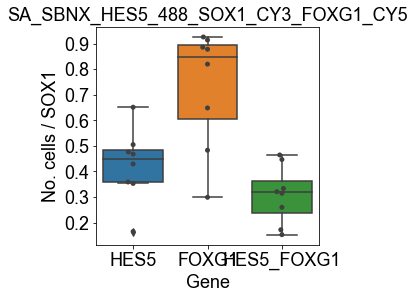

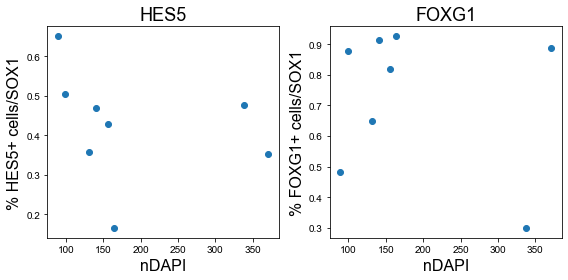

SA_SBNX_HES5_488_SOX1_CY3_FOXG1_CY5_Pic 2


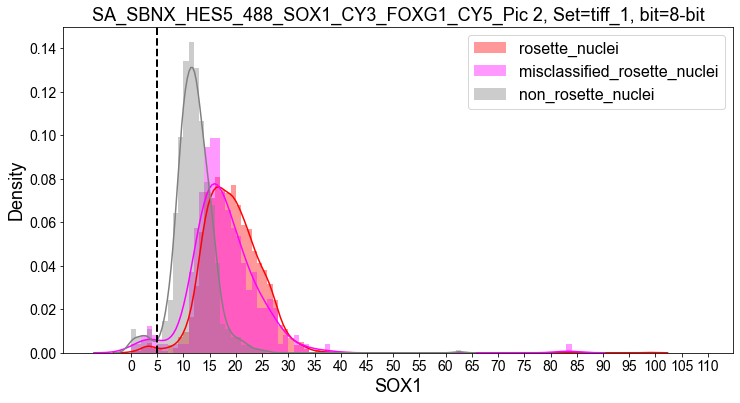

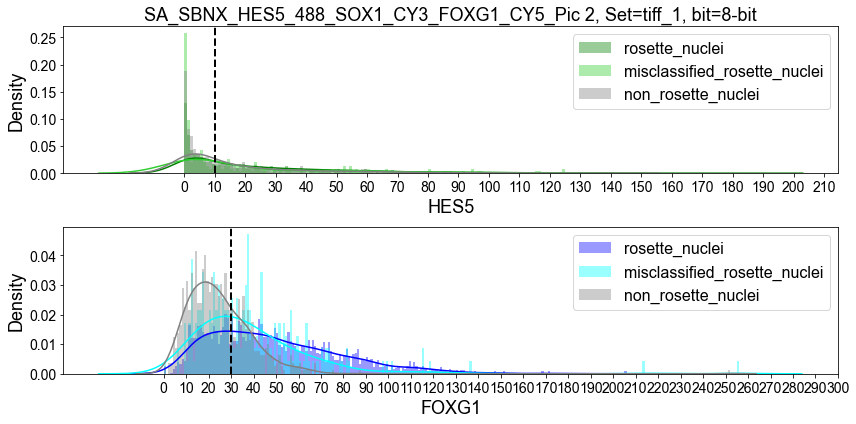

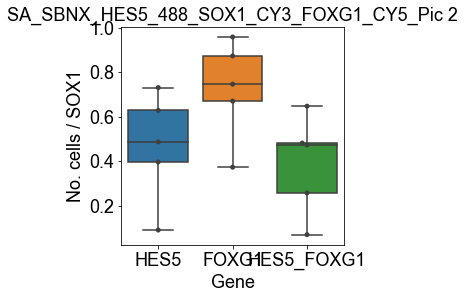

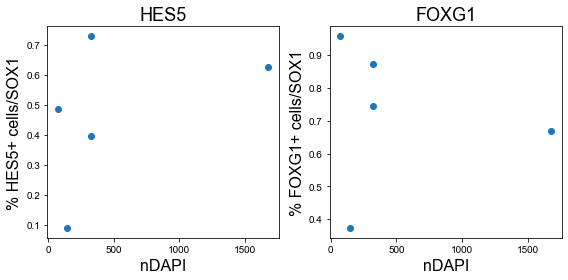

SA_SBN_HES5_488_SOX1_CY3_FOXG1_CY5


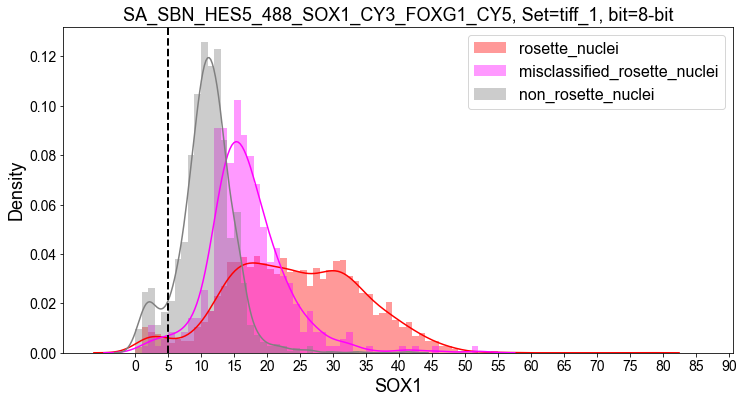

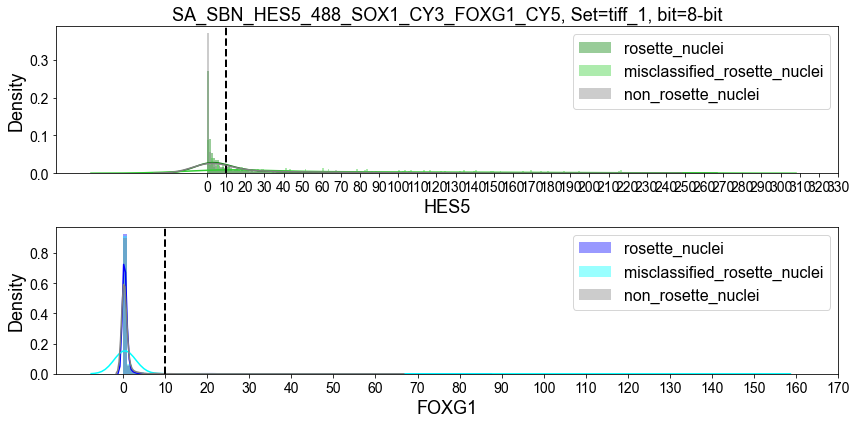

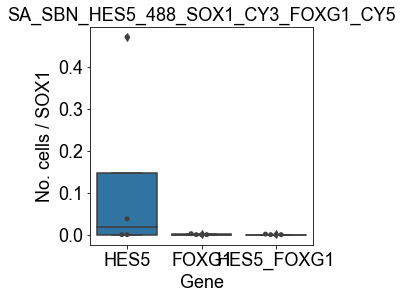

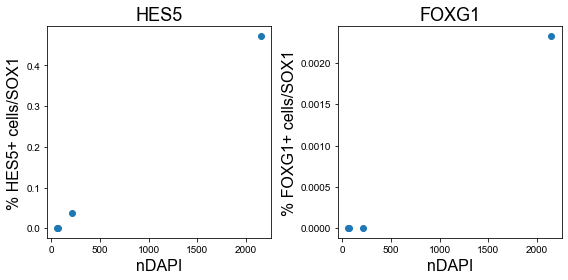

In [32]:
meta_dat = pd.read_csv('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/D30_countings_from_Rene/data/meta_data_rosette_objects_and_sets.tsv',sep='\t',index_col=0)
gene1 = 'HES5'
gene2 = 'FOXG1'

for sample in list(set(meta_dat.index)):
    
    if gene1 not in sample:
        continue
    if gene2 not in sample:
        continue
    if 'HES5' not in sample:
        continue

    gene_pair = frozenset([gene1,gene2])
    
    print(sample)
    set_id, rosettes = read_in_metadata_for_samp(meta_dat,sample)
    df_dict = get_dataframes_from_samp(sample)
    rosette_id_map = build_rosette_id_mapping(df_dict)
    rosette_mask_ids,tot_rosette_mask_ids,non_rosette_mask_ids = get_rosette_and_non_rosette_mask_ids(df_dict,rosettes,rosette_id_map)
    
    gene_channel_dict_r,gene_channel_dict,gene_color_dict = get_gene_to_color_map(set_id,sample)
    
    if "ParentID::ID of the parent!!I" not in df_dict['R_Nuclei'].columns:
        print(sample,set_id, ' Missing ParentID in R_Nuclei table!! Exiting', set_id)
        continue
    
    fig = plt.figure(figsize=(12,6))
    pos_negs_ids_per_gene = {}
    genes = ['SOX1']
    intensity_cutoff = 5
    fig = plot_histogram_channel('SOX1',gene_channel_dict,df_dict,tot_rosette_mask_ids,non_rosette_mask_ids,\
                                 set_id,gene_color_dict,bit_value,fig,ax)
    plt.axvline(intensity_cutoff,linestyle='--',linewidth=2,color='black')
    plt.show()
    
    df_dict_rescaled,bit_value = reformat_dfs_with_8_bit(df_dict,rosettes,rosette_id_map,gene_channel_dict,gene="SOX1")
    df_dict,df_dict_rescaled = filter_cells_by_DAPI(df_dict,df_dict_rescaled,DAPI_cutoff=5,gene="SOX1")
    
    ### Remove Rosettes with small numbers of cells (for now n = 100)
    df_dict,df_dict_rescaled,rosette_mask_ids = filter_rosettes(df_dict,df_dict_rescaled,rosette_mask_ids,n_cells_cutoff=50) 
    
    fig = plt.figure(figsize=(12,6))
    pos_negs_ids_per_gene = {}
    genes = [gene1,gene2]
    for j,gene in enumerate(genes):
        ax = plt.subplot(2,1,j+1)
        intensity_cutoff = gene_intensity_cutoff_dict[sample][gene]
        fig = plot_histogram_channel(gene,gene_channel_dict,df_dict,tot_rosette_mask_ids,non_rosette_mask_ids,\
                                     set_id,gene_color_dict,bit_value,fig,ax)
        plt.axvline(intensity_cutoff,linestyle='--',linewidth=2,color='black')
        pos_ids_per_rosette,neg_ids_per_rosette,pos_ids_mistaken_rosettes,\
        neg_ids_mistaken_rosettes,pos_ids_non_rosette,neg_ids_non_rosette = \
        get_pos_neg_cells_per_rosette(gene,gene_channel_dict,df_dict,tot_rosette_mask_ids,non_rosette_mask_ids,\
                                      intensity_cutoff)       
        pos_negs_ids_per_gene[gene] = [pos_ids_per_rosette,neg_ids_per_rosette,pos_ids_mistaken_rosettes,\
        neg_ids_mistaken_rosettes,pos_ids_non_rosette,neg_ids_non_rosette]
        if j != 0:
            plt.title('')

    plt.tight_layout()  
    plt.show()
    df_for_plotting = generate_df_for_plotting(pos_negs_ids_per_gene,genes,sample)
    agg_df_2 = pd.concat([agg_df_2,df_for_plotting])
    df_non_rosettes = generate_df_non_rosettes(pos_negs_ids_per_gene,genes,sample)
    agg_df_2 = pd.concat([agg_df_2,df_non_rosettes])
    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(111)
    fig = plot_comparisons_double_positives(df_for_plotting,sample,fig,ax)
    plt.ylabel('No. cells / SOX1')
    plt.show()
    
    fig = plt.figure(figsize=(8,4))
    for j,gene in enumerate(genes):
        ax = plt.subplot(1,2,j+1)
        df_gene = df_for_plotting[df_for_plotting['gene']==gene]
        plt.scatter(df_gene['n_DAPI'],df_gene['n_pos']/df_gene['n_DAPI'])
        plt.title(gene,fontsize=18)
        plt.xlabel('nDAPI',fontsize=16)
        plt.ylabel('% '+gene+'+ cells/SOX1',fontsize=16)
    plt.tight_layout()
    plt.show()

In [33]:
cols = agg_df_2.columns
new_cols = []
for col in cols:
    if col == 'n_DAPI': new_cols.append('n_SOX1')
    else: new_cols.append(col)
agg_df_2.columns = new_cols

agg_df_2.to_csv('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/D30_countings_from_Rene/agg_data_SOX1_FOXG1.tsv',sep='\t',index=False)

In [34]:
### TODOs
### 2. PAX6, EMX1

In [35]:
agg_df_dict_pvals = {'experiment':[],'comparison':[],'gene':[],'pval':[],'pval_adj':[],'star_pval':[],'star_pval_adj':[]}
agg_df_pvals = pd.DataFrame(agg_df_dict_pvals)
pval_dict_full = {}

In [51]:
8/6.5*3

3.6923076923076925

PAX6 Inhibitor-free Dual SMAD-i 6.712591579572686e-05 ****
COUPTF1 Inhibitor-free Dual SMAD-i 2.0444013861823188e-10 ****
PAX6_COUPTF1 Inhibitor-free Dual SMAD-i 8.23129910621459e-06 ****
PAX6 Inhibitor-free Triple-i 0.00015901367136189756 ***
COUPTF1 Inhibitor-free Triple-i 0.13079709540845305 n.s.
PAX6_COUPTF1 Inhibitor-free Triple-i 0.004898418792541796 **
PAX6 Dual SMAD-i Triple-i 0.49705443936290294 n.s.
COUPTF1 Dual SMAD-i Triple-i 3.356899229360499e-11 ****
PAX6_COUPTF1 Dual SMAD-i Triple-i 0.0014280992562004677 **
PAX6 Inhibitor-free Dual SMAD-i 0.9741699399873975 n.s.
EMX2 Inhibitor-free Dual SMAD-i 0.15613767738229975 n.s.
PAX6_EMX2 Inhibitor-free Dual SMAD-i 0.41259125115959294 n.s.
PAX6 Inhibitor-free Triple-i 0.0004360838894123816 ***
EMX2 Inhibitor-free Triple-i 0.08581773457517526 n.s.
PAX6_EMX2 Inhibitor-free Triple-i 0.005638801107940405 **
PAX6 Dual SMAD-i Triple-i 9.027473326306154e-05 ****
EMX2 Dual SMAD-i Triple-i 0.5096930555698592 n.s.
PAX6_EMX2 Dual SMAD-i Tripl

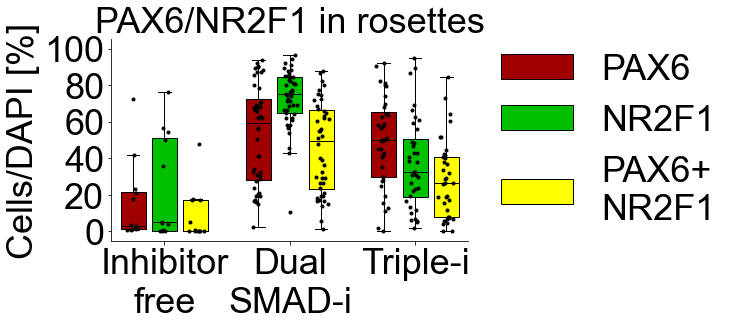

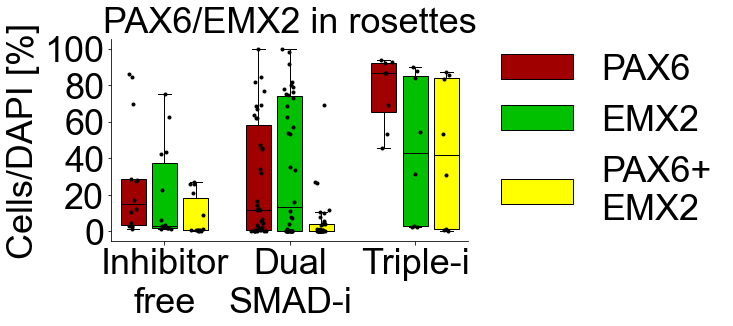

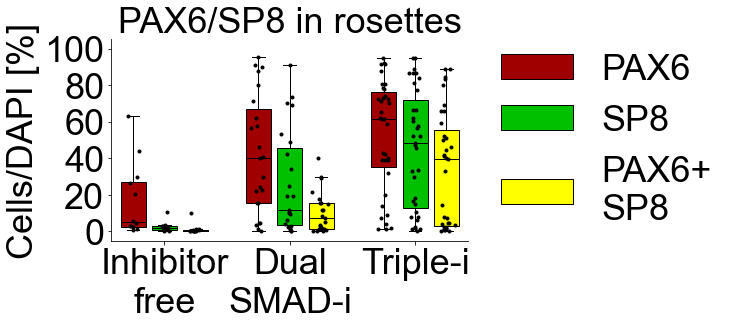

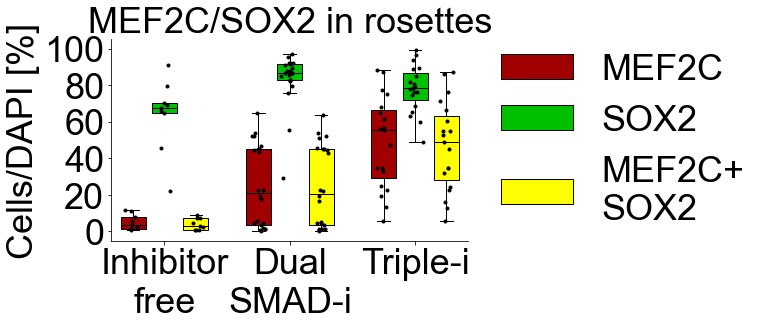

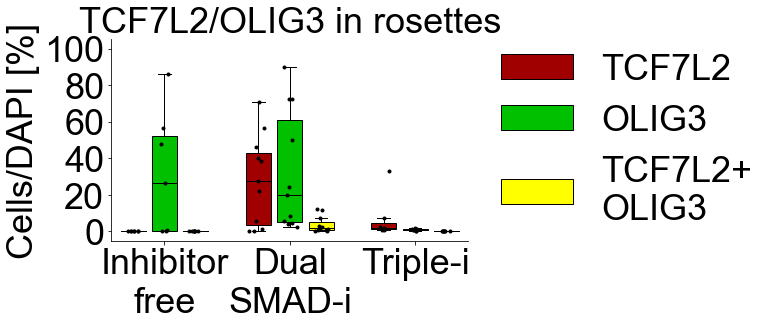

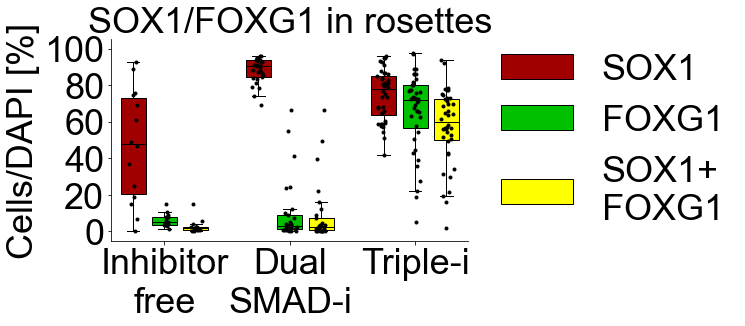

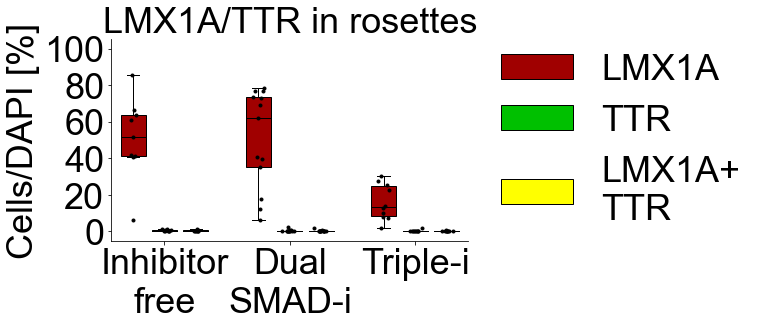

In [52]:
# 1. make aggregate SBNX, SBN, NT box plots
# 2. plot bar plots for cells in mistaken and non-rosettes

colors_full = [(160/255.,0,0),(0,192/255.,0),(255/255.,255/255.,0)]

for genes in [['PAX6','COUPTF1'],['PAX6','EMX2'],['PAX6','SP8'],['SOX2','MEF2C'],['TCF7L2','OLIG3'],
             ['SOX1','FOXG1'],['LMX1A','TTR']]:
    
    #if genes != ['PAX6','SP8']: continue
    # first plot rosettes
    experiment = '_'.join(sorted(genes))
    if genes == ['SOX2','MEF2C']: genes = ['MEF2C','SOX2']
    df_sub = agg_df[(agg_df['experiment'] == experiment) & (agg_df['type'] == 'rosette')]
    vals = []
    positions = []
    colors = []
    pos_iter = 0
    n_tx = {}
    pval_dict = {}
    
    for j,tx in enumerate(['Inhibitor-free','Dual SMAD-i','Triple-i']):
        
        df_sub_exp = df_sub[df_sub['protocol']==tx]
        n_tx[tx] = len(set(df_sub_exp['sample']))
        for k,gene in enumerate(genes):
            df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene]
            vals.append(list(df_sub_exp_gene['percent_pos']))
            positions.append(pos_iter)
            colors.append(colors_full[k])
            pos_iter += 1

        gene_combo = genes[0]+"_"+genes[1]
        if genes[0] == 'TCF7L2': gene_combo = 'OLIG3_TCF7L2'
        if genes[0] == 'MEF2C': gene_combo = 'SOX2_MEF2C'
        df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene_combo]
        vals.append(list(df_sub_exp_gene['percent_pos']))
        positions.append(pos_iter)
        colors.append(colors_full[k+1])
        pos_iter += 1
        # double and triple combos
        pos_iter+=1
    
    ### t-tests for difference  in means ###
    for j,tx_comp in enumerate([['Inhibitor-free','Dual SMAD-i'],['Inhibitor-free','Triple-i'],['Dual SMAD-i','Triple-i']]):
        
        df_sub_exp = df_sub[df_sub['protocol'].isin([tx_comp[0],tx_comp[1]])]
        n_tx[tx] = len(set(df_sub_exp['sample']))
        for k,gene in enumerate(genes):
            vals1 = list(df_sub[(df_sub['protocol']==tx_comp[0]) & (df_sub['gene']==gene)]['percent_pos'])
            vals2 = list(df_sub[(df_sub['protocol']==tx_comp[1]) & (df_sub['gene']==gene)]['percent_pos'])
            t, p = ttest(vals1, vals2,alternative='two.sided')#,alternative='less')
            if p < 0.0001: star_t = '****'
            elif p < 0.001: star_t = '***'
            elif p < 0.01: star_t = '**'
            elif p < 0.05: star_t = '*'
            else: star_t = 'n.s.'
            print(gene, tx_comp[0], tx_comp[1], p, star_t)
            pval_dict[gene+'.'+tx_comp[0]+'_'+tx_comp[1]] = p
        
        gene_combo = genes[0]+"_"+genes[1]
        if genes[0] == 'TCF7L2': gene_combo = 'OLIG3_TCF7L2'
        if genes[0] == 'MEF2C': gene_combo = 'SOX2_MEF2C'
        vals1 = list(df_sub[(df_sub['protocol']==tx_comp[0]) & (df_sub['gene']==gene_combo)]['percent_pos'])
        vals2 = list(df_sub[(df_sub['protocol']==tx_comp[1]) & (df_sub['gene']==gene_combo)]['percent_pos'])
        t, p = ttest(vals1, vals2,alternative='two.sided')#,alternative='less')
        if p < 0.0001: star_t = '****'
        elif p < 0.001: star_t = '***'
        elif p < 0.01: star_t = '**'
        elif p < 0.05: star_t = '*'
        else: star_t = 'n.s.'
        print(gene_combo, tx_comp[0], tx_comp[1], p, star_t)
        pval_dict[gene_combo+'.'+tx_comp[0]+'_'+tx_comp[1]] = p
    
    pval_dict_full[experiment] = pval_dict
    fig = plt.figure(figsize=(8,3.7))
    ax = plt.subplot(111)

    bp = ax.boxplot(vals,positions=positions,showfliers=False,vert=True, patch_artist=True,zorder=1,widths=0.8)
    for j,patch in enumerate(bp['boxes']):
        patch.set_facecolor(color=colors[j])
    for j,whisker in enumerate(bp['whiskers']):
        whisker.set(color='black', linewidth=1)
    for j,cap in enumerate(bp['caps']):
        cap.set(color='black', linewidth=1)
    for j,median in enumerate(bp['means']):
        median.set(color='black', linewidth=1)
    for j,median in enumerate(bp['medians']):
        median.set(color='black', linewidth=1)

    for val,pos,col in zip(vals,positions,colors):
        plt.plot([pos]*len(val)+np.random.randn(len(val))*0.1,val,'.',markersize=6,color='black',
                 zorder=2,alpha=1)#markerfacecolor='none',
    
    plt.ylim(-0.05,1.05)
    plt.xlim(plt.xlim()[0]-0.2,plt.xlim()[1]+0.2)
    for k,gene in enumerate(genes):
        plt.bar(-10,0,color=colors_full[k],label=gene.replace("COUPTF1","NR2F1"),edgecolor='black')

    plt.bar(-10,0,color=colors_full[k+1],label=genes[0]+"+\n"+genes[1].replace("COUPTF1","NR2F1"),edgecolor='black')
    plt.legend(fontsize=14)
    #plt.xticks([1,5,9],[tx+'\n(N='+str(n_tx[tx])+')' for tx in ['Inhibitor-free','Dual-SMAD-i','Triple-i']],fontsize=18)
    plt.xticks([1,5,9],['Inhibitor\nfree','Dual\nSMAD-i','Triple-i'],fontsize=36)
    plt.yticks(fontsize=36)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=36,frameon=False)
    plt.ylabel('Cells/DAPI [%]',fontsize=36)
    plt.yticks([0,0.2,0.4,0.6,0.8,1],['0','20','40','60','80','100'],fontsize=36)
    plt.title('/'.join([gene.replace("COUPTF1","NR2F1") for gene in genes]) + ' in rosettes',fontsize=36)
    #plt.tight_layout()
    plt.savefig('figures/fig2/'+experiment+'.png',dpi=500,bbox_inches='tight')
    plt.savefig('figures/fig2/'+experiment+'.pdf',bbox_inches='tight')

PAX6_EMX2 Inhibitor-free Dual SMAD-i 0.45672077453103066 n.s.
PAX6_HES5GFP Inhibitor-free Dual SMAD-i 0.03868577059446029 *
EMX2_HES5GFP Inhibitor-free Dual SMAD-i 0.8074813709213847 n.s.
PAX6_EMX2_HES5GFP Inhibitor-free Dual SMAD-i 0.837167348457623 n.s.
PAX6_EMX2 Inhibitor-free Triple-i 0.006217593698311837 **
PAX6_HES5GFP Inhibitor-free Triple-i 0.002171213284436038 **
EMX2_HES5GFP Inhibitor-free Triple-i 0.0016031042744298527 **
PAX6_EMX2_HES5GFP Inhibitor-free Triple-i 0.0021627633471740905 **
PAX6_EMX2 Dual SMAD-i Triple-i 0.009380489527545721 **
PAX6_HES5GFP Dual SMAD-i Triple-i 0.7484590996685541 n.s.
EMX2_HES5GFP Dual SMAD-i Triple-i 0.015083169813822512 *
PAX6_EMX2_HES5GFP Dual SMAD-i Triple-i 0.019580042208335164 *


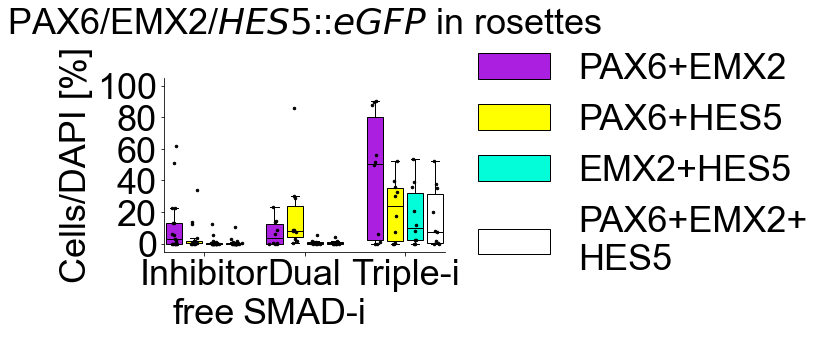

In [80]:
# 1. make aggregate SBNX, SBN, NT box plots
# 2. plot bar plots for cells in mistaken and non-rosettes

colors_full = [(160/255.,0,0),'blue',(0,192/255.,0),(171/255.,31/255.,224/255.),(255/255.,255/255.,0),(2/255.,253/255.,216/255.),'white']

for genes in [['PAX6','EMX2','HES5GFP']]:
    
    #if genes != ['PAX6','SP8']: continue
    # first plot rosettes
    experiment = '_'.join(sorted(genes))
    df_sub = agg_df[(agg_df['experiment'] == experiment) & (agg_df['type'] == 'rosette')]
    vals = []
    positions = []
    colors = []
    pos_iter = 0
    n_tx = {}
    k=0
    pval_dict = {}
    
    for j,tx in enumerate(['Inhibitor-free','Dual SMAD-i','Triple-i']):
        
        df_sub_exp = df_sub[df_sub['protocol']==tx]
        n_tx[tx] = len(set(df_sub_exp['sample']))
        
        # double combos
        for kk,gene_combo in enumerate([genes[0]+"_"+genes[1],genes[0]+"_"+genes[2],genes[1]+"_"+genes[2]]):
            df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene_combo]
            vals.append(list(df_sub_exp_gene['percent_pos']))
            positions.append(pos_iter)
            colors.append(colors_full[kk+2+1])
            pos_iter+=1
        
        #triple combo
        df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==genes[0]+"_"+genes[1]+"_"+genes[2]]
        vals.append(list(df_sub_exp_gene['percent_pos']))
        positions.append(pos_iter)
        colors.append(colors_full[kk+2+2])
        pos_iter += 2
    
    ### t-tests for difference  in means ###
    for j,tx_comp in enumerate([['Inhibitor-free','Dual SMAD-i'],['Inhibitor-free','Triple-i'],['Dual SMAD-i','Triple-i']]):
        
        df_sub_exp = df_sub[df_sub['protocol'].isin([tx_comp[0],tx_comp[1]])]
        
        # double combos
        for kk,gene_combo in enumerate([genes[0]+"_"+genes[1],genes[0]+"_"+genes[2],genes[1]+"_"+genes[2]]):
            vals1 = list(df_sub[(df_sub['protocol']==tx_comp[0]) & (df_sub['gene']==gene_combo)]['percent_pos'])
            vals2 = list(df_sub[(df_sub['protocol']==tx_comp[1]) & (df_sub['gene']==gene_combo)]['percent_pos'])
            t, p = ttest(vals1, vals2,alternative='two.sided')#,alternative='less')
            if p < 0.0001: star_t = '****'
            elif p < 0.001: star_t = '***'
            elif p < 0.01: star_t = '**'
            elif p < 0.05: star_t = '*'
            else: star_t = 'n.s.'
            print(gene_combo, tx_comp[0], tx_comp[1], p, star_t)
            pval_dict[gene_combo+'.'+tx_comp[0]+'_'+tx_comp[1]] = p
        
        gene_combo = genes[0]+"_"+genes[1]+"_"+genes[2]
        vals1 = list(df_sub[(df_sub['protocol']==tx_comp[0]) & (df_sub['gene']==gene_combo)]['percent_pos'])
        vals2 = list(df_sub[(df_sub['protocol']==tx_comp[1]) & (df_sub['gene']==gene_combo)]['percent_pos'])
        t, p = ttest(vals1, vals2,alternative='two.sided')#,alternative='less')
        if p < 0.0001: star_t = '****'
        elif p < 0.001: star_t = '***'
        elif p < 0.01: star_t = '**'
        elif p < 0.05: star_t = '*'
        else: star_t = 'n.s.'
        print(gene_combo, tx_comp[0], tx_comp[1], p, star_t)
        pval_dict[gene_combo+'.'+tx_comp[0]+'_'+tx_comp[1]] = p
    
    pval_dict_full[experiment] = pval_dict
    
    fig = plt.figure(figsize=(6.3,3.2))
    ax = plt.subplot(111)

    bp = ax.boxplot(vals,positions=positions,showfliers=False,vert=True, patch_artist=True,zorder=1,widths=0.8)
    for j,patch in enumerate(bp['boxes']):
        patch.set_facecolor(color=colors[j])
    for j,whisker in enumerate(bp['whiskers']):
        whisker.set(color='black', linewidth=1)
    for j,cap in enumerate(bp['caps']):
        cap.set(color='black', linewidth=1)
    for j,median in enumerate(bp['means']):
        median.set(color='black', linewidth=1)
    for j,median in enumerate(bp['medians']):
        median.set(color='black', linewidth=1)

    for val,pos,col in zip(vals,positions,colors):
        plt.plot([pos]*len(val)+np.random.randn(len(val))*0.1,val,'.',markersize=5,color='black',
                 zorder=2,alpha=1)#markerfacecolor='none',
    
    plt.ylim(-0.05,1.05)
    plt.xlim(plt.xlim())
    k=0
    #for kk,gene_combo in enumerate([genes[0]+"+"+genes[1],genes[0]+"+HES5::eGFP",genes[1]+"+HES5::eGFP"]):
    #    plt.bar(-10,0,color=colors_full[kk+2+1],label=gene_combo,edgecolor='black')
    #plt.bar(-10,0,color=colors_full[kk+2+2],label=genes[0]+"+"+genes[1]+"+HES5::eGFP",edgecolor='black')
    for kk,gene_combo in enumerate([genes[0]+"+"+genes[1],genes[0]+"+HES5",genes[1]+"+HES5"]):
        plt.bar(-10,0,color=colors_full[kk+2+1],label=gene_combo,edgecolor='black')
    plt.bar(-10,0,color=colors_full[kk+2+2],label=genes[0]+"+"+genes[1]+"+\nHES5",edgecolor='black')
    #plt.xticks([1.5,6.5,11.5],[tx+'\n(N='+str(n_tx[tx])+')' for tx in ['Inhibitor-free','Dual SMAD-i','Triple-i']],fontsize=18)
    plt.xticks([1.5,6.5,11.5],['Inhibitor\nfree','Dual\nSMAD-i','Triple-i'],fontsize=36)
    plt.yticks(fontsize=36)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=36,frameon=False)
    plt.ylabel('Cells/DAPI [%]',fontsize=36)
    plt.yticks([0,0.2,0.4,0.6,0.8,1],['0','20','40','60','80','100'],fontsize=36)
    plt.title('/'.join([x if x != 'HES5GFP' else '$\t{HES5}$::$\t{eGFP}$' for x in genes]) + ' in rosettes\n',fontsize=36)
    #plt.tight_layout()
    plt.savefig('figures/fig2/'+experiment+'.png',dpi=500,bbox_inches='tight')
    plt.savefig('figures/fig2/'+experiment+'.pdf')

FOXG1 Inhibitor-free Dual SMAD-i 0.039496836815288094 *
HES5 Inhibitor-free Dual SMAD-i 0.3659009129747287 n.s.
HES5_FOXG1 Inhibitor-free Dual SMAD-i 0.19159863128314977 n.s.
FOXG1 Inhibitor-free Triple-i 0.003686076649905218 **
HES5 Inhibitor-free Triple-i 0.00012701371934631365 ***
HES5_FOXG1 Inhibitor-free Triple-i 0.000336924151383966 ***
FOXG1 Dual SMAD-i Triple-i 1.0966213410362026e-05 ****
HES5 Dual SMAD-i Triple-i 0.011602803193986762 *
HES5_FOXG1 Dual SMAD-i Triple-i 0.0009384208905669303 ***


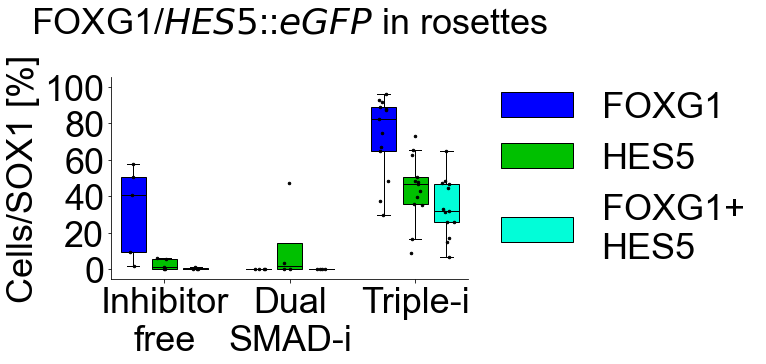

In [82]:
# 1. make aggregate SBNX, SBN, NT box plots
# 2. plot bar plots for cells in mistaken and non-rosettes

colors_full = [(160/255.,0,0),(0,192/255.,0),(255/255.,255/255.,0)]
colors_full = ['blue',(0,192/255.,0),(2/255.,253/255.,216/255.)]

for genes in [['FOXG1','HES5']]:
    
    #if genes != ['PAX6','SP8']: continue
    # first plot rosettes
    experiment = '_'.join(sorted(genes))
    df_sub = agg_df_2[(agg_df_2['experiment'] == experiment) & (agg_df_2['type'] == 'rosette')]
    vals = []
    positions = []
    colors = []
    pos_iter = 0
    n_tx = {}
    pval_dict = {}
    
    for j,tx in enumerate(['Inhibitor-free','Dual SMAD-i','Triple-i']):
        
        df_sub_exp = df_sub[df_sub['protocol']==tx]
        n_tx[tx] = len(set(df_sub_exp['sample']))
        for k,gene in enumerate(genes):
            df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene]
            vals.append(list(df_sub_exp_gene['percent_pos']))
            positions.append(pos_iter)
            colors.append(colors_full[k])
            pos_iter += 1

        gene_combo = genes[1]+"_"+genes[0]
        if genes[0] == 'TCF7L2': gene_combo = 'OLIG3_TCF7L2'
        df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene_combo]
        vals.append(list(df_sub_exp_gene['percent_pos']))
        positions.append(pos_iter)
        colors.append(colors_full[k+1])
        pos_iter += 1
        # double and triple combos
        pos_iter+=1
    
    ### t-tests for difference  in means ###
    for j,tx_comp in enumerate([['Inhibitor-free','Dual SMAD-i'],['Inhibitor-free','Triple-i'],['Dual SMAD-i','Triple-i']]):
        
        df_sub_exp = df_sub[df_sub['protocol'].isin([tx_comp[0],tx_comp[1]])]
        n_tx[tx] = len(set(df_sub_exp['sample']))
        for k,gene in enumerate(genes):
            vals1 = list(df_sub[(df_sub['protocol']==tx_comp[0]) & (df_sub['gene']==gene)]['percent_pos'])
            vals2 = list(df_sub[(df_sub['protocol']==tx_comp[1]) & (df_sub['gene']==gene)]['percent_pos'])
            t, p = ttest(vals1, vals2,alternative='two.sided')#,alternative='less')
            if p < 0.0001: star_t = '****'
            elif p < 0.001: star_t = '***'
            elif p < 0.01: star_t = '**'
            elif p < 0.05: star_t = '*'
            else: star_t = 'n.s.'
            print(gene, tx_comp[0], tx_comp[1], p, star_t)
            pval_dict[gene+'.'+tx_comp[0]+'_'+tx_comp[1]] = p
        
        gene_combo = genes[1]+"_"+genes[0]
        if genes[0] == 'TCF7L2': gene_combo = 'OLIG3_TCF7L2'
        vals1 = list(df_sub[(df_sub['protocol']==tx_comp[0]) & (df_sub['gene']==gene_combo)]['percent_pos'])
        vals2 = list(df_sub[(df_sub['protocol']==tx_comp[1]) & (df_sub['gene']==gene_combo)]['percent_pos'])
        t, p = ttest(vals1, vals2,alternative='two.sided')#,alternative='less')
        if p < 0.0001: star_t = '****'
        elif p < 0.001: star_t = '***'
        elif p < 0.01: star_t = '**'
        elif p < 0.05: star_t = '*'
        else: star_t = 'n.s.'
        print(gene_combo, tx_comp[0], tx_comp[1], p, star_t)
        pval_dict[gene_combo+'.'+tx_comp[0]+'_'+tx_comp[1]] = p
    
    pval_dict_full[experiment] = pval_dict
    fig = plt.figure(figsize=(8,3.7))
    ax = plt.subplot(111)

    bp = ax.boxplot(vals,positions=positions,showfliers=False,vert=True, patch_artist=True,zorder=1,widths=0.8)
    for j,patch in enumerate(bp['boxes']):
        patch.set_facecolor(color=colors[j])
    for j,whisker in enumerate(bp['whiskers']):
        whisker.set(color='black', linewidth=1)
    for j,cap in enumerate(bp['caps']):
        cap.set(color='black', linewidth=1)
    for j,median in enumerate(bp['means']):
        median.set(color='black', linewidth=1)
    for j,median in enumerate(bp['medians']):
        median.set(color='black', linewidth=1)

    for val,pos,col in zip(vals,positions,colors):
        plt.plot([pos]*len(val)+np.random.randn(len(val))*0.1,val,'.',markersize=5,color='black',
                 zorder=2,alpha=1)#markerfacecolor='none',
    
    plt.ylim(-0.05,1.05)
    plt.xlim(plt.xlim()[0]-0.2,plt.xlim()[1]+0.2)
    for k,gene in enumerate(genes):
        #if gene == 'HES5': gene = 'HES5::eGFP'
        plt.bar(-10,0,color=colors_full[k],label=gene,edgecolor='black')
    plt.bar(-10,0,color=colors_full[k+1],label=genes[0]+"+\nHES5",edgecolor='black')
    #plt.xticks([1,5,9],[tx+'\n(N='+str(n_tx[tx])+')' for tx in ['Inhibitor-free','Dual-SMAD-i','Triple-i']],fontsize=18)
    plt.xticks([1,5,9],['Inhibitor\nfree','Dual\nSMAD-i','Triple-i'],fontsize=36)
    plt.yticks(fontsize=14)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=36,frameon=False)
    plt.ylabel('Cells/SOX1 [%]',fontsize=36)
    plt.yticks([0,0.2,0.4,0.6,0.8,1],['0','20','40','60','80','100'],fontsize=36)
    plt.title('FOXG1/$\t{HES5}$::$\t{eGFP}$ in rosettes\n',fontsize=36)
    #plt.tight_layout()
    plt.savefig('figures/fig2/'+experiment+'.png',dpi=500,bbox_inches='tight')
    plt.savefig('figures/fig2/'+experiment+'.pdf')

In [39]:
qval_dict_full = {}
for gene_pair in pval_dict_full:
    qval_dict = {}
    sorted_pvals = sorted(pval_dict_full[gene_pair].items(),key=lambda x:x[1])
    pvalues = [x[1] for x in sorted_pvals]
    p_adjust = list(stats_r.p_adjust(FloatVector(pvalues), method = 'fdr'))
    for j,pair in enumerate(sorted_pvals):
        qval_dict[pair[0]] = p_adjust[j]
    qval_dict_full[gene_pair] = qval_dict

In [40]:
def get_annot(pval):
    if pval < 0.0001: return '****'
    elif pval < 0.001: return '***'
    elif pval < 0.01: return '**'
    elif pval < 0.05: return '*'
    else: return 'n.s.'

In [41]:
for exp in pval_dict_full:
    for comp in pval_dict_full[exp]:
        agg_df_dict_pvals['experiment'].append(exp)
        agg_df_dict_pvals['comparison'].append(comp.split(".")[1])
        agg_df_dict_pvals['gene'].append(comp.split(".")[0])
        agg_df_dict_pvals['pval'].append(pval_dict_full[exp][comp])
        agg_df_dict_pvals['pval_adj'].append(qval_dict_full[exp][comp])
        agg_df_dict_pvals['star_pval'].append(get_annot(pval_dict_full[exp][comp]))
        agg_df_dict_pvals['star_pval_adj'].append(get_annot(qval_dict_full[exp][comp]))

In [42]:
df=pd.DataFrame(agg_df_dict_pvals)

In [43]:
set(df['experiment'])

{'COUPTF1_PAX6',
 'EMX2_HES5GFP_PAX6',
 'EMX2_PAX6',
 'FOXG1_HES5',
 'FOXG1_SOX1',
 'LMX1A_TTR',
 'MEF2C_SOX2',
 'OLIG3_TCF7L2',
 'PAX6_SP8'}

In [47]:
df.to_csv('pval_estimates.tsv',sep='\t',index=False)

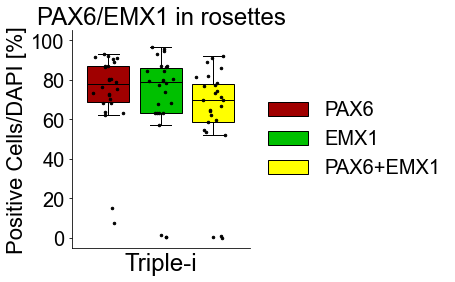

In [53]:
# 1. make aggregate SBNX, SBN, NT box plots
# 2. plot bar plots for cells in mistaken and non-rosettes

colors_full = [(160/255.,0,0),(0,192/255.,0),(255/255.,255/255.,0)]

for genes in [['emx1','pax6']]:
    
    #if genes != ['PAX6','SP8']: continue
    # first plot rosettes
    experiment = '_'.join(sorted(genes))
    genes = genes[::-1]
    df_sub = agg_df[(agg_df['experiment'] == experiment) & (agg_df['type'] == 'rosette')]
    vals = []
    positions = []
    colors = []
    pos_iter = 0
    n_tx = {}
    pval_dict = {}
    
    tx = 'Triple-i'
    df_sub_exp = df_sub[df_sub['protocol']==tx]
    n_tx[tx] = len(set(df_sub_exp['sample']))
    for k,gene in enumerate(genes):
        df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene]
        vals.append(list(df_sub_exp_gene['percent_pos']))
        positions.append(pos_iter)
        colors.append(colors_full[k])
        pos_iter += 1

    gene_combo = genes[0]+"_"+genes[1]
    df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene_combo]
    vals.append(list(df_sub_exp_gene['percent_pos']))
    positions.append(pos_iter)
    colors.append(colors_full[k+1])
    pos_iter += 1
    # double and triple combos
    pos_iter+=1
    
    pval_dict_full[experiment] = pval_dict
    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(111)

    bp = ax.boxplot(vals,positions=positions,showfliers=False,vert=True, patch_artist=True,zorder=1,widths=0.8)
    for j,patch in enumerate(bp['boxes']):
        patch.set_facecolor(color=colors[j])
    for j,whisker in enumerate(bp['whiskers']):
        whisker.set(color='black', linewidth=1)
    for j,cap in enumerate(bp['caps']):
        cap.set(color='black', linewidth=1)
    for j,median in enumerate(bp['means']):
        median.set(color='black', linewidth=1)
    for j,median in enumerate(bp['medians']):
        median.set(color='black', linewidth=1)

    for val,pos,col in zip(vals,positions,colors):
        plt.plot([pos]*len(val)+np.random.randn(len(val))*0.1,val,'.',markersize=5,color='black',
                 zorder=2,alpha=1)#markerfacecolor='none',
    
    plt.ylim(-0.05,1.05)
    plt.xlim(plt.xlim()[0]-0.2,plt.xlim()[1]+0.2)
    for k,gene in enumerate(genes):
        plt.bar(-10,0,color=colors_full[k],label=gene.upper(),edgecolor='black')
    plt.bar(-10,0,color=colors_full[k+1],label=genes[0].upper()+"+"+genes[1].upper(),edgecolor='black')
    plt.legend(fontsize=14)
    #plt.xticks([1,5,9],[tx+'\n(N='+str(n_tx[tx])+')' for tx in ['Inhibitor-free','Dual-SMAD-i','Triple-i']],fontsize=18)
    #plt.xticks([1,5,9],['Inhibitor\nfree','Dual\nSMAD-i','Triple-i'],fontsize=18)
    plt.xticks([])
    plt.xlabel('Triple-i',fontsize=24)
    plt.yticks(fontsize=14)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20,frameon=False)
    plt.ylabel('Positive Cells/DAPI [%]',fontsize=22)
    plt.yticks([0,0.2,0.4,0.6,0.8,1],['0','20','40','60','80','100'],fontsize=20)
    plt.title('/'.join([gene.upper() for gene in genes]) + ' in rosettes',fontsize=24)
    #plt.tight_layout()
    plt.savefig('figures/suppfig2/'+experiment+'.png',dpi=500,bbox_inches='tight')
    plt.savefig('figures/suppfig2/'+experiment+'.pdf')